# Echo

> **Delta** model trained on slightly different data

### Data

> `wrapped_20000_gaussian_spikes_twentyfive_percent_(A-D).bz2`
>
 - 20000 Entries with some spikes
 - tau randomly selected from -100 to 100 (uniform)
 - phi randomly selected from 0 to 2$\pi$
 
 
>  5% of the data has spikes (so out of 20000 entries, 5000 have some spikes)
-  spikes are added to up to 2 percent of each entry
 - so for 1024 frequencies, up to 20 channels have a spike
- spikes are randomly chosen from gaussian with sigma = pi / 2 and added to the 1%

### Results

> **Echo** performs well.
>
- After 1500 Epochs
 - score : 0.927080145595093
 - std   : 1.9592909644447047
>
>
- After 3000 Epochs
 - score :  1.040194315149206
 - std.  :  2.032850021787169
>
>
- After 4500 Epochs
 - score :  0.9258464699962601
 - std.  :  1.883307959939107
>
>
- After 6000 Epochs
 - score :  0.7981785949274081
 - std.  :  1.7501127572327515
 
> This network will be used as a seed for **Foxtrot**

### Log number
> 659566

In [1]:
import tensorflow as tf, numpy as np, pandas as pd, matplotlib.pyplot as plt, glob, sys, io

from sklearn.preprocessing import MinMaxScaler

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%config InlineBackend.figure_format = 'retina'

/Applications/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#import data
data_df = pd.read_csv('../../data/wrapped_20000_gaussian_spikes_twentyfive_percent_A.bz2', compression = 'bz2')

# split random 80% / 20%
training_data_df = data_df.sample(frac = 0.8)
testing_data_df = data_df.loc[~data_df.index.isin(training_data_df.index)]

# separate input features from output
X_training = training_data_df.drop('tau', axis = 1).values
Y_training = training_data_df[['tau']].values

X_testing = testing_data_df.drop('tau', axis = 1).values
Y_testing = testing_data_df[['tau']].values

# setup data scalers
X_scaler = MinMaxScaler(feature_range = (0,1))
Y_scaler = MinMaxScaler(feature_range = (0,1))

# scale data
X_scaled_training = X_scaler.fit_transform(X_training)
Y_scaled_training = Y_scaler.fit_transform(Y_training)

X_scaled_testing = X_scaler.transform(X_testing)
Y_scaled_testing = Y_scaler.transform(Y_testing)

In [3]:
# setup layer & NN parameters
number_of_inputs = X_scaled_training.shape[1]
number_of_outputs = Y_scaled_training.shape[1]

In [4]:
layer_1_nodes = 115
layer_2_nodes = 280
layer_3_nodes = 450
layer_4_nodes = 290
layer_5_nodes = 205
layer_6_nodes = 105
layer_7_nodes = 50

learning_rate = 0.0015
training_epochs = 1500

In [5]:
# one random serial number per NN graph
# - add letters to end for repeated runs
# - only run this cell once!
log_random_serial_number = '{}'.format(np.random.randint(100000,999999))
print(log_random_serial_number)

659566


In [6]:
def log_dir(log_random_serial_number):
    master_log_path = '../../logs/'
    log_num = len(glob.glob(master_log_path + log_random_serial_number + '*'))
    
    direc = master_log_path + log_random_serial_number
    if log_num > 0:
        # assumes less than 26 runs per graph
        direc += chr(ord('@') + log_num)
    return direc

In [7]:
log_direc = log_dir(log_random_serial_number)
print(log_direc)

../../logs/659566


#### 7 layers, 6 dropouts...

In [8]:
tf.reset_default_graph()

# Input Layer
with tf.variable_scope('input'):
    X  = tf.placeholder(tf.float32, shape = (None, number_of_inputs))
    
# for dropout keep_prob = 0.5, for testing keep_prob = 1
with tf.variable_scope('keep'):
    keep_prob = tf.placeholder(tf.float32)

# Layer 1
with tf.variable_scope('layer_1'):

    biases = tf.get_variable(name = "biases1",
                             shape = [layer_1_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights1",
                              shape  = [number_of_inputs, layer_1_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_1_output = tf.nn.leaky_relu(tf.matmul(X, weights) + biases)
    
with tf.variable_scope('dropout_12'):
    drop_out_12 = tf.nn.dropout(layer_1_output, keep_prob)     
    
    
# Layer 2
with tf.variable_scope('layer_2'):

    biases = tf.get_variable(name = "biases2",
                             shape = [layer_2_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights2",
                              shape  = [layer_1_nodes, layer_2_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_2_output = tf.nn.relu(tf.matmul(drop_out_12, weights) + biases)
    
with tf.variable_scope('dropout_23'):
    drop_out_23 = tf.nn.dropout(layer_2_output, keep_prob)     
    


# Layer 3
with tf.variable_scope('layer_3'):

    biases = tf.get_variable(name = "biases3",
                             shape = [layer_3_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights3",
                              shape  = [layer_2_nodes, layer_3_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_3_output = tf.nn.relu(tf.matmul(drop_out_23, weights) + biases)

with tf.variable_scope('dropout_34'):
    drop_out_34 = tf.nn.dropout(layer_3_output, keep_prob)  
    
# Layer 4
with tf.variable_scope('layer_4'):

    biases = tf.get_variable(name = "biases4",
                             shape = [layer_4_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights4",
                              shape  = [layer_3_nodes, layer_4_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_4_output = tf.nn.relu(tf.matmul(drop_out_34, weights) + biases)

with tf.variable_scope('dropout_45'):
    drop_out_45 = tf.nn.dropout(layer_4_output, keep_prob)  

# Layer 5
with tf.variable_scope('layer_5'):

    biases = tf.get_variable(name = "biases5",
                             shape = [layer_5_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights5",
                              shape  = [layer_4_nodes, layer_5_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_5_output = tf.nn.relu(tf.matmul(drop_out_45, weights) + biases)

with tf.variable_scope('dropout_56'):
    drop_out_56 = tf.nn.dropout(layer_5_output, keep_prob)  
    
# Layer 6
with tf.variable_scope('layer_6'):

    biases = tf.get_variable(name = "biases6",
                             shape = [layer_6_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights6",
                              shape  = [layer_5_nodes, layer_6_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_6_output = tf.nn.relu(tf.matmul(drop_out_56, weights) + biases)
    
with tf.variable_scope('dropout_67'):
    drop_out_67 = tf.nn.dropout(layer_6_output, keep_prob) 

# Layer 7
with tf.variable_scope('layer_7'):

    biases = tf.get_variable(name = "biases7",
                             shape = [layer_7_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights7",
                              shape  = [layer_6_nodes, layer_7_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_7_output = tf.nn.relu(tf.matmul(drop_out_67, weights) + biases)


# Output layer

with tf.variable_scope('output'):

    biases = tf.get_variable(name = "biases_out",
                             shape = [number_of_outputs],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights_out",
                              shape  = [layer_7_nodes, number_of_outputs],
                         initializer = tf.contrib.layers.xavier_initializer())


    prediction = tf.nn.relu(tf.matmul(layer_7_output, weights) + biases)

with tf.variable_scope('cost'):

    Y = tf.placeholder(tf.float32, shape = (None, 1))
    cost = tf.reduce_mean(tf.squared_difference(prediction, Y))

with tf.variable_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate, epsilon=1e-08).minimize(cost)

with tf.variable_scope('logging'):
    tf.summary.histogram('predictions', prediction)
    tf.summary.scalar('current_cost', cost)
    summary = tf.summary.merge_all()

In [9]:
saver = tf.train.Saver()

In [10]:
log_direc

'../../logs/659566'

INFO:tensorflow:Restoring parameters from ../../logs/517631/trained_model.ckpt-5999
 epoch:    0 testing_cost: 0.0064189443

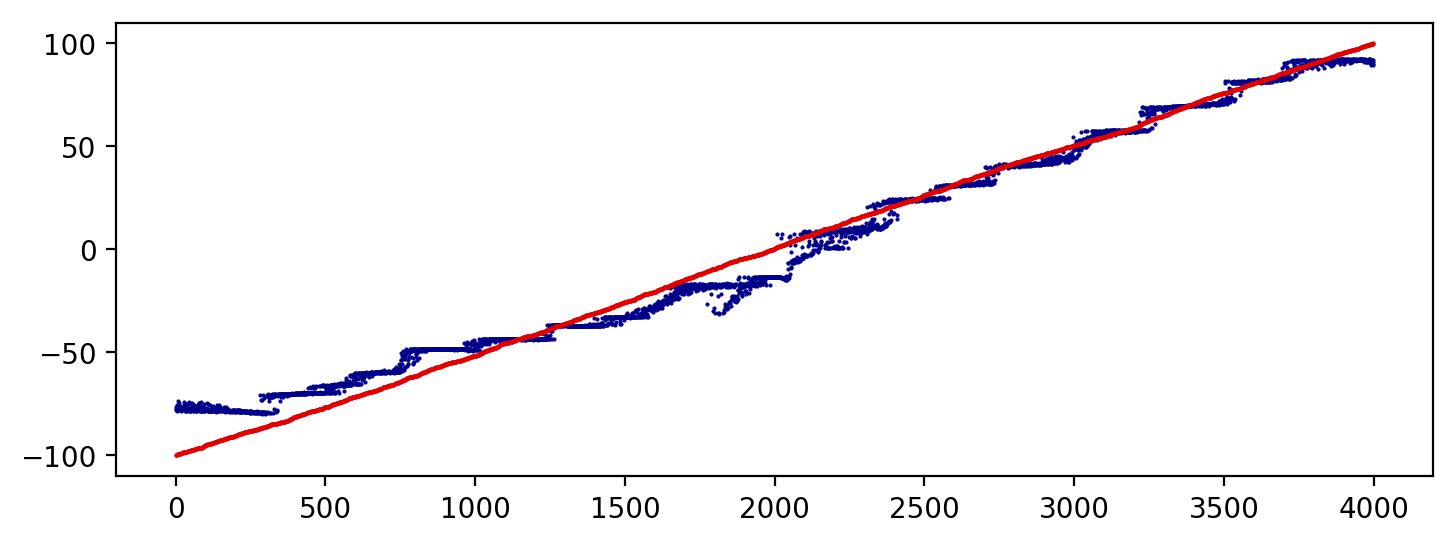

 epoch:   50 testing_cost: 0.0037301423

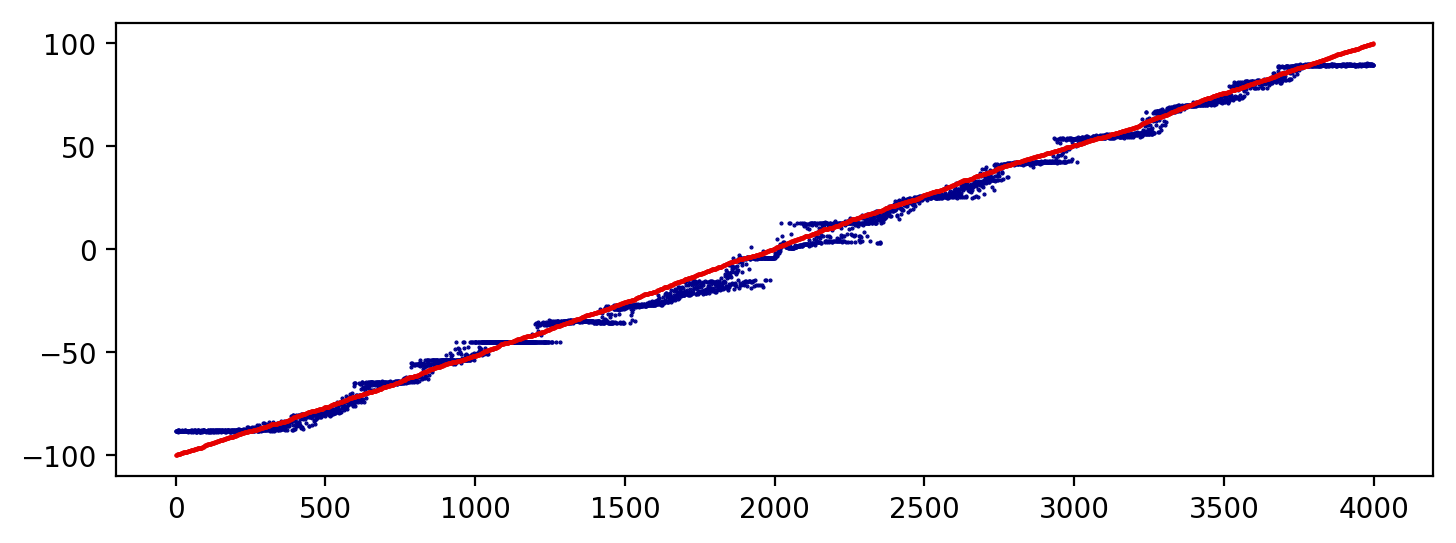

 epoch:  100 testing_cost: 0.0017940465

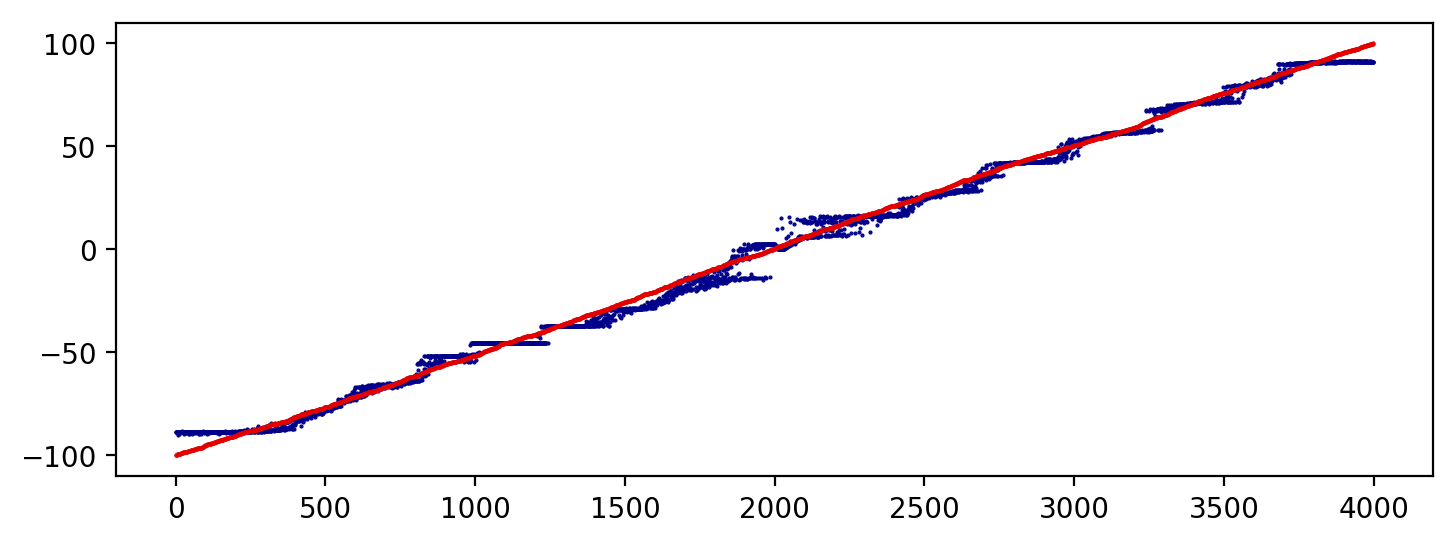

 epoch:  150 testing_cost: 0.0012313642

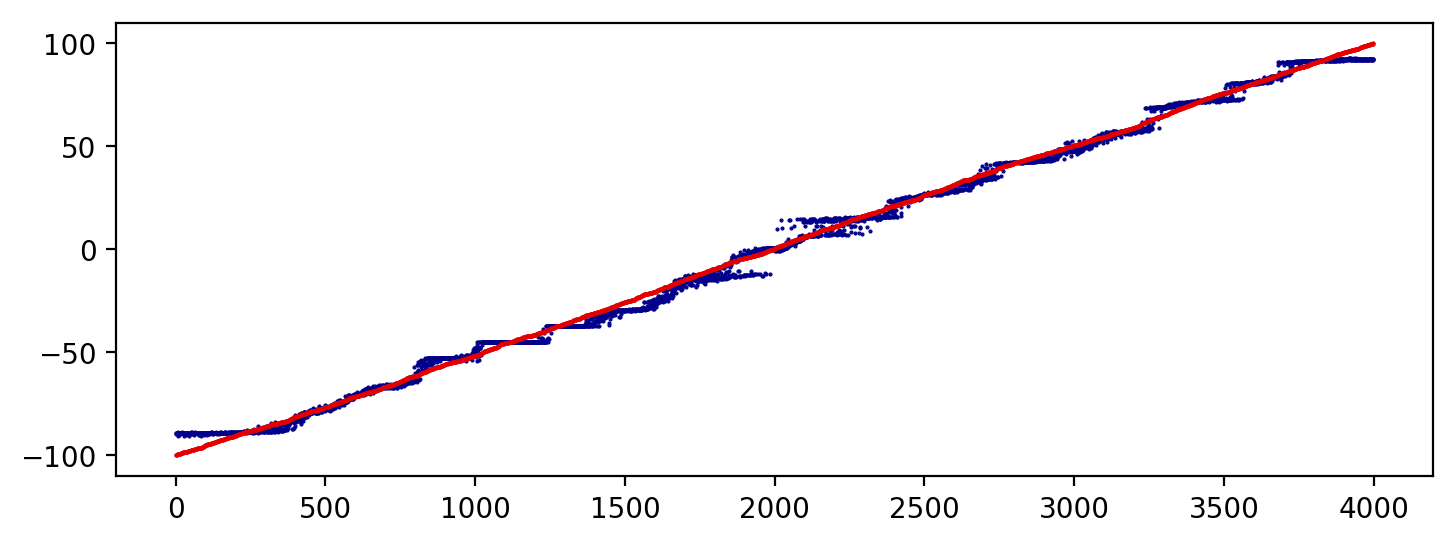

 epoch:  200 testing_cost: 0.0012411565

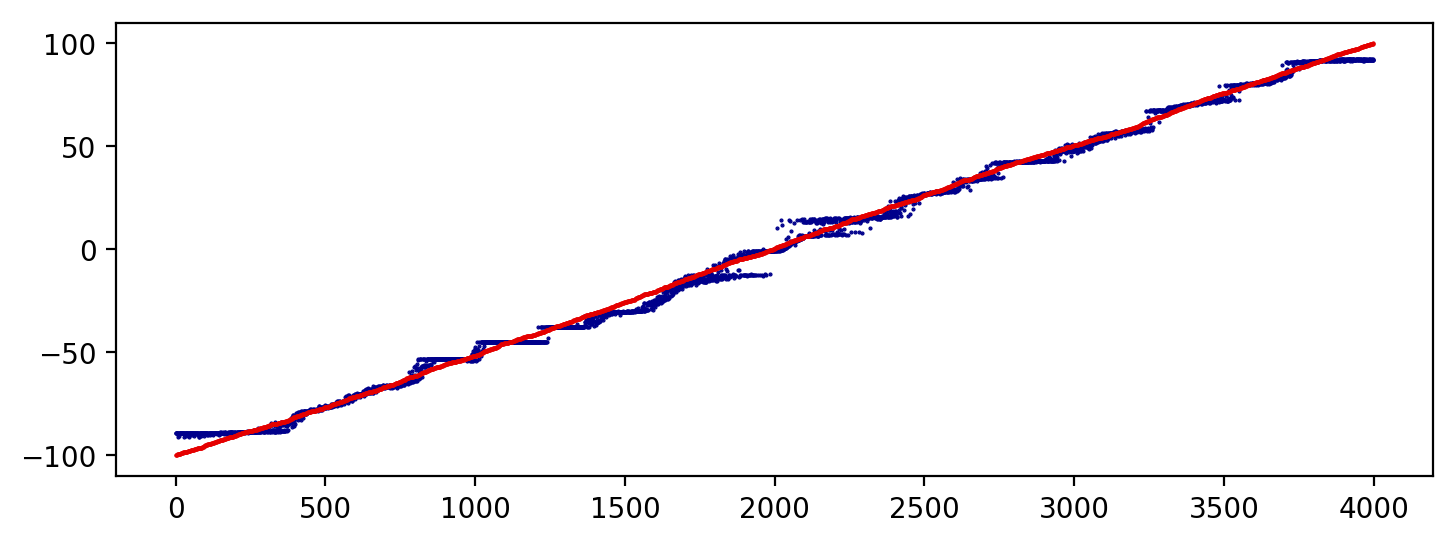

 epoch:  250 testing_cost: 0.0014285709

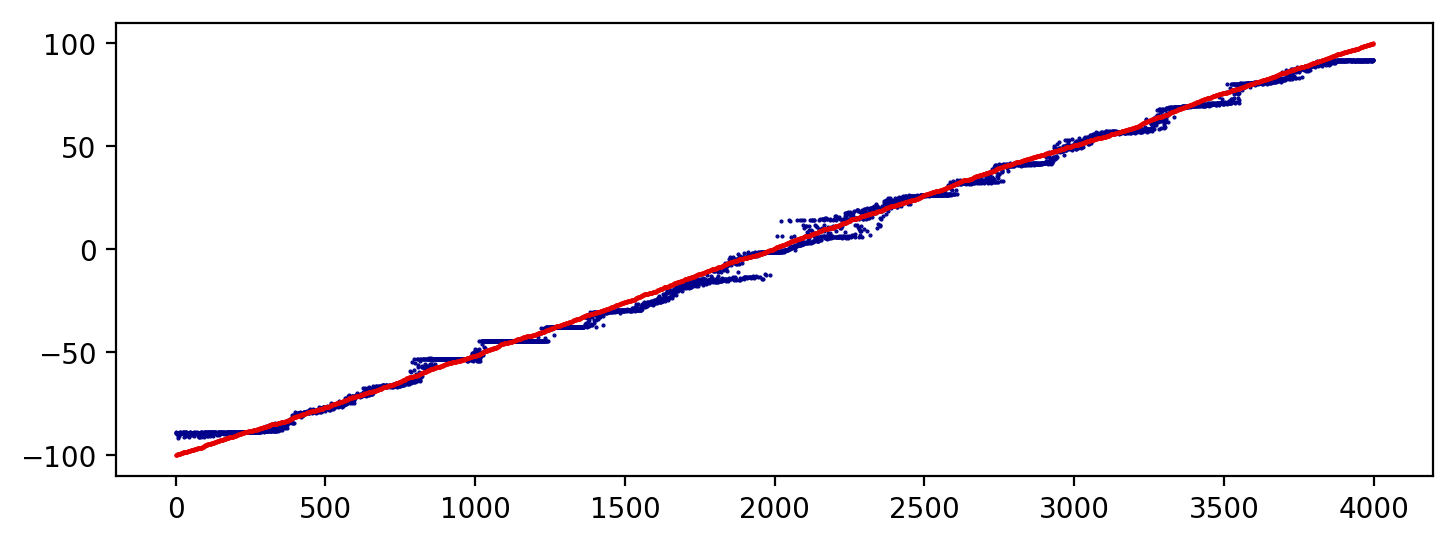

 epoch:  300 testing_cost: 0.0011861231

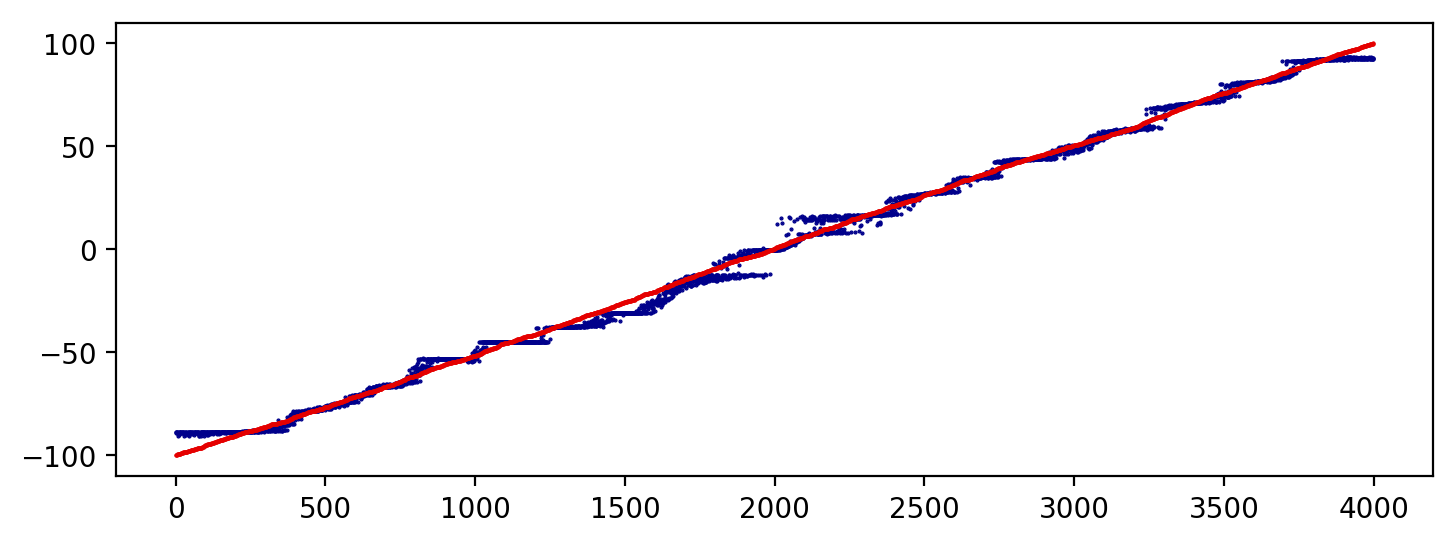

 epoch:  350 testing_cost: 0.0010989612

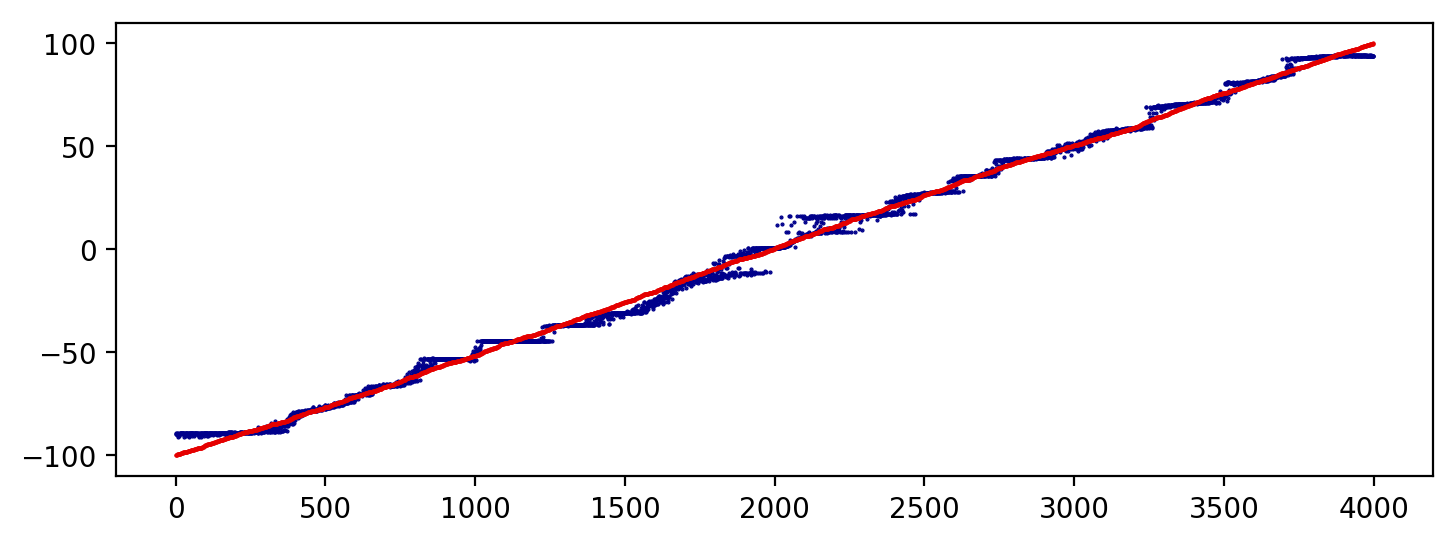

 epoch:  400 testing_cost: 0.0010320029

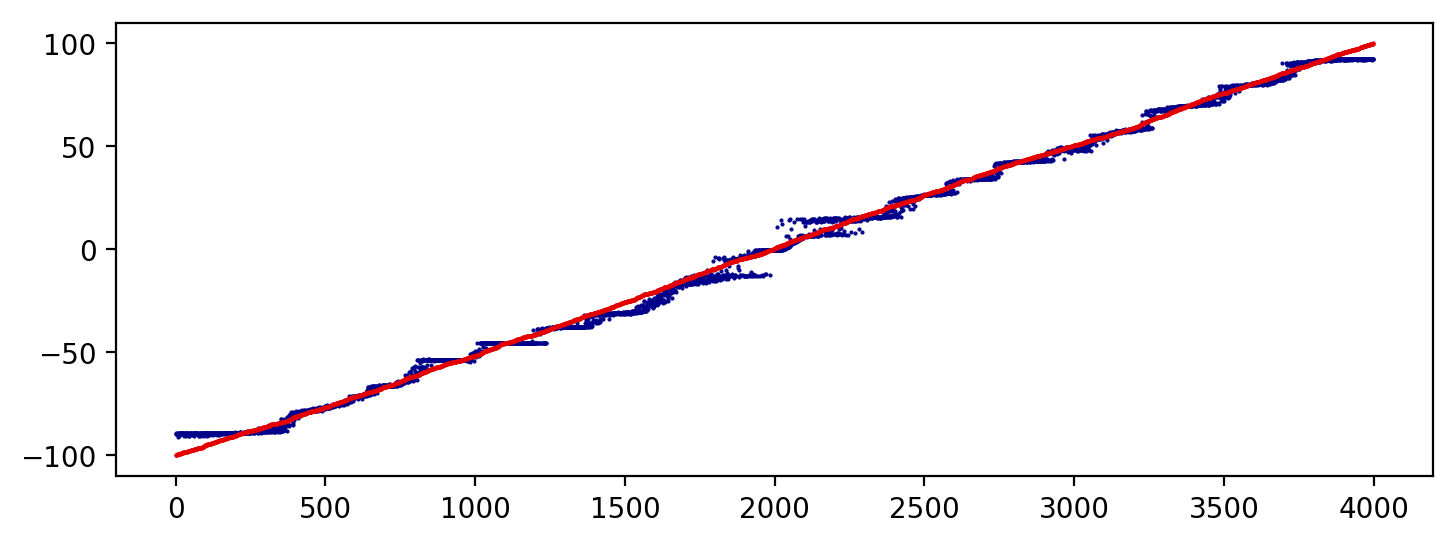

 epoch:  450 testing_cost: 0.0008933870

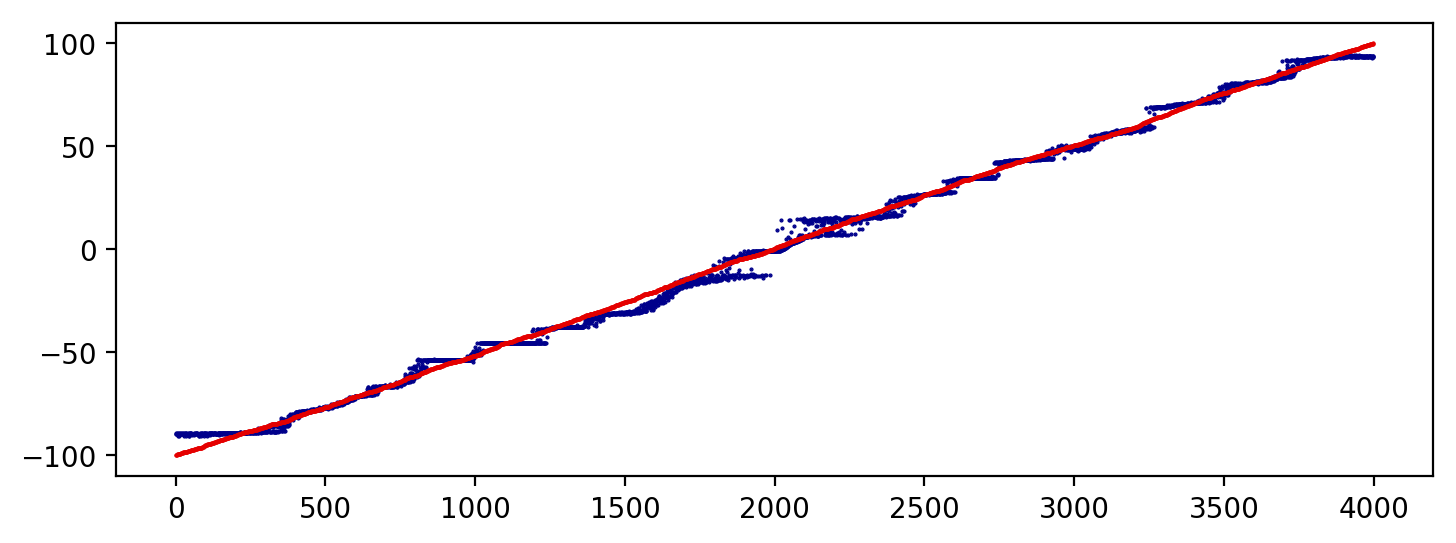

 epoch:  500 testing_cost: 0.0008690169

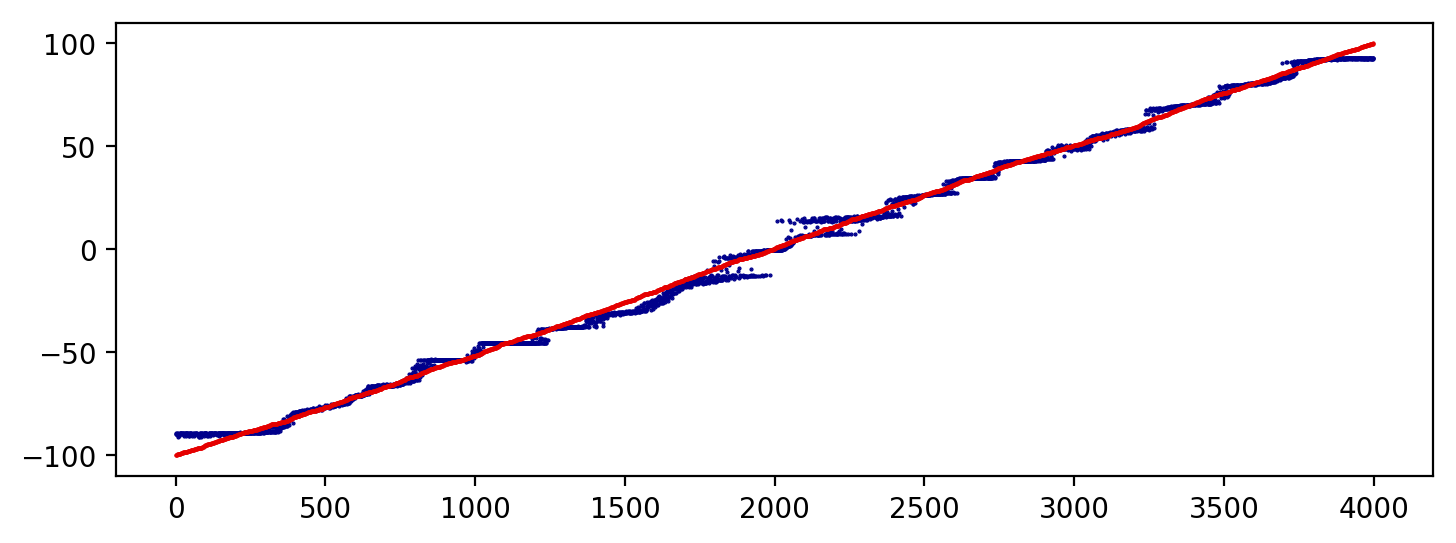

 epoch:  550 testing_cost: 0.0007962962

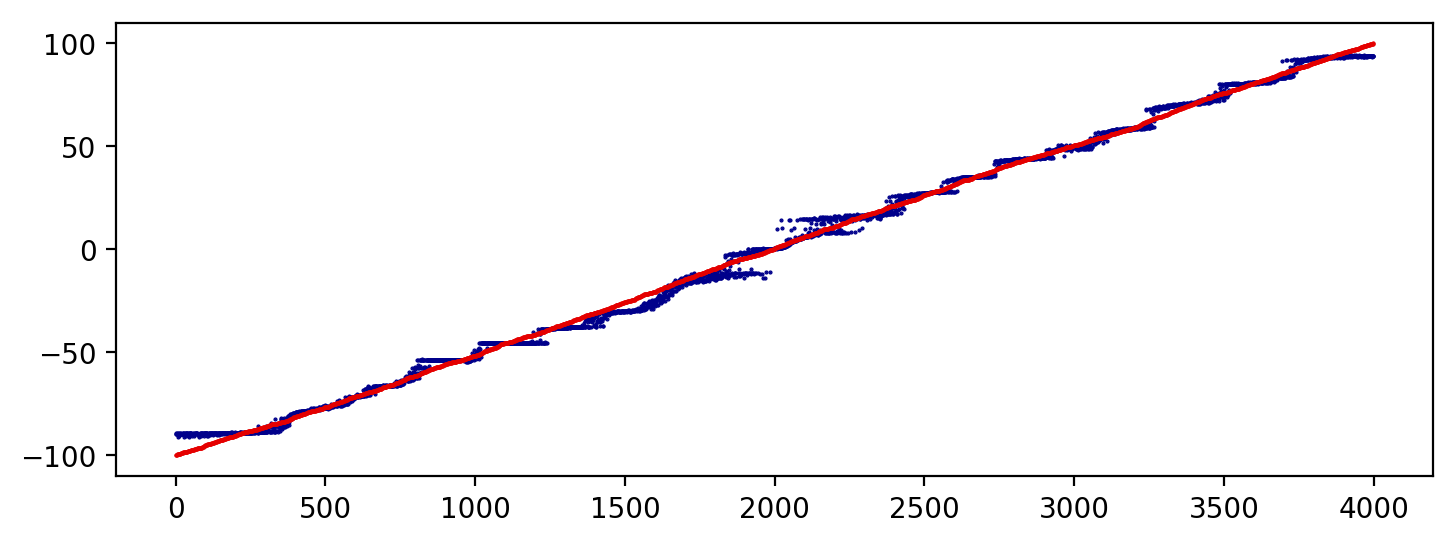

 epoch:  600 testing_cost: 0.0009743372

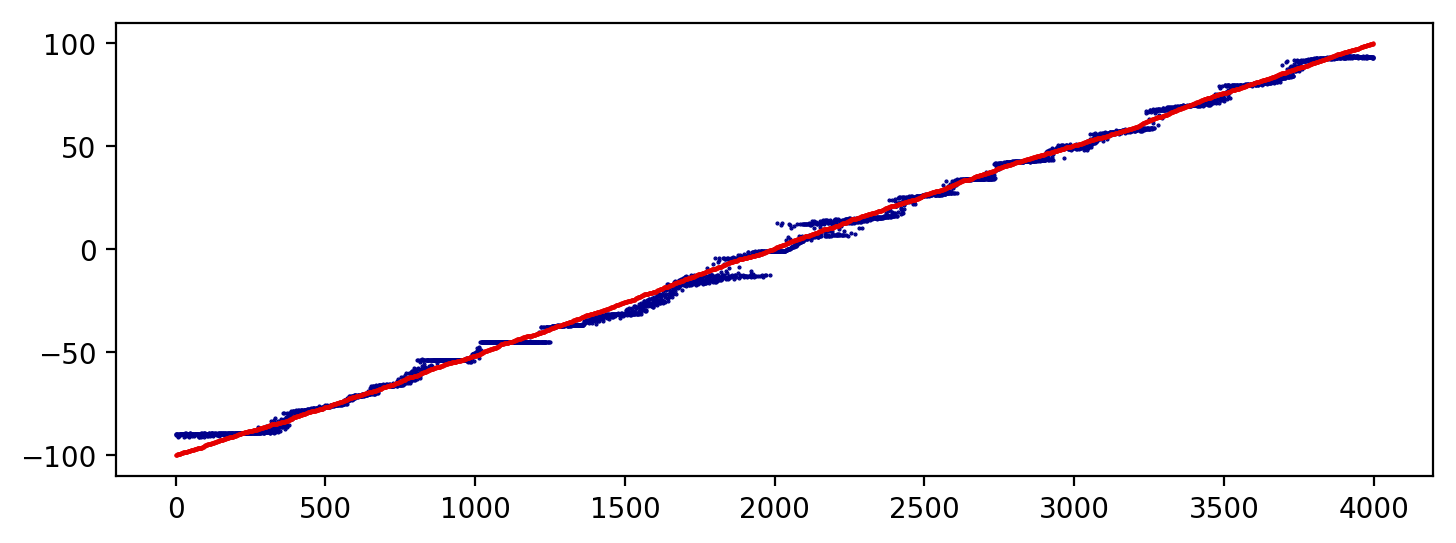

 epoch:  650 testing_cost: 0.0010573838

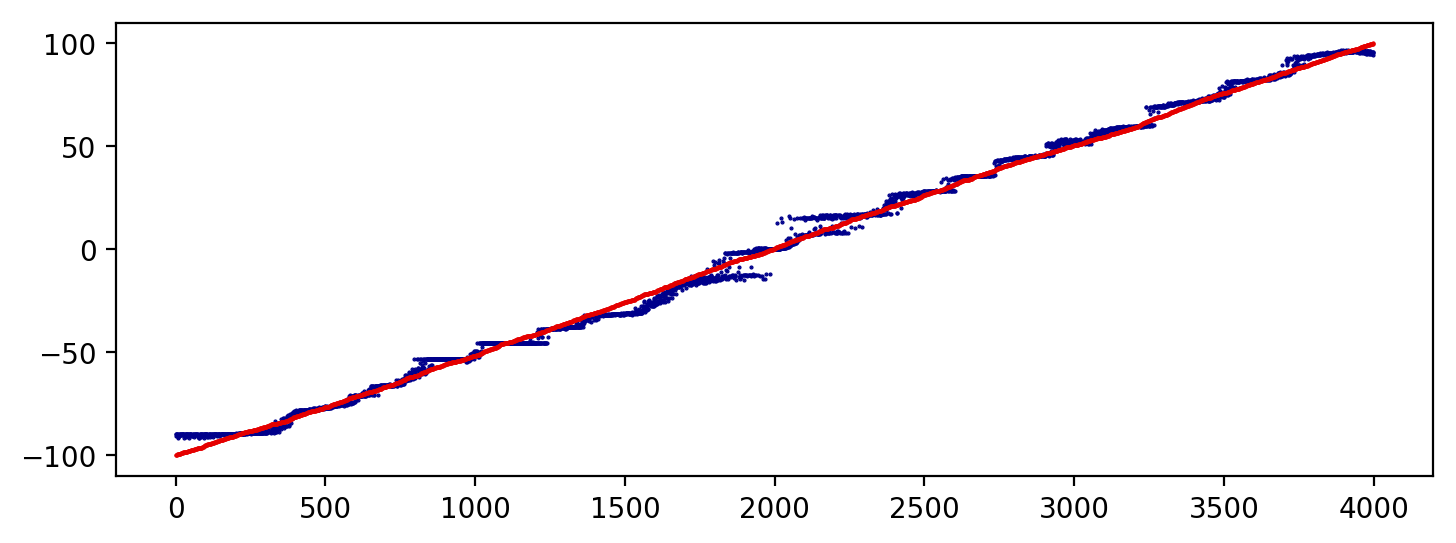

 epoch:  700 testing_cost: 0.0009306198

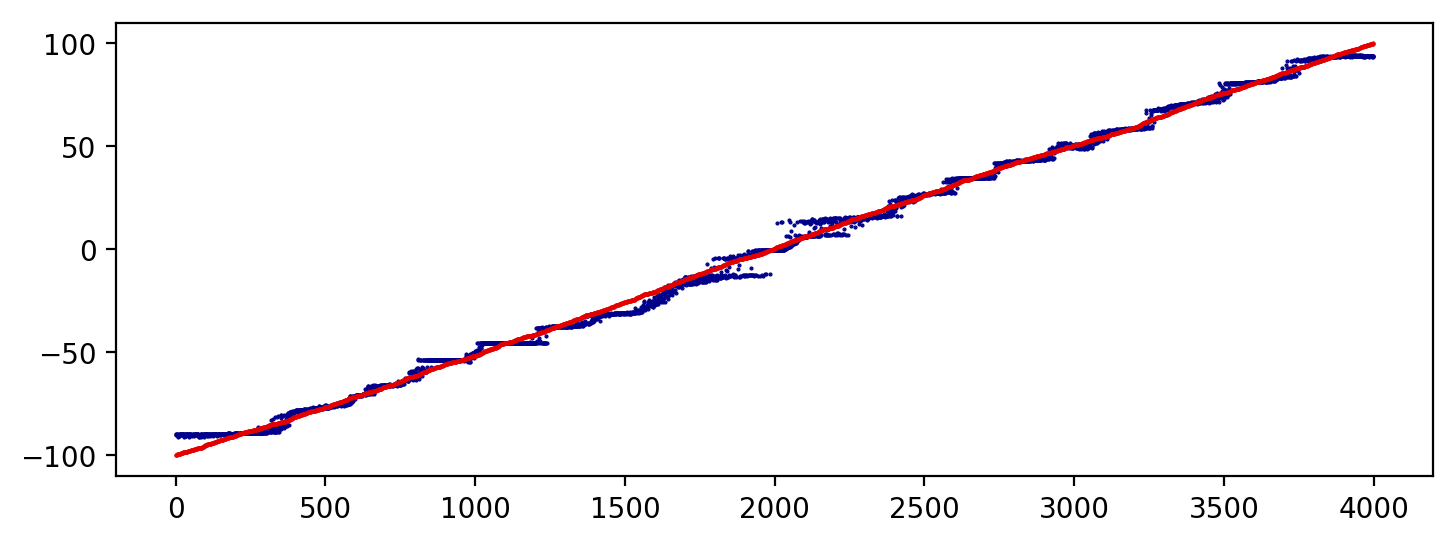

 epoch:  750 testing_cost: 0.0008579339

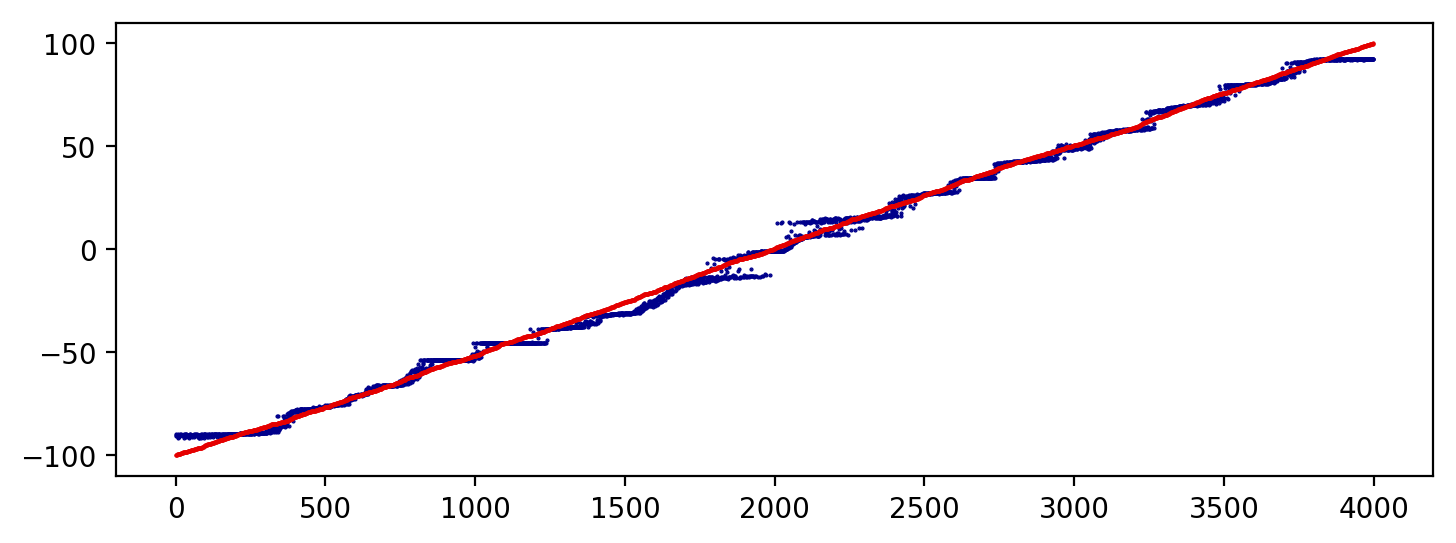

 epoch:  800 testing_cost: 0.0007693676

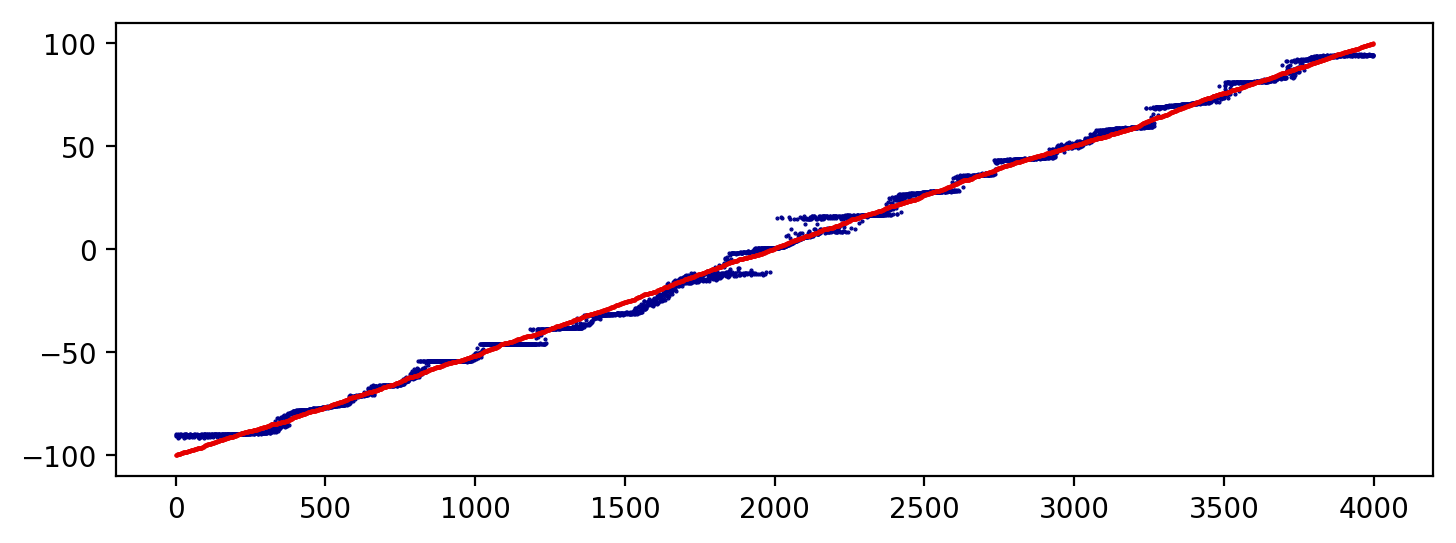

 epoch:  850 testing_cost: 0.0007176522

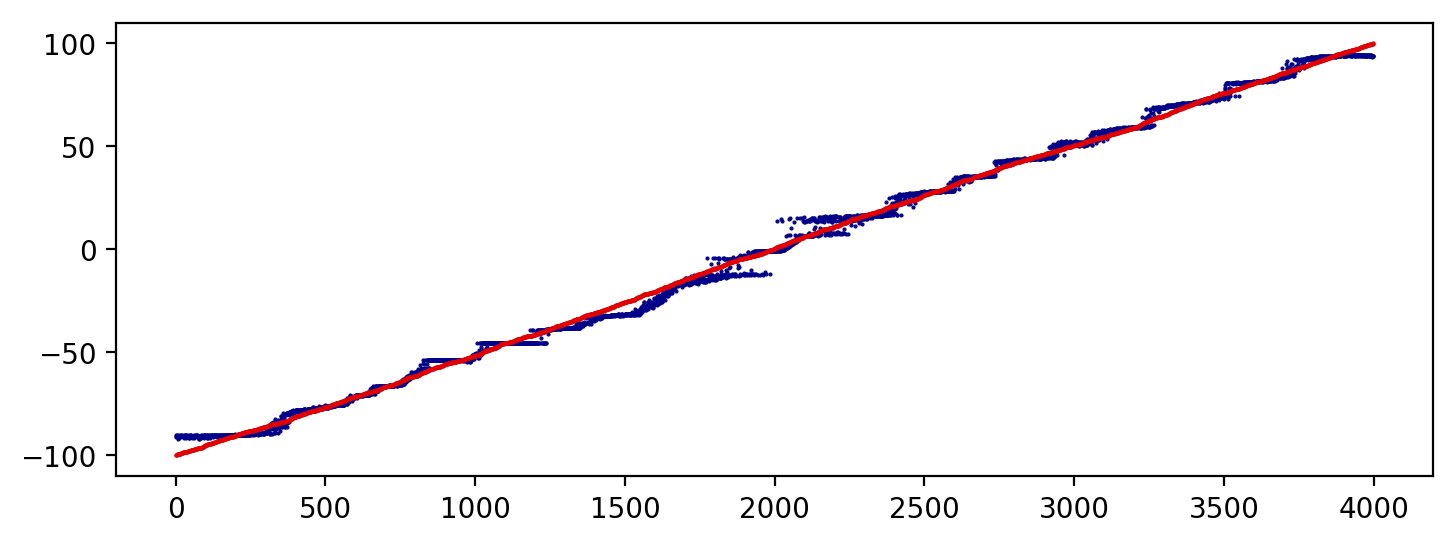

 epoch:  900 testing_cost: 0.0010469081

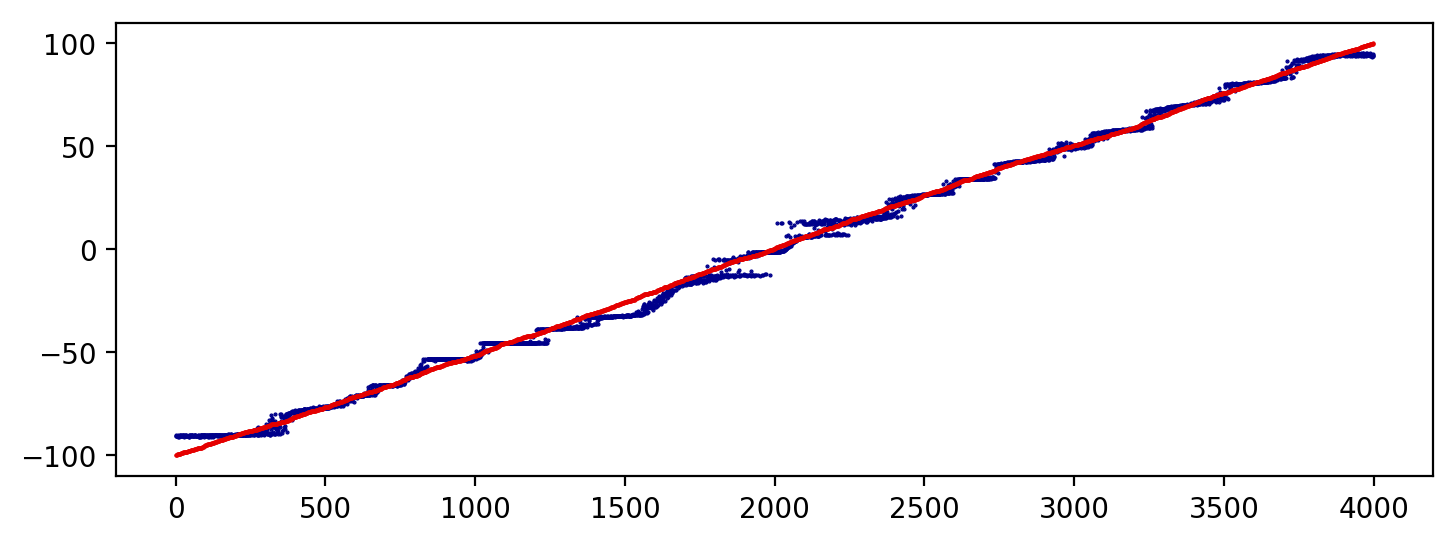

 epoch:  950 testing_cost: 0.0008232217

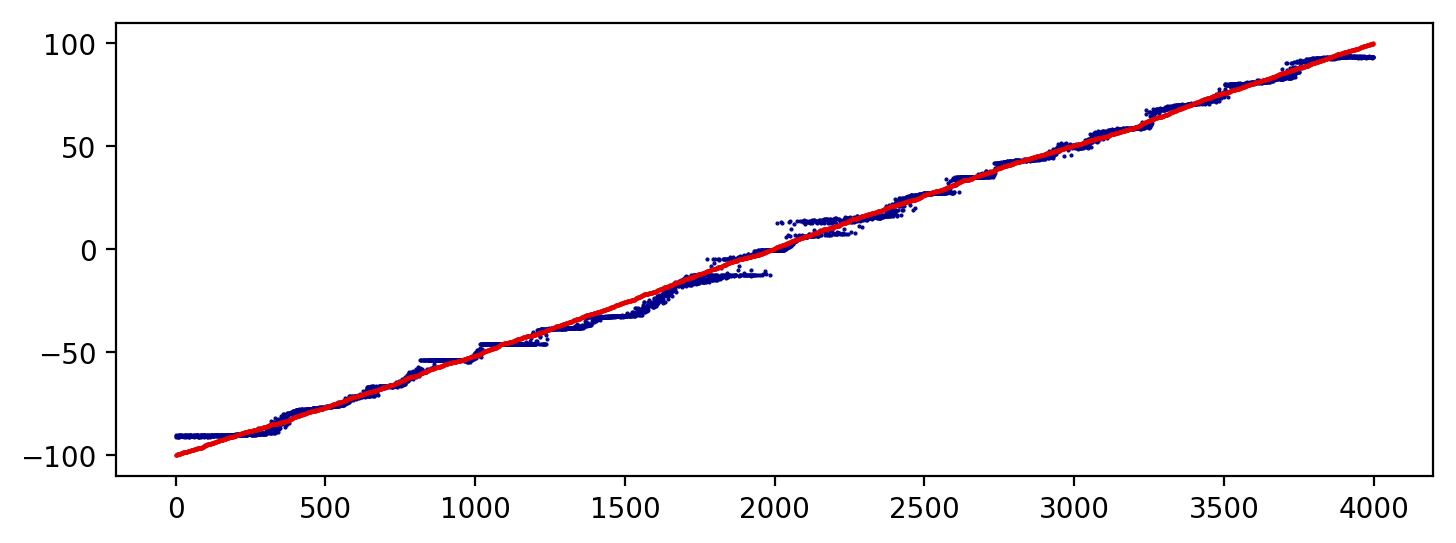

 epoch: 1000 testing_cost: 0.0008569803

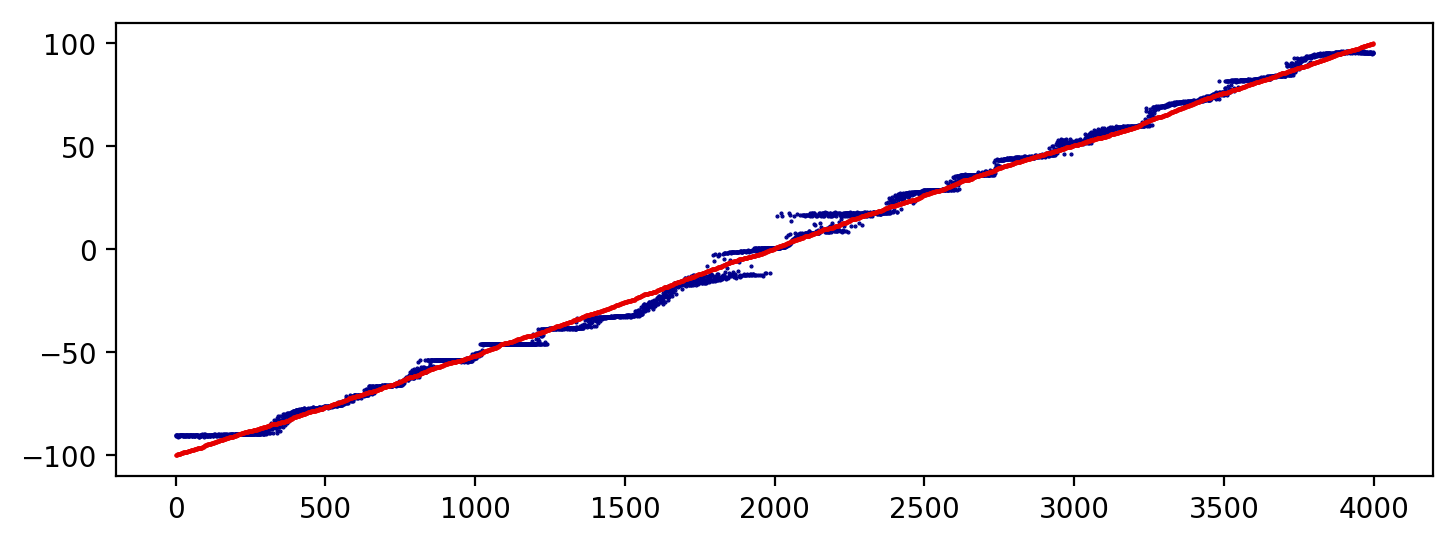

 epoch: 1050 testing_cost: 0.0009360448

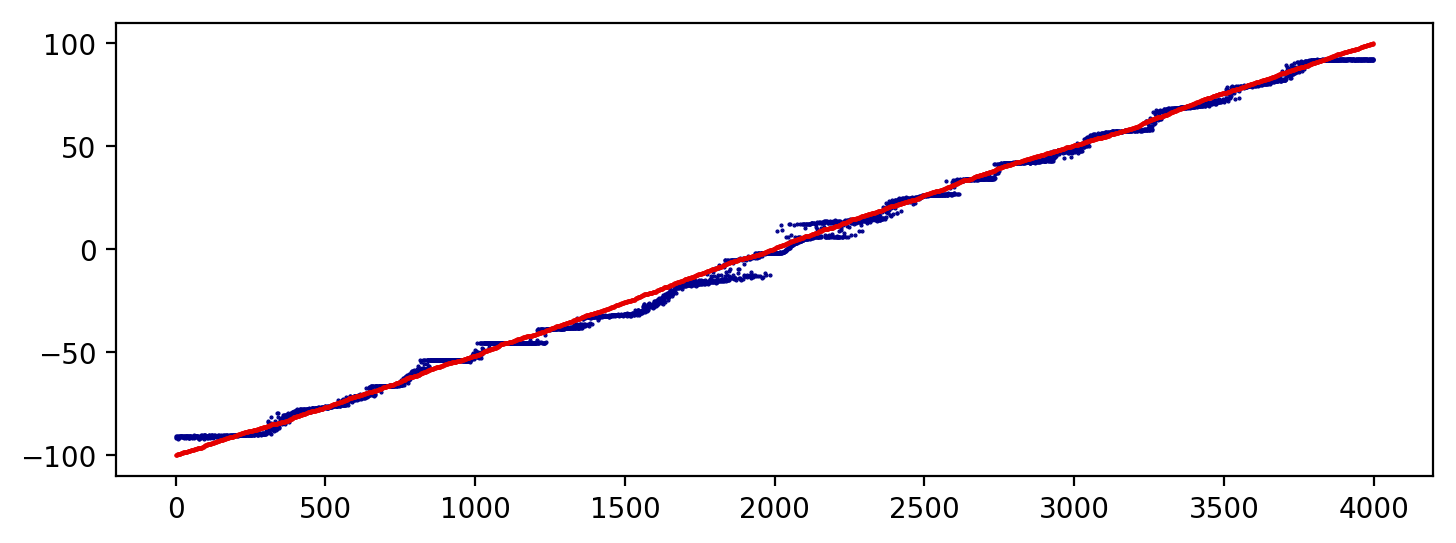

 epoch: 1100 testing_cost: 0.0008440828

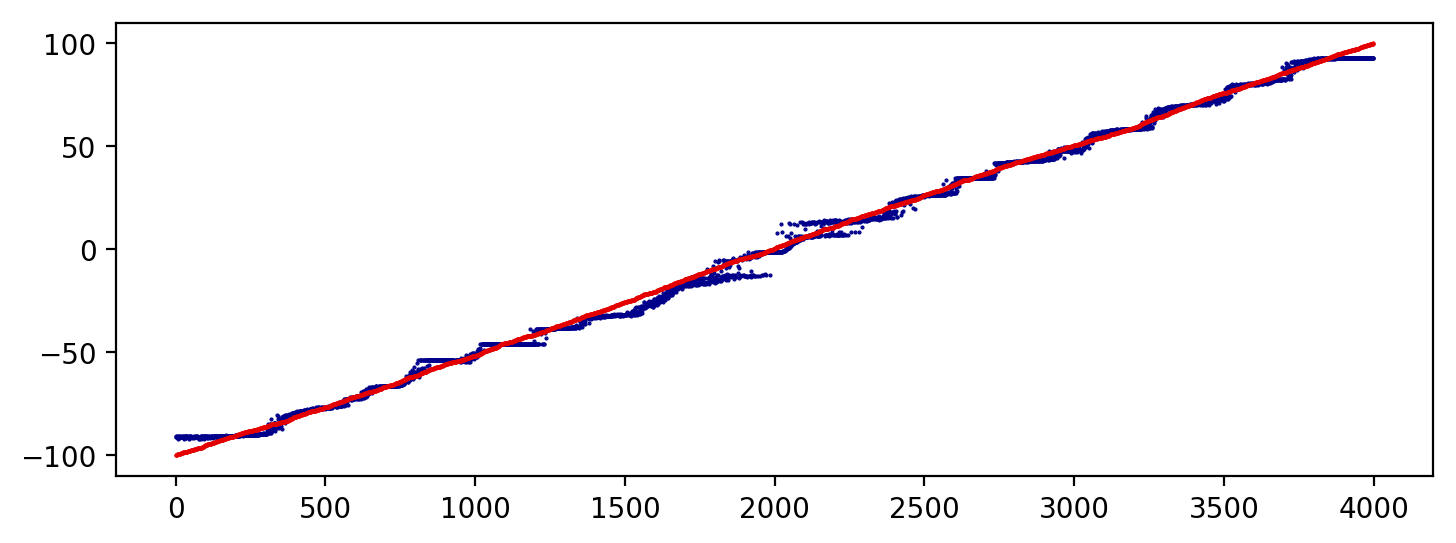

 epoch: 1150 testing_cost: 0.0009120973

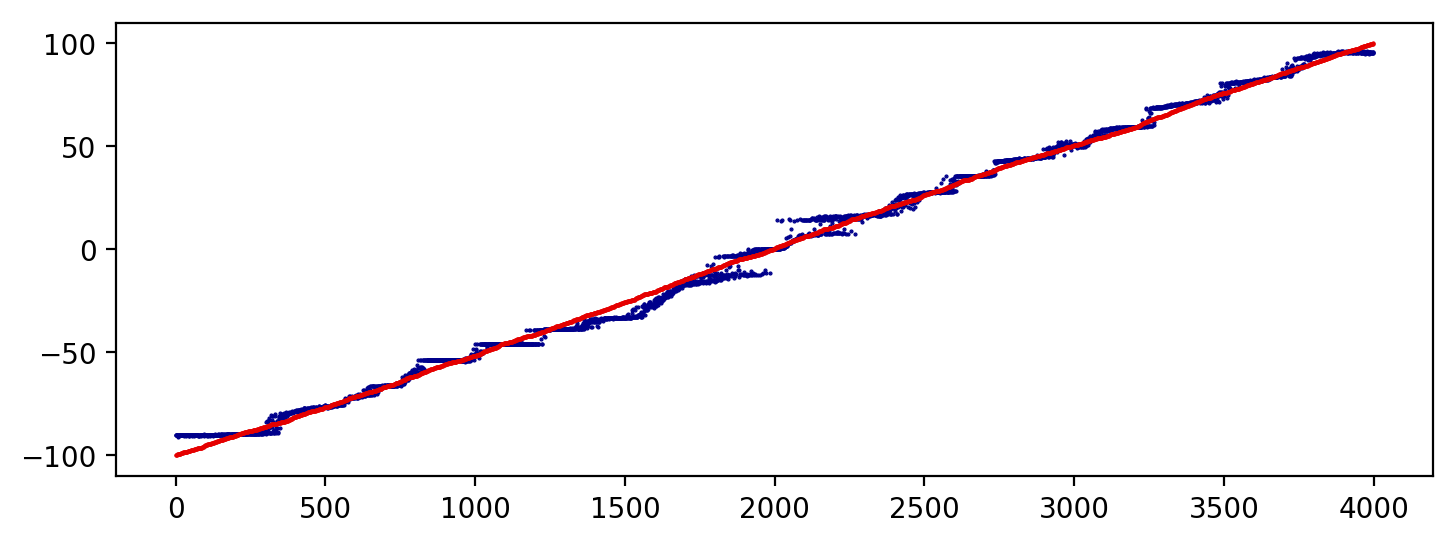

 epoch: 1200 testing_cost: 0.0014720600

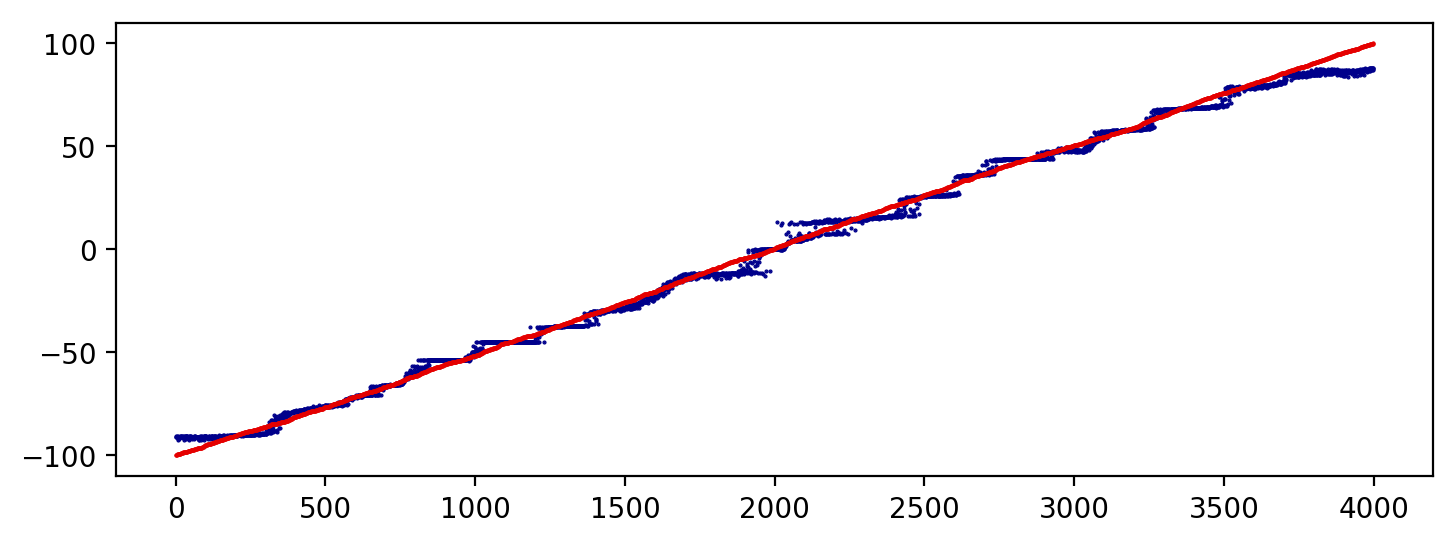

 epoch: 1250 testing_cost: 0.0010600835

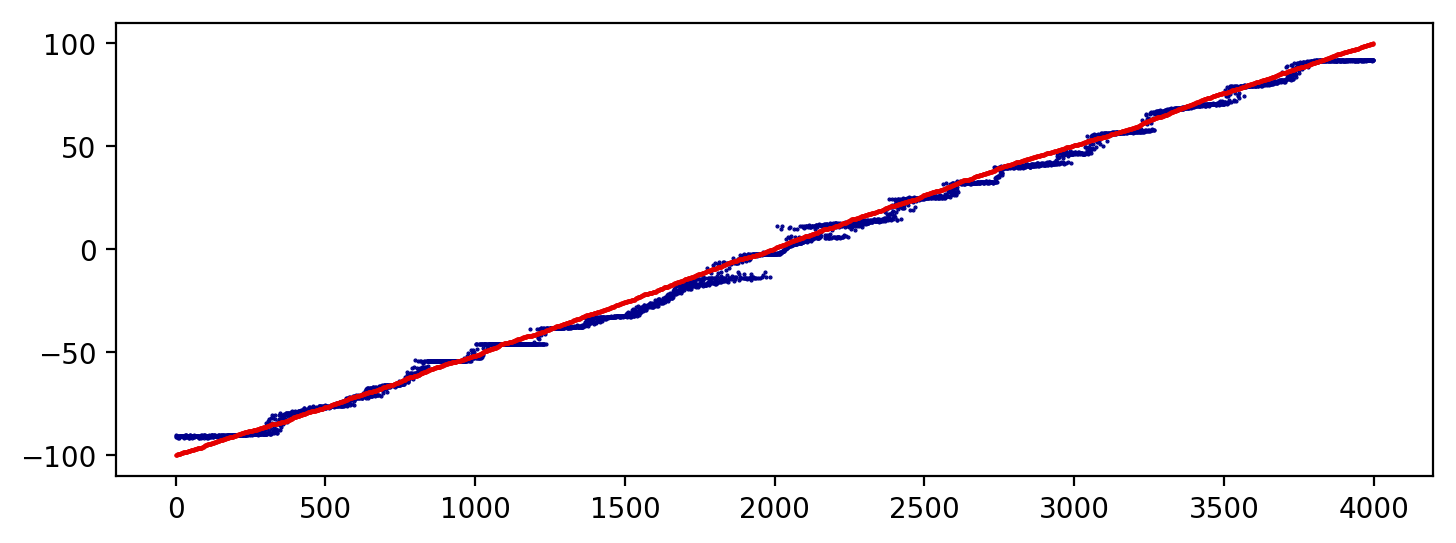

 epoch: 1300 testing_cost: 0.0009441384

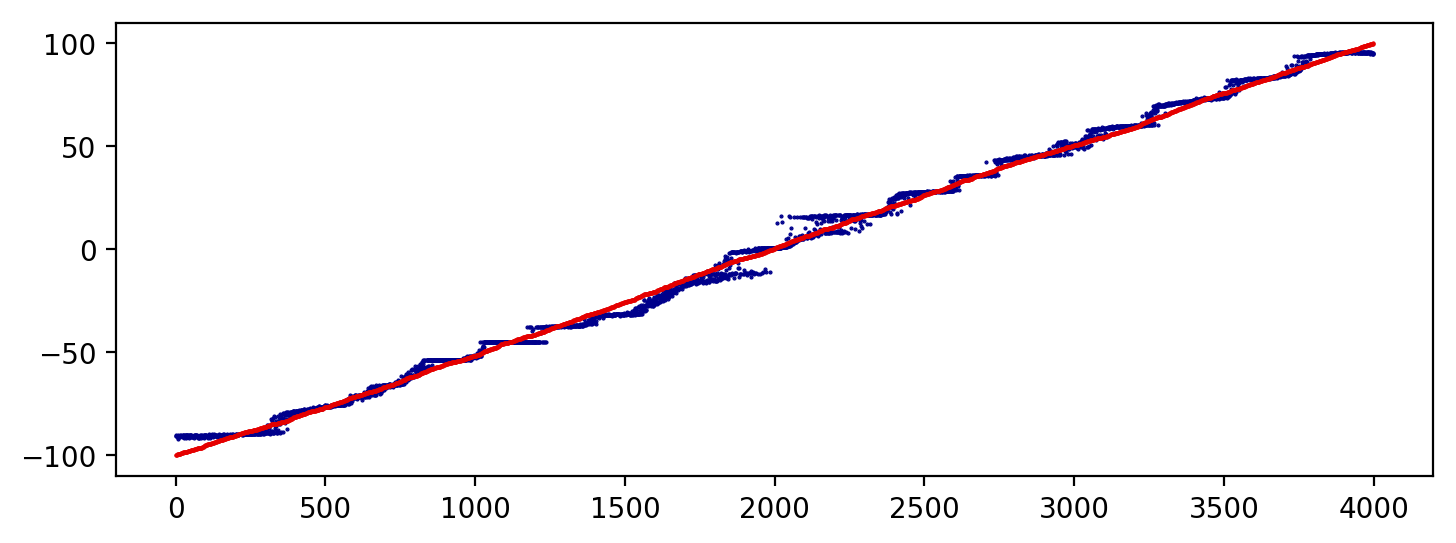

 epoch: 1350 testing_cost: 0.0012544142

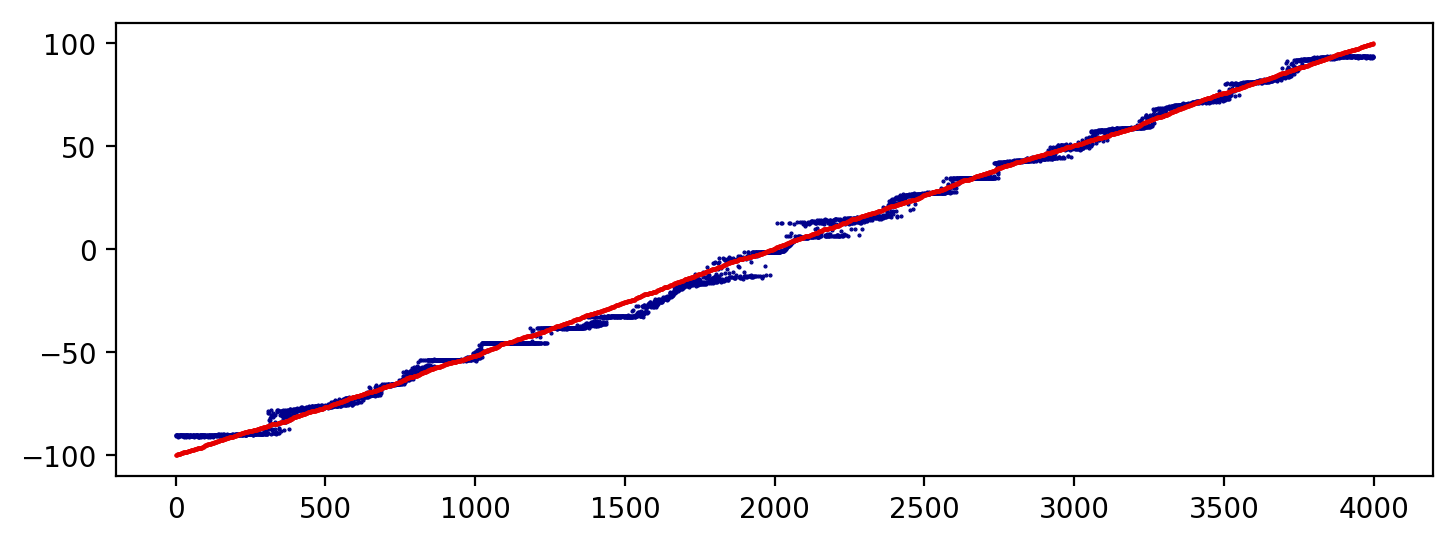

 epoch: 1400 testing_cost: 0.0014592638

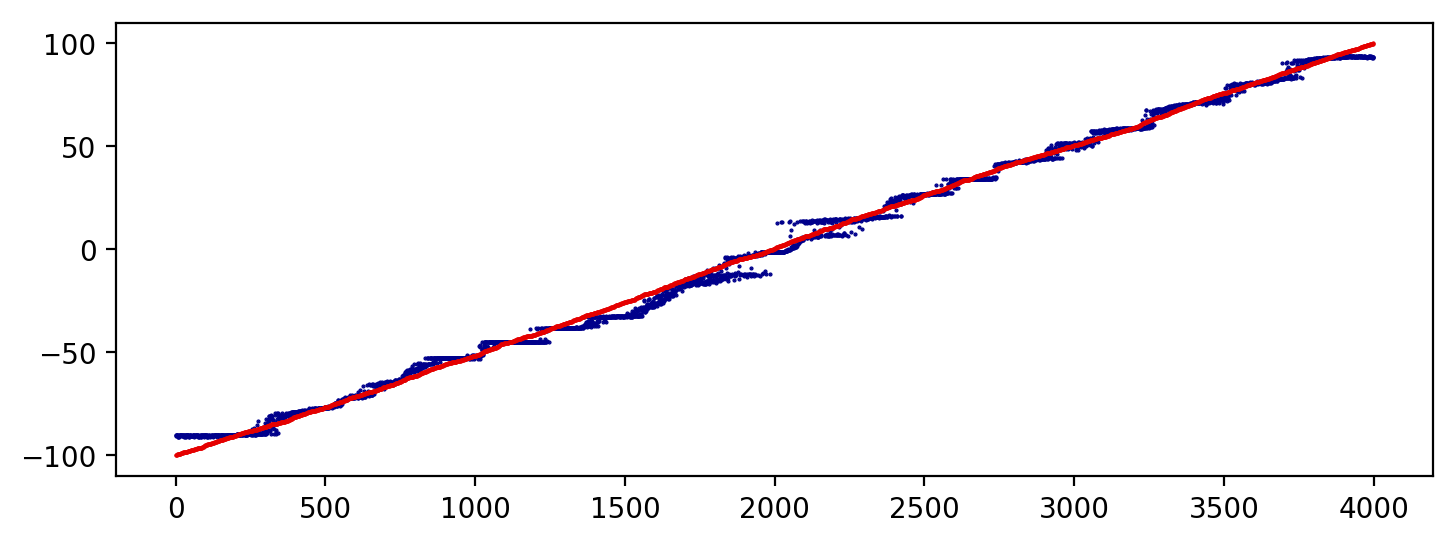

 epoch: 1450 testing_cost: 0.0009898104

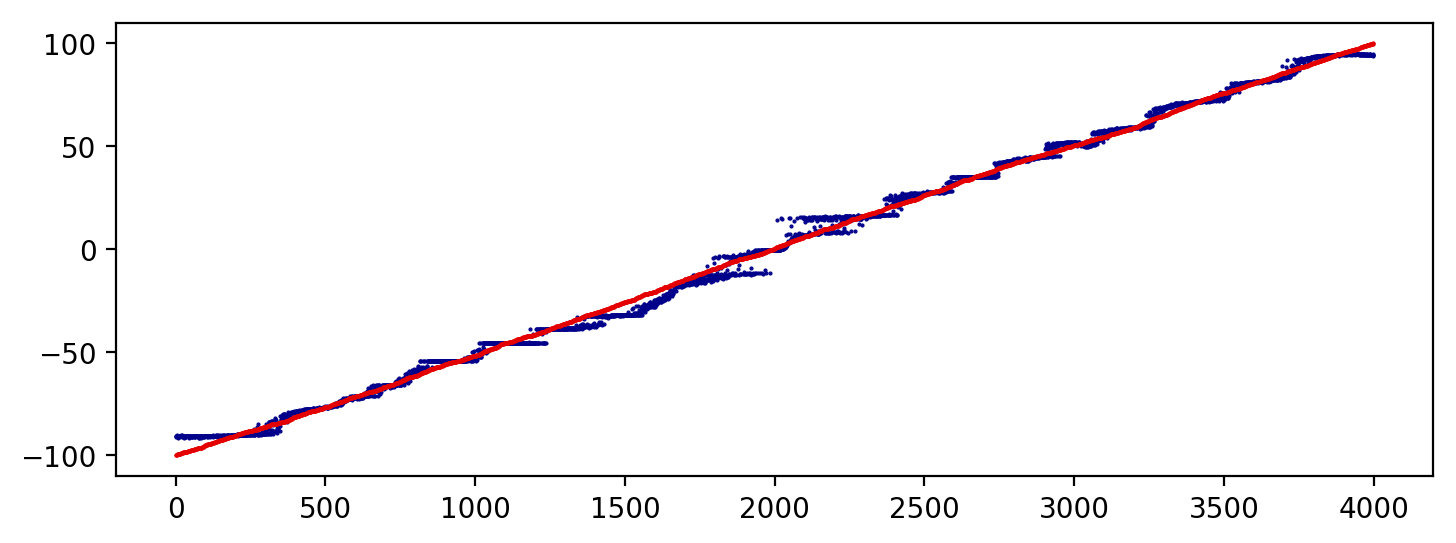

 epoch: 1499 testing_cost: 0.0009994991

In [11]:
with tf.Session() as session:

    saver.restore(session,'../../logs/517631/trained_model.ckpt-5999')


    training_writer = tf.summary.FileWriter(log_direc + '/training', session.graph)
    testing_writer = tf.summary.FileWriter(log_direc + '/testing', session.graph)
    model_save_location = log_direc + '/trained_model.ckpt'


    for epoch in range(training_epochs):
        epoch = epoch + 0*training_epochs
        # Feed in the training data and do one stepf NN training
        session.run(optimizer,
                    feed_dict = {X: X_scaled_training, Y: Y_scaled_training, keep_prob : 0.50})

        training_feed = {X: X_scaled_training, Y: Y_scaled_training, keep_prob : 0.50}
        training_cost, training_summary = session.run([cost, summary],
                                                feed_dict = training_feed)

        testing_feed =  {X: X_scaled_testing, Y: Y_scaled_testing, keep_prob : 1.00}
        testing_cost, testing_summary = session.run([cost, summary],
                                                     feed_dict = testing_feed)
        sys.stdout.write('\r epoch: {:4.0f} testing_cost: {:2.10f}'.format(epoch, training_cost))
        
        training_writer.add_summary(training_summary, epoch)
        testing_writer.add_summary(testing_summary, epoch)
        testing_writer.flush()
        training_writer.flush()
        
        if epoch % 50 == 0 or epoch == training_epochs:
            saver.save(session, model_save_location, epoch)
            prediction_scaled = session.run(prediction, feed_dict = {X: X_scaled_testing, keep_prob : 1.00})
            prediction_unscaled = Y_scaler.inverse_transform(prediction_scaled)
            sorting_idx = np.argsort(Y_testing.T[0])
        
            fig, ax = plt.subplots(figsize = (8.5, 3), dpi = 100)
            
            ax.plot(prediction_unscaled.T[0][sorting_idx], linestyle = 'none', marker = '.', markersize = 1, color = 'darkblue')
            ax.plot(Y_testing.T[0][sorting_idx], linestyle = 'none', marker = '.', markersize = 1, alpha = 0.75, color = '#E50000')
            plt.show()
            
    saver.save(session, model_save_location, epoch)

In [12]:
print(sum((Y_scaled_testing.T[0] - prediction_scaled.T[0])**2))
print(np.std(abs(Y_testing.T[0] - prediction_unscaled.T[0])))

0.927080145595093
1.9592909644447047


In [13]:
#import data
data_df = pd.read_csv('../../data/wrapped_20000_gaussian_spikes_twentyfive_percent_B.bz2', compression = 'bz2')

# split random 80% / 20%
training_data_df = data_df.sample(frac = 0.8)
testing_data_df = data_df.loc[~data_df.index.isin(training_data_df.index)]

# separate input features from output
X_training = training_data_df.drop('tau', axis = 1).values
Y_training = training_data_df[['tau']].values

X_testing = testing_data_df.drop('tau', axis = 1).values
Y_testing = testing_data_df[['tau']].values

# scale data
X_scaled_training = X_scaler.transform(X_training)
Y_scaled_training = Y_scaler.transform(Y_training)

X_scaled_testing = X_scaler.transform(X_testing)
Y_scaled_testing = Y_scaler.transform(Y_testing)

INFO:tensorflow:Restoring parameters from ../../logs/659566/trained_model.ckpt-1499
 epoch: 1500 testing_cost: 0.0010374072

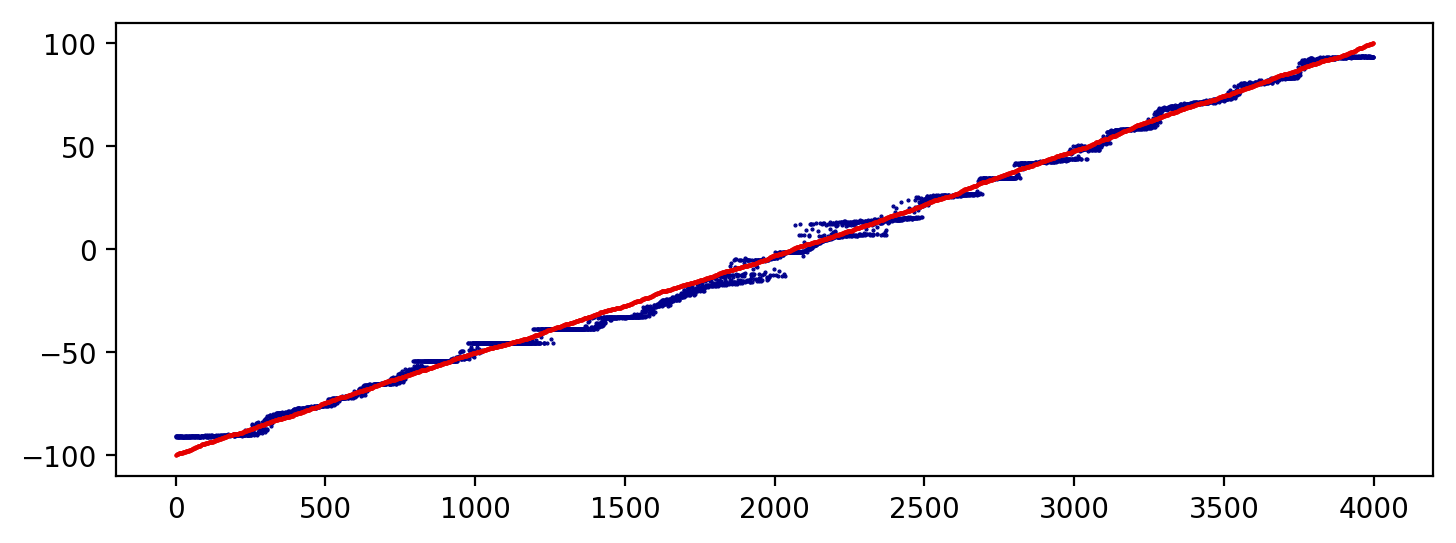

 epoch: 1550 testing_cost: 0.0009629790

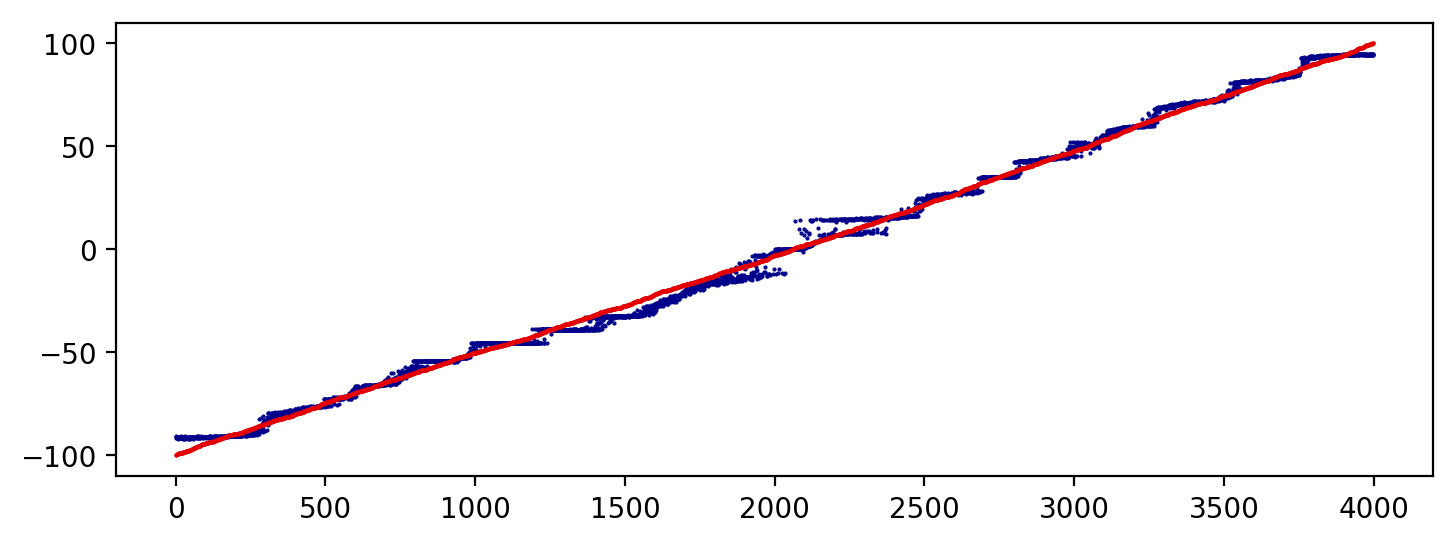

 epoch: 1600 testing_cost: 0.0013396690

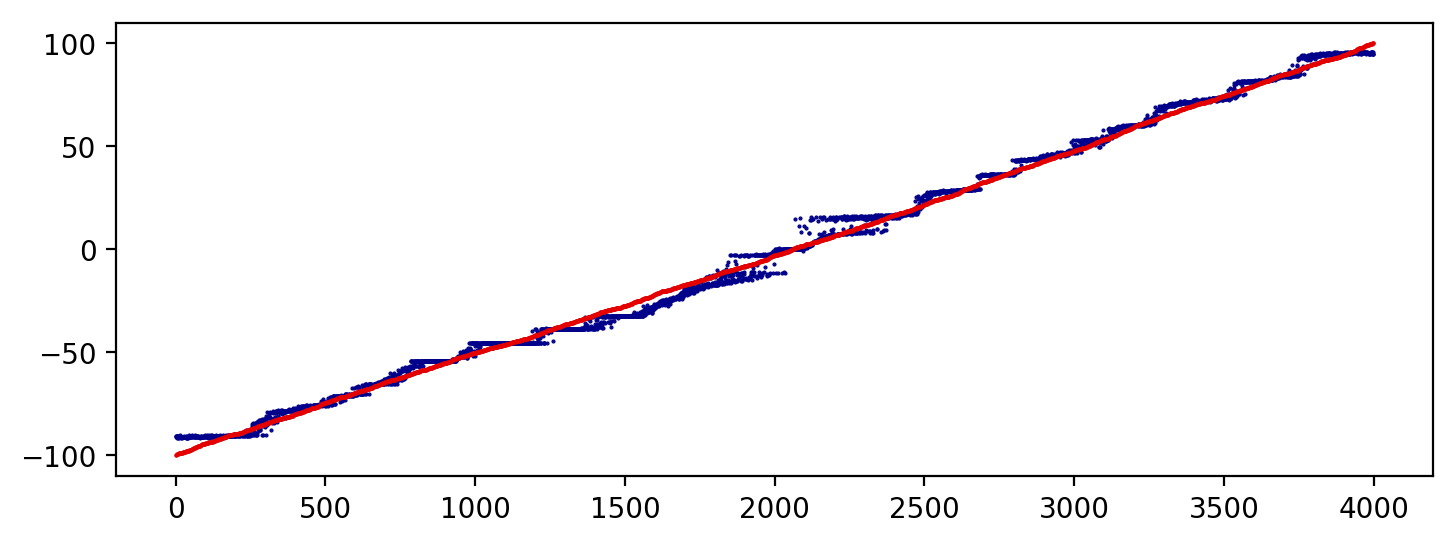

 epoch: 1650 testing_cost: 0.0008983148

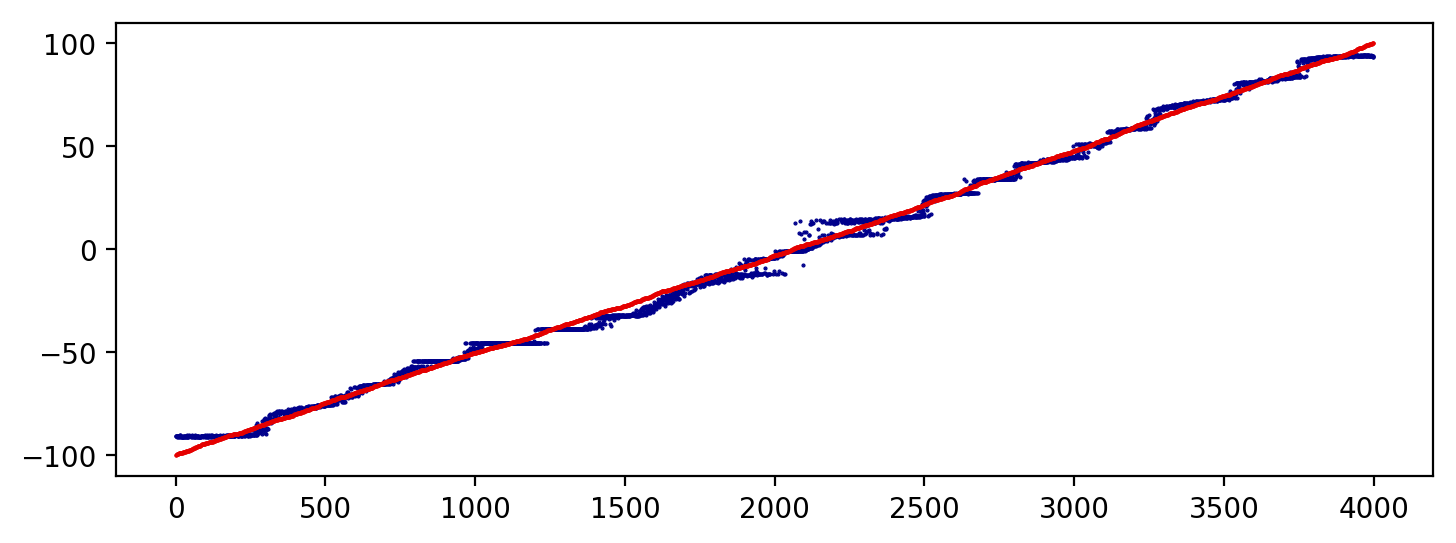

 epoch: 1700 testing_cost: 0.0009197723

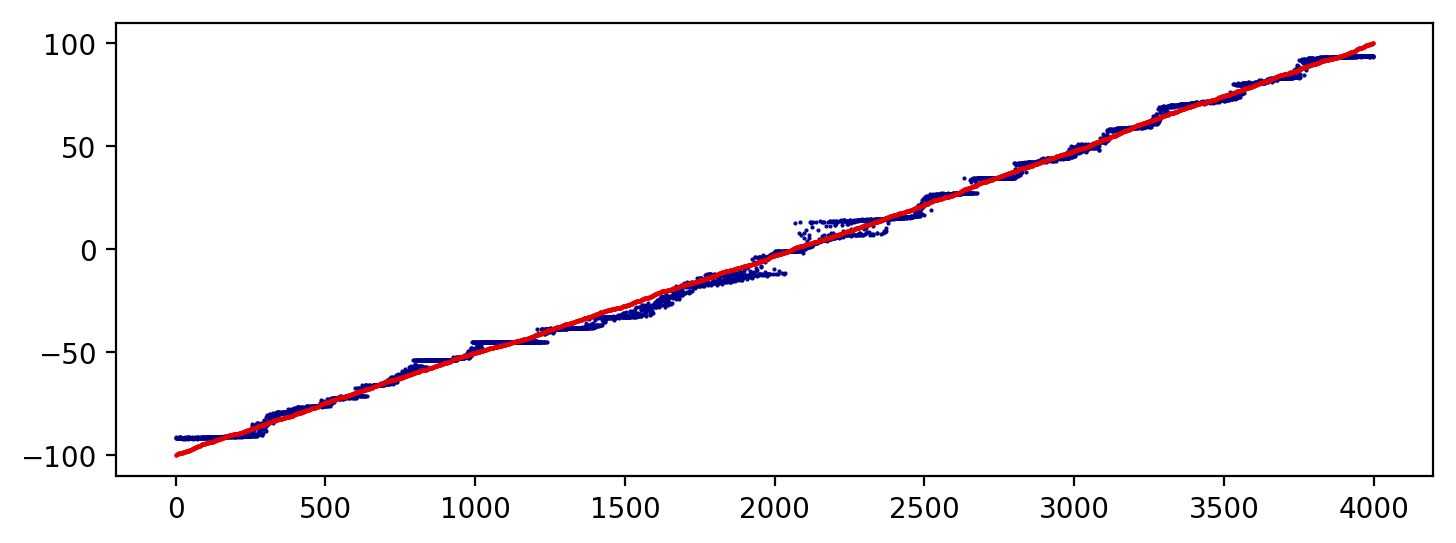

 epoch: 1750 testing_cost: 0.0010781436

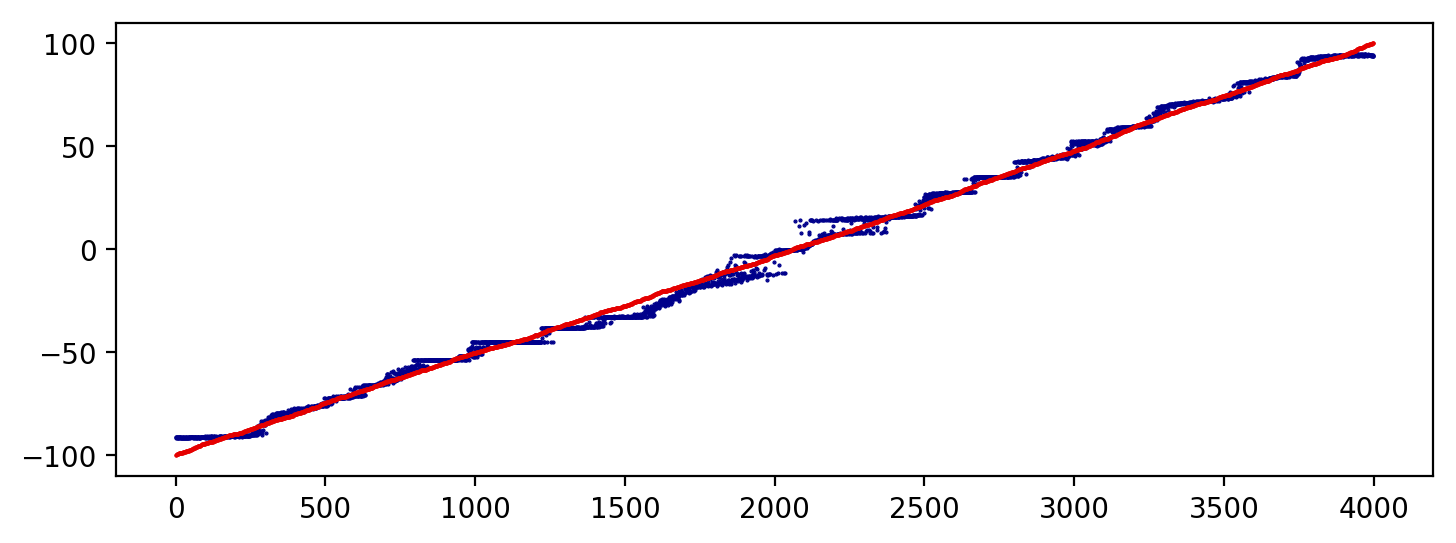

 epoch: 1800 testing_cost: 0.0010791728

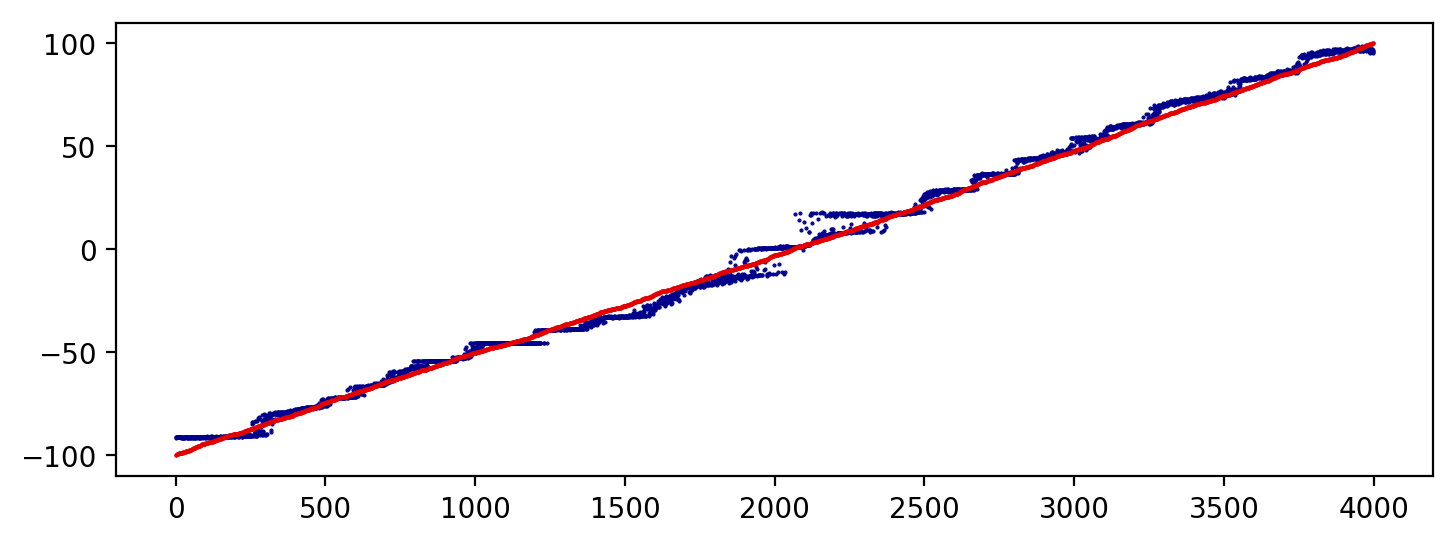

 epoch: 1850 testing_cost: 0.0010359113

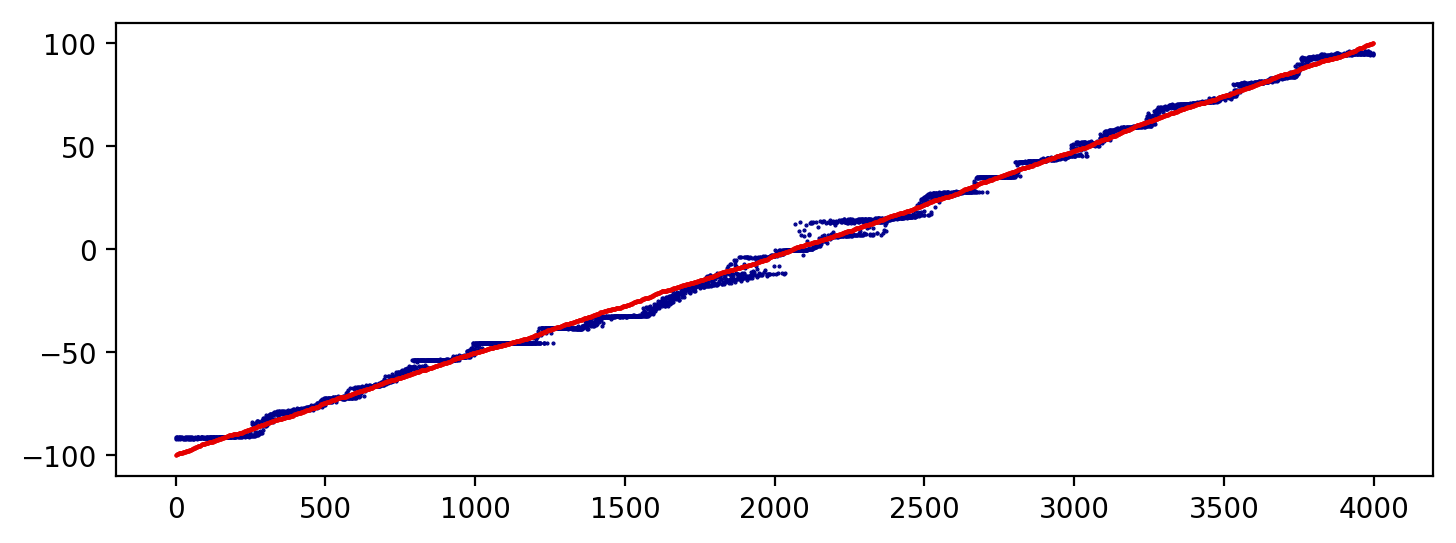

 epoch: 1900 testing_cost: 0.0008780317

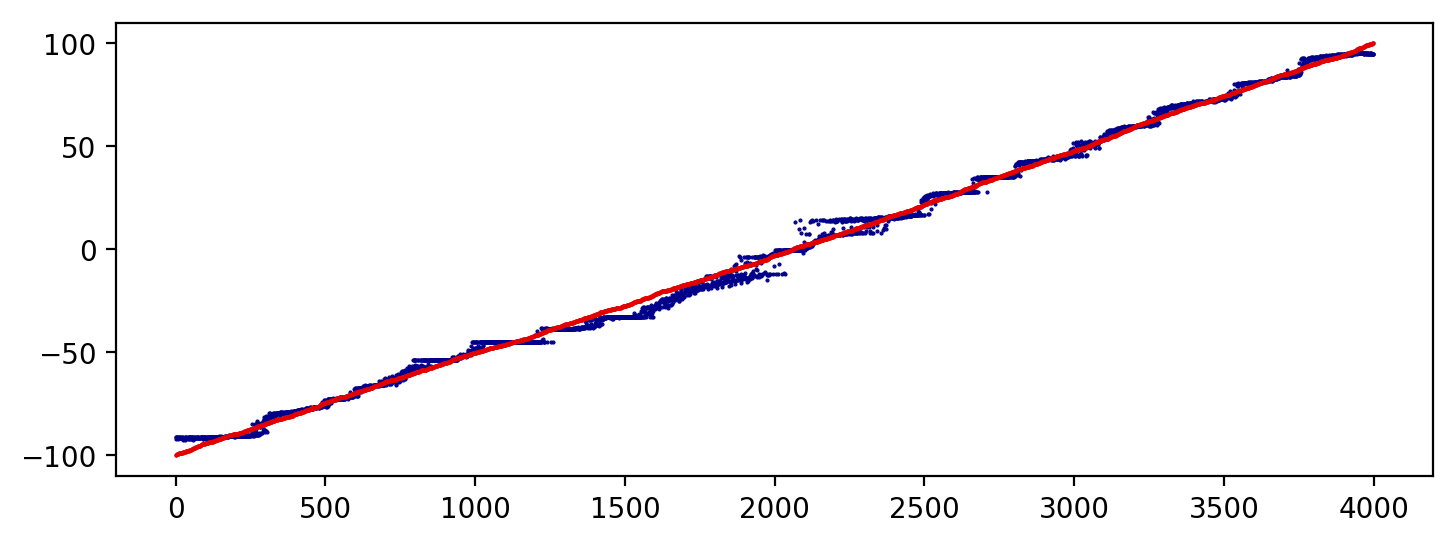

 epoch: 1950 testing_cost: 0.0011690509

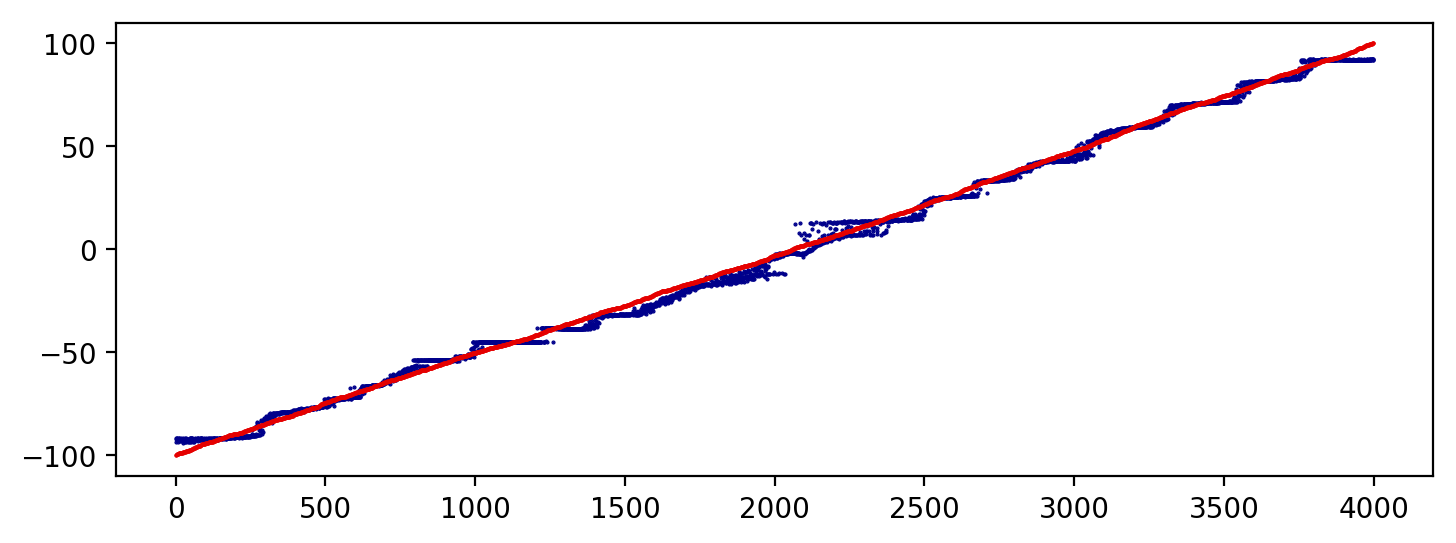

 epoch: 2000 testing_cost: 0.0009026385

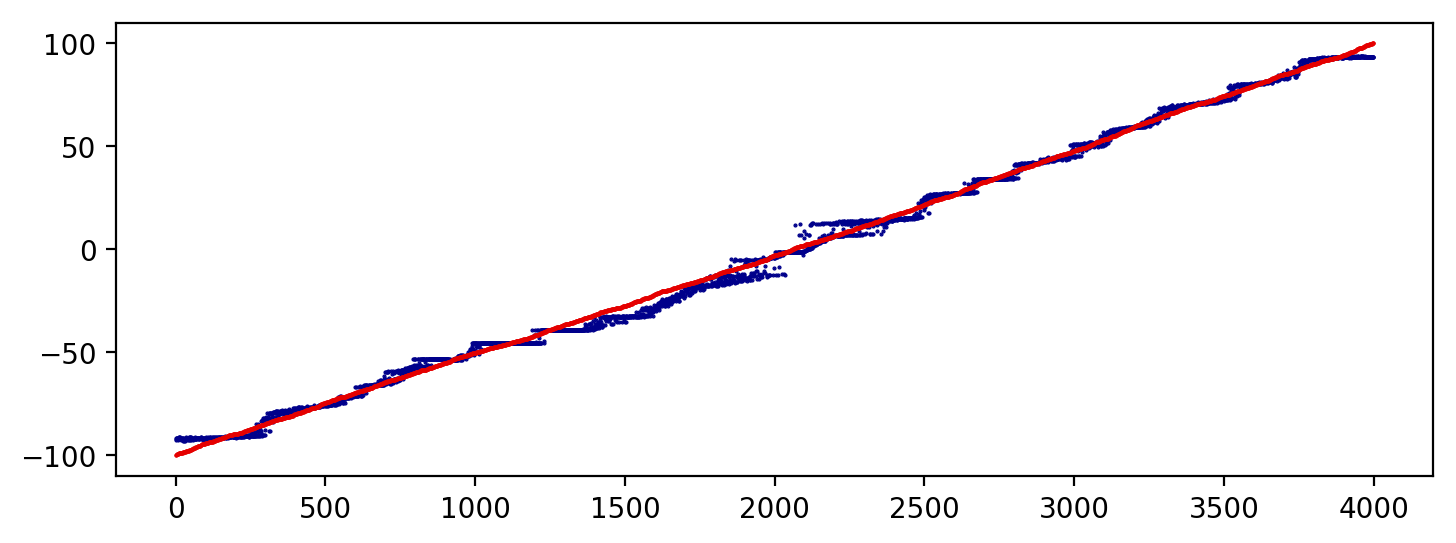

 epoch: 2050 testing_cost: 0.0019245268

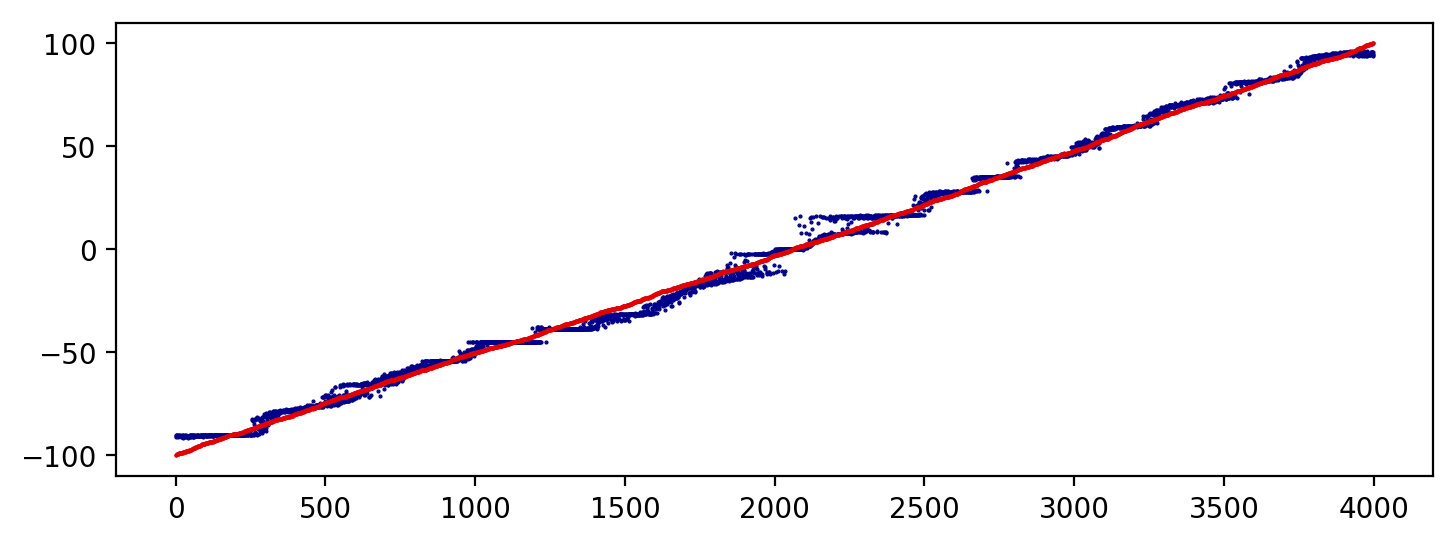

 epoch: 2100 testing_cost: 0.0012477757

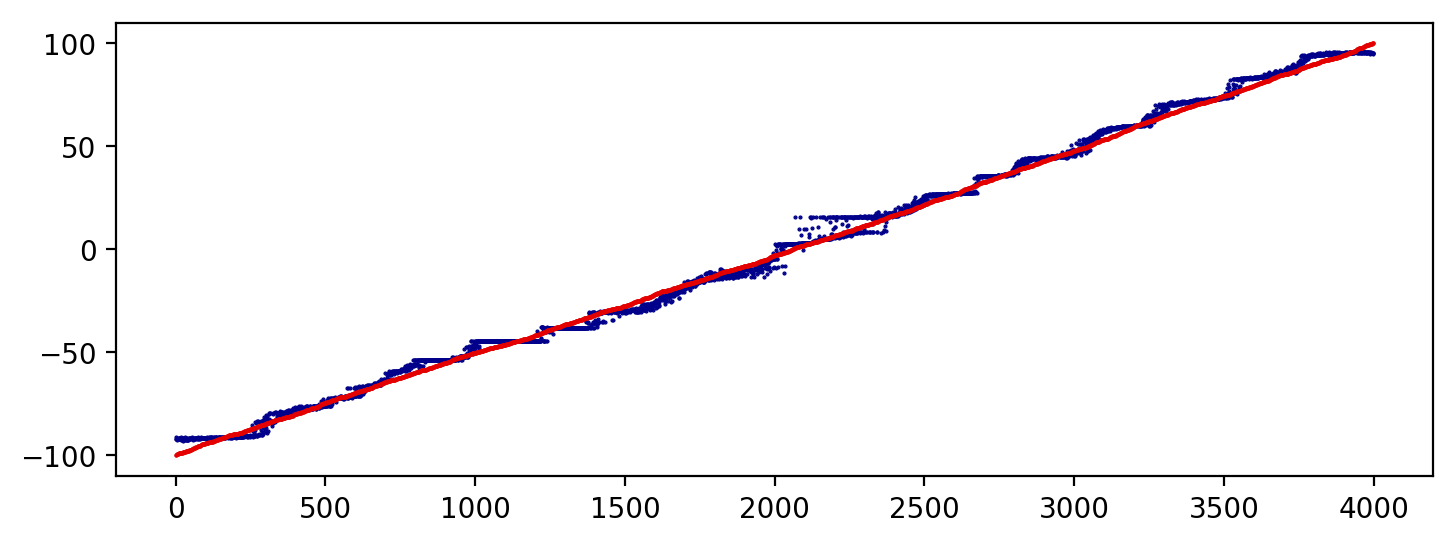

 epoch: 2150 testing_cost: 0.0011022091

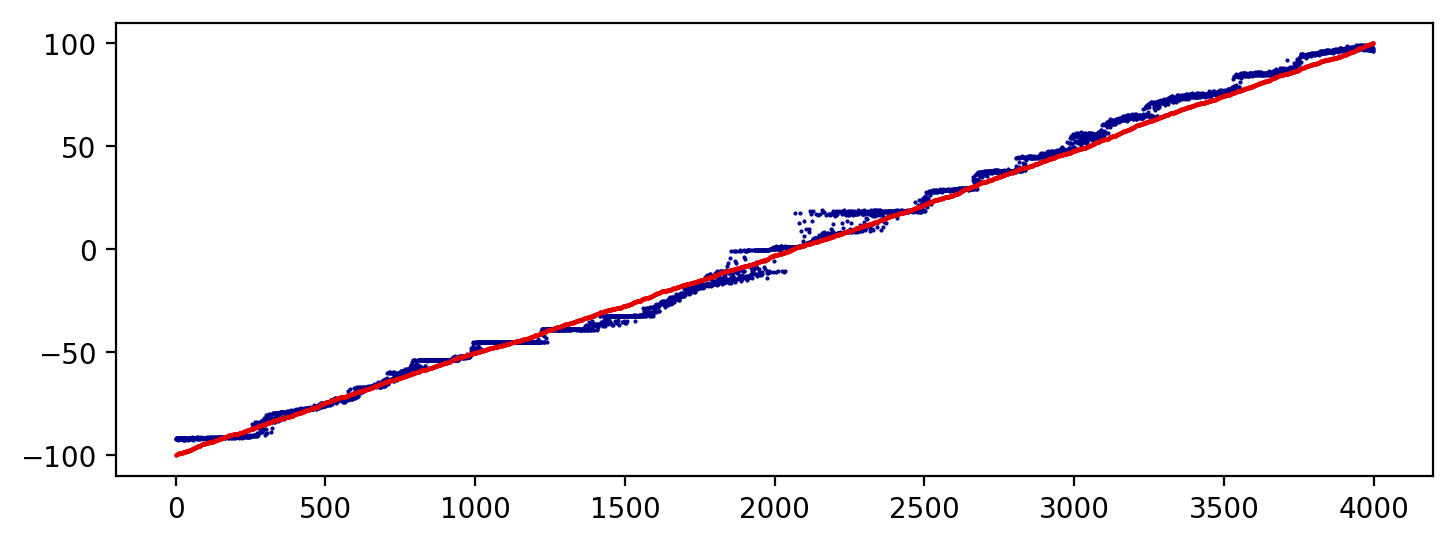

 epoch: 2200 testing_cost: 0.0007895968

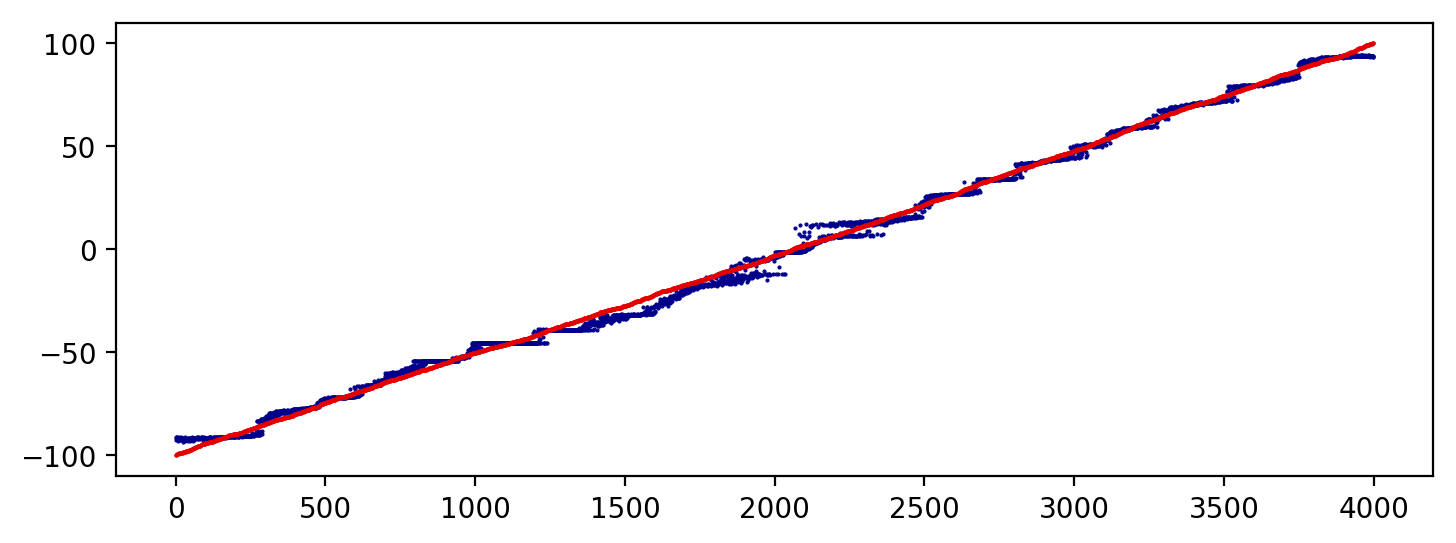

 epoch: 2250 testing_cost: 0.0006924178

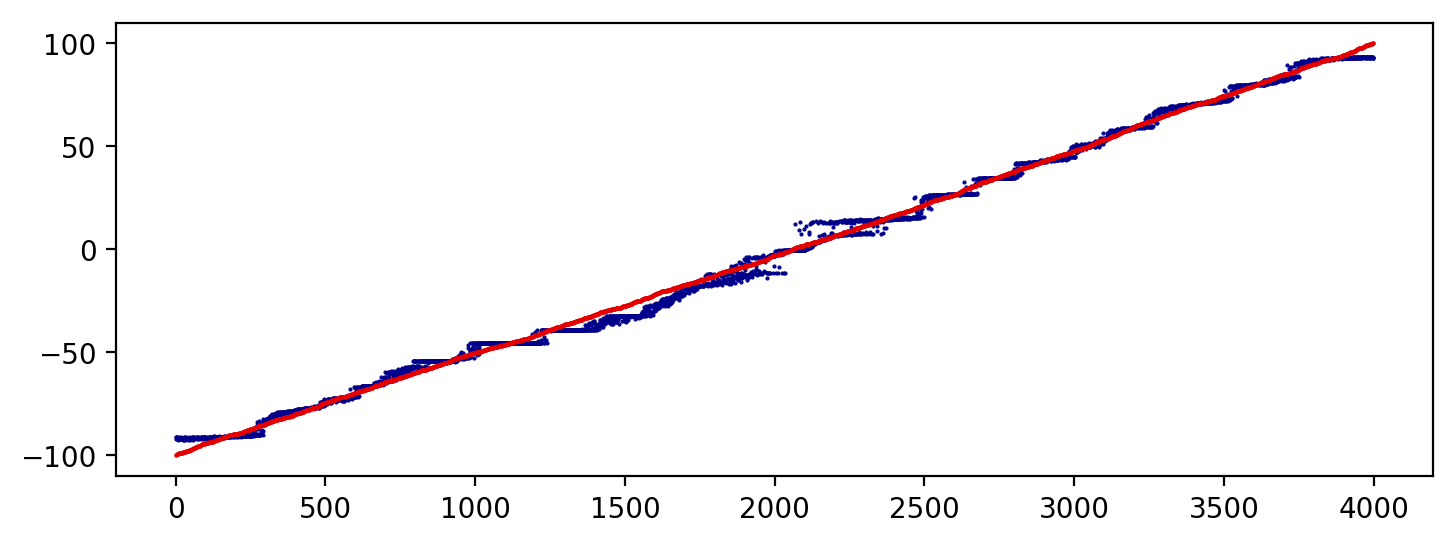

 epoch: 2300 testing_cost: 0.0013470579

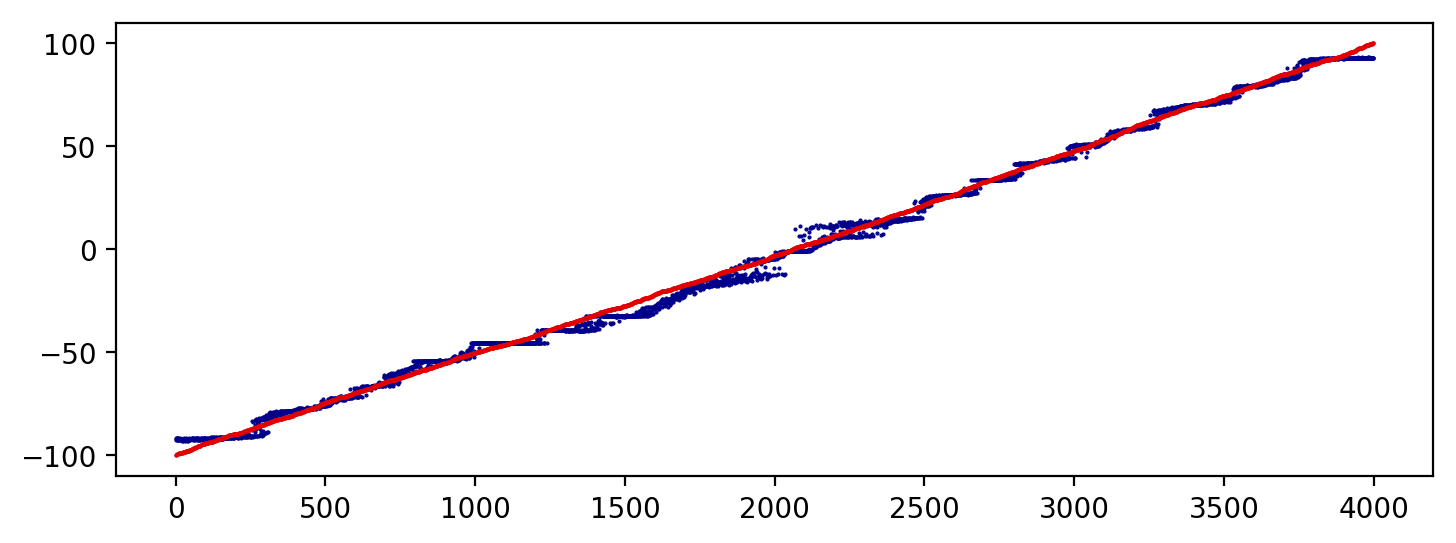

 epoch: 2350 testing_cost: 0.0007940354

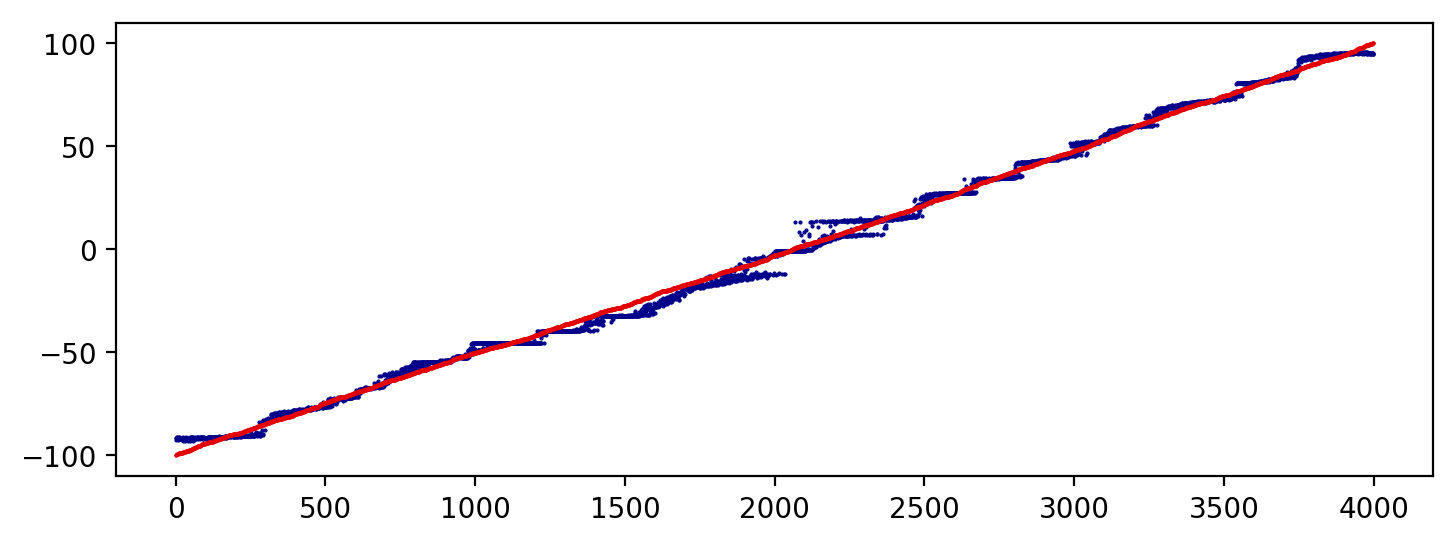

 epoch: 2400 testing_cost: 0.0015319805

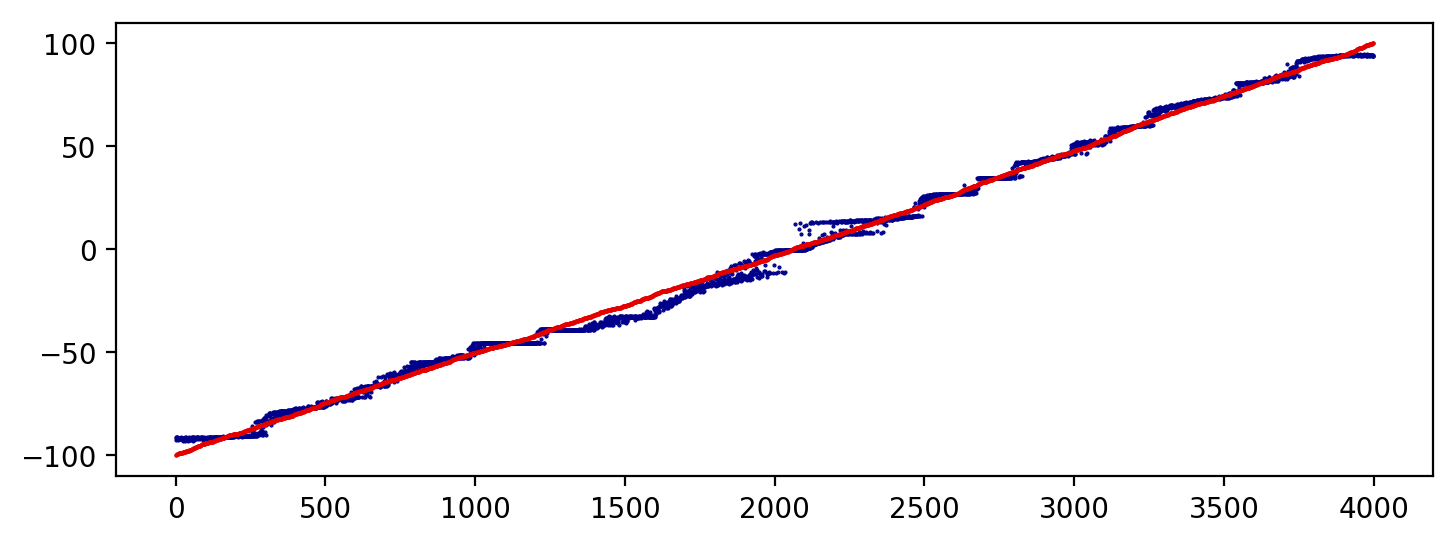

 epoch: 2450 testing_cost: 0.0013136654

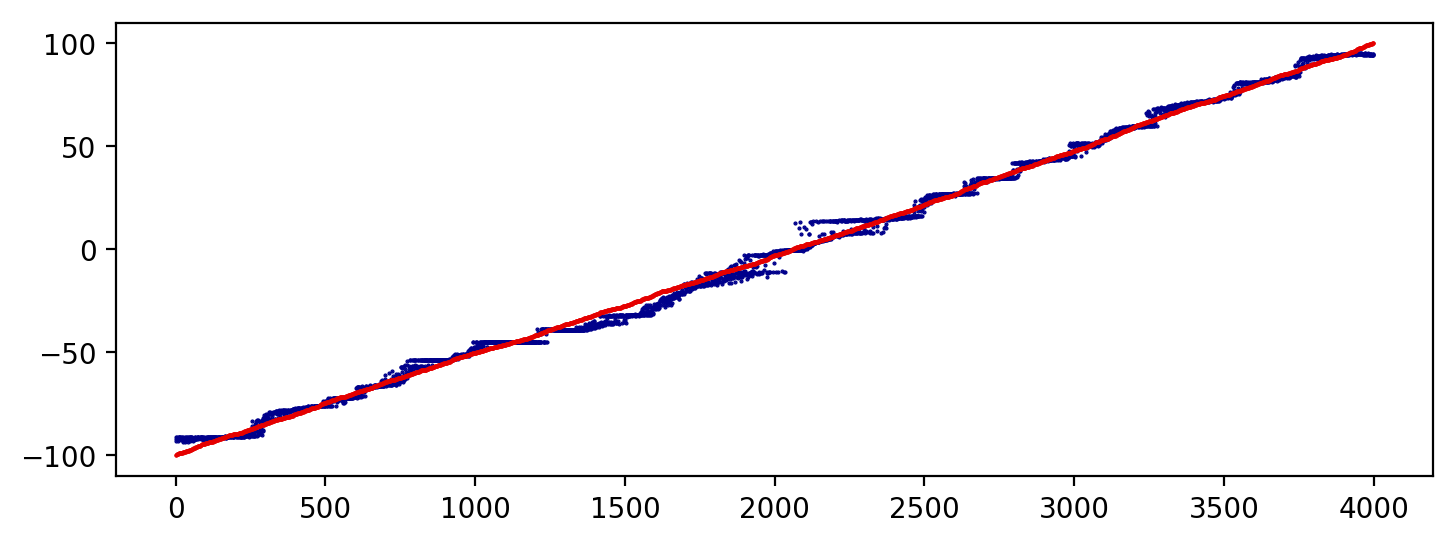

 epoch: 2500 testing_cost: 0.0011291446

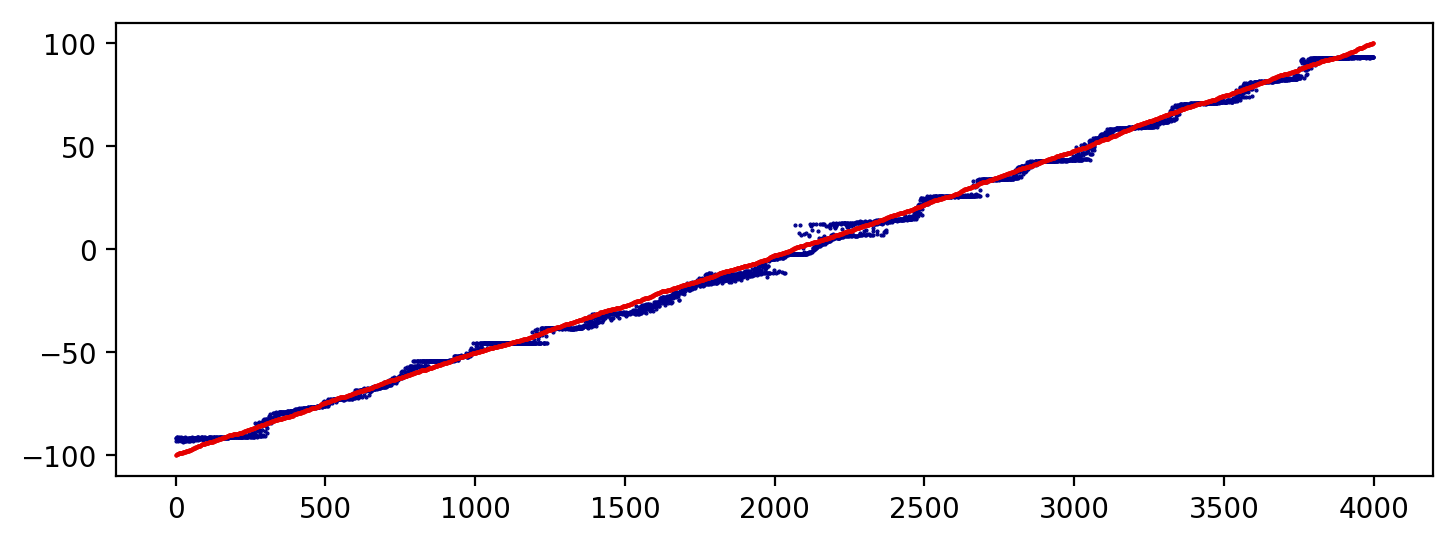

 epoch: 2550 testing_cost: 0.0008049544

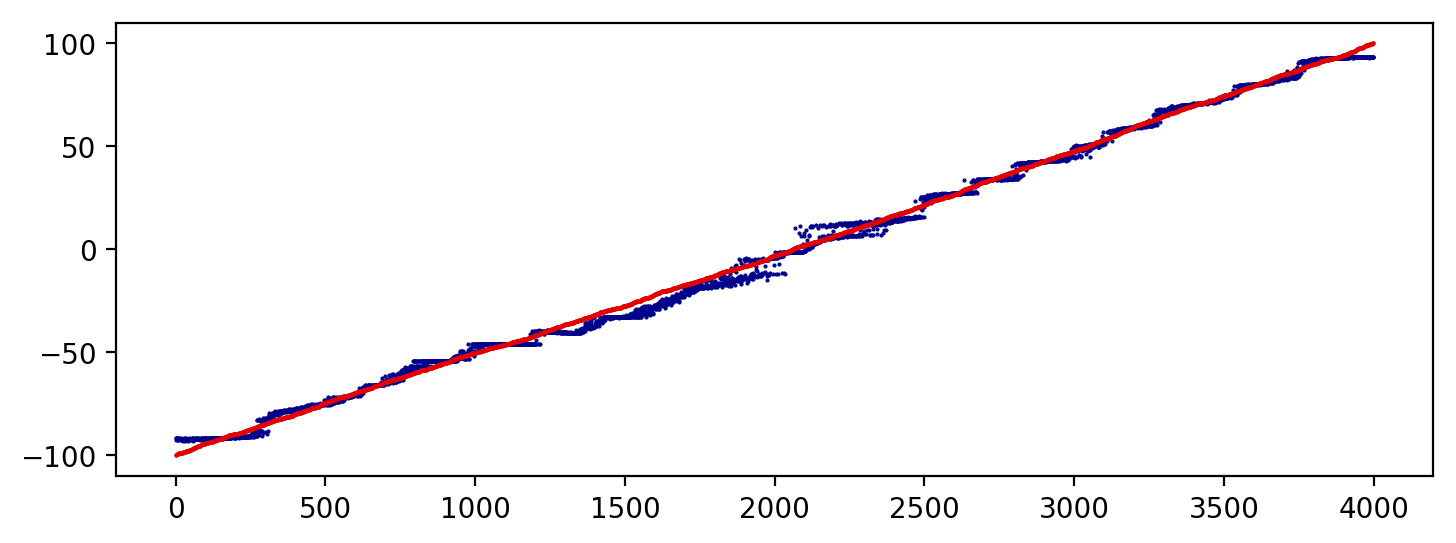

 epoch: 2600 testing_cost: 0.0007922764

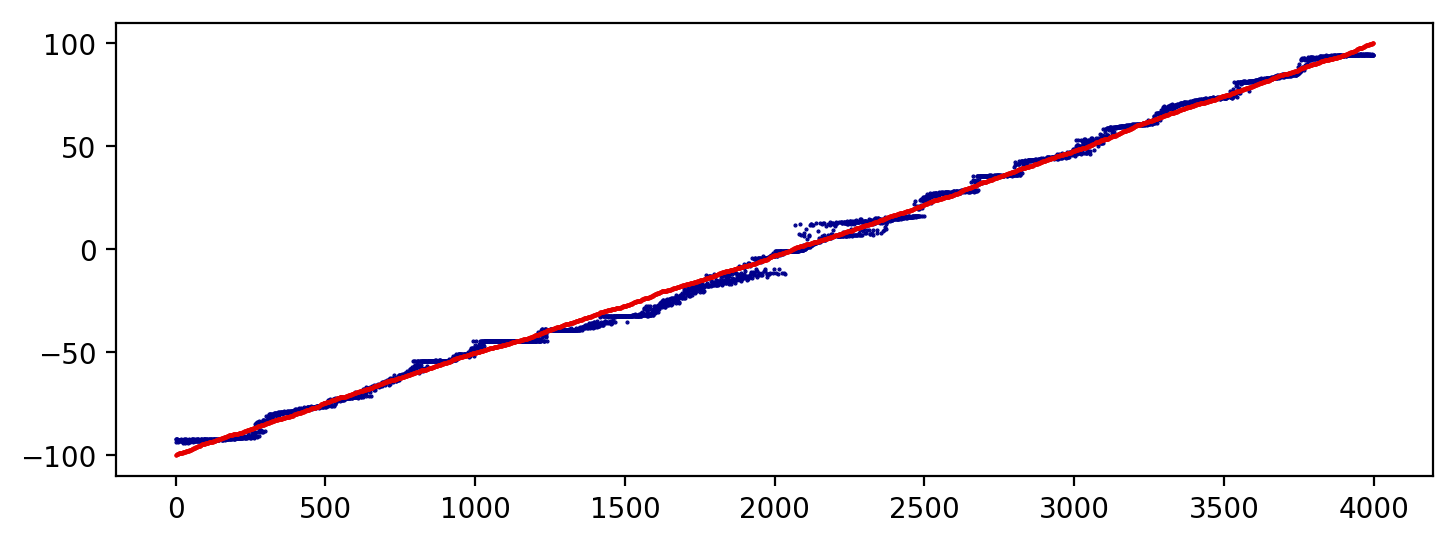

 epoch: 2650 testing_cost: 0.0008163542

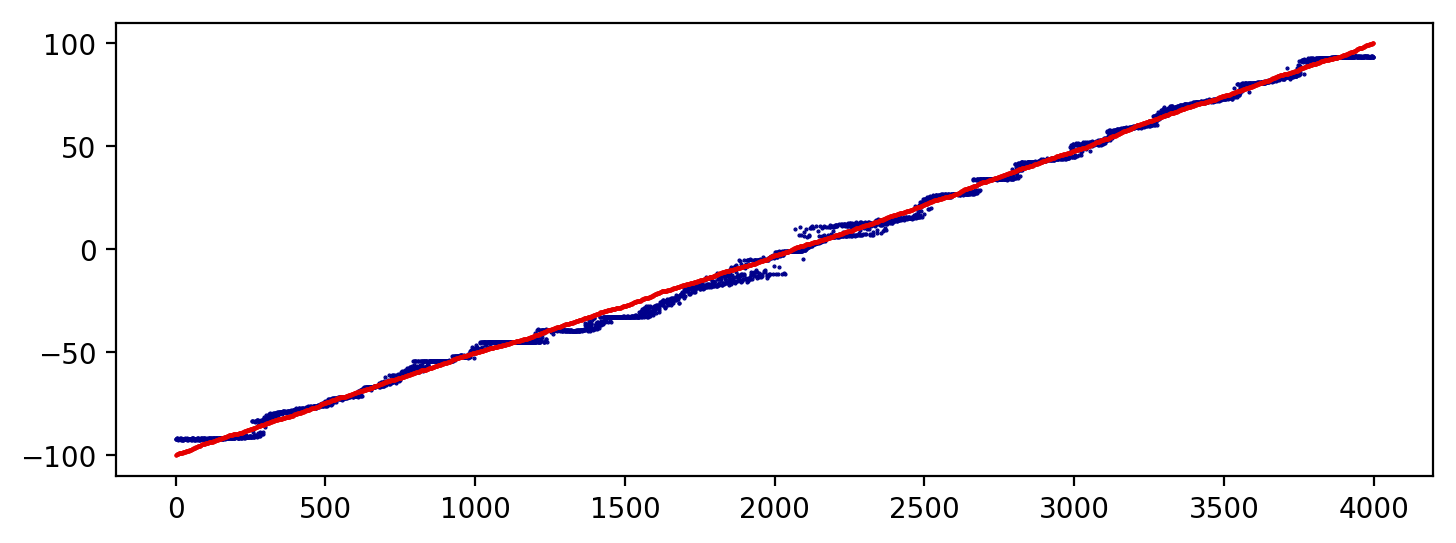

 epoch: 2700 testing_cost: 0.0013225066

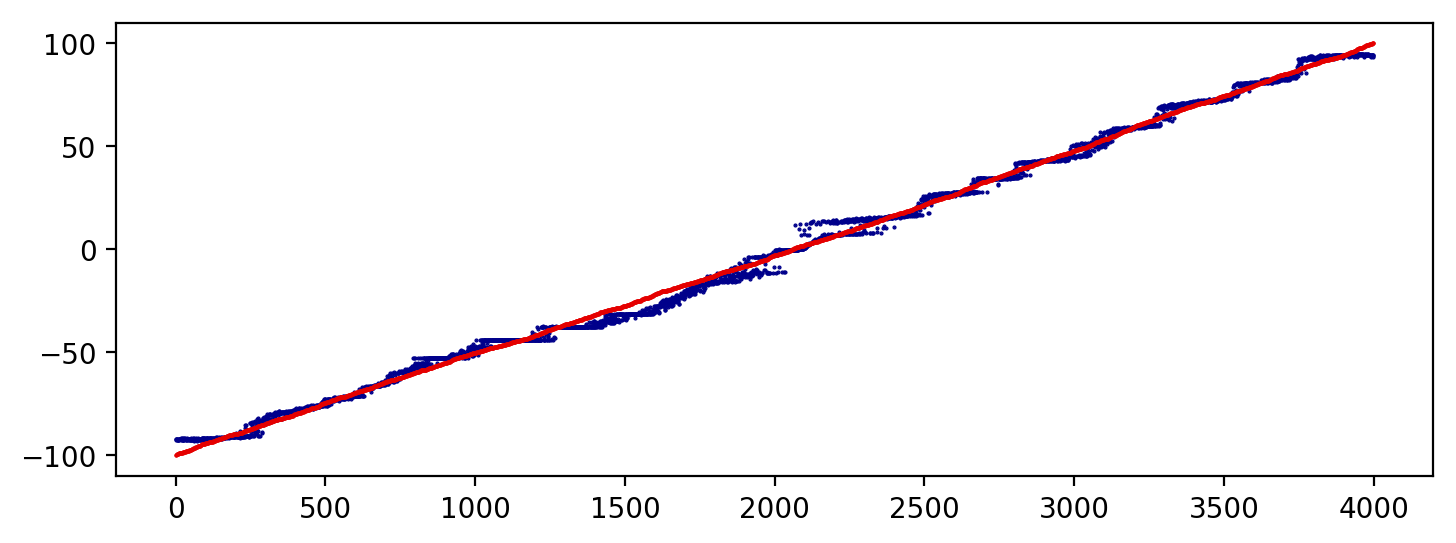

 epoch: 2750 testing_cost: 0.0012135134

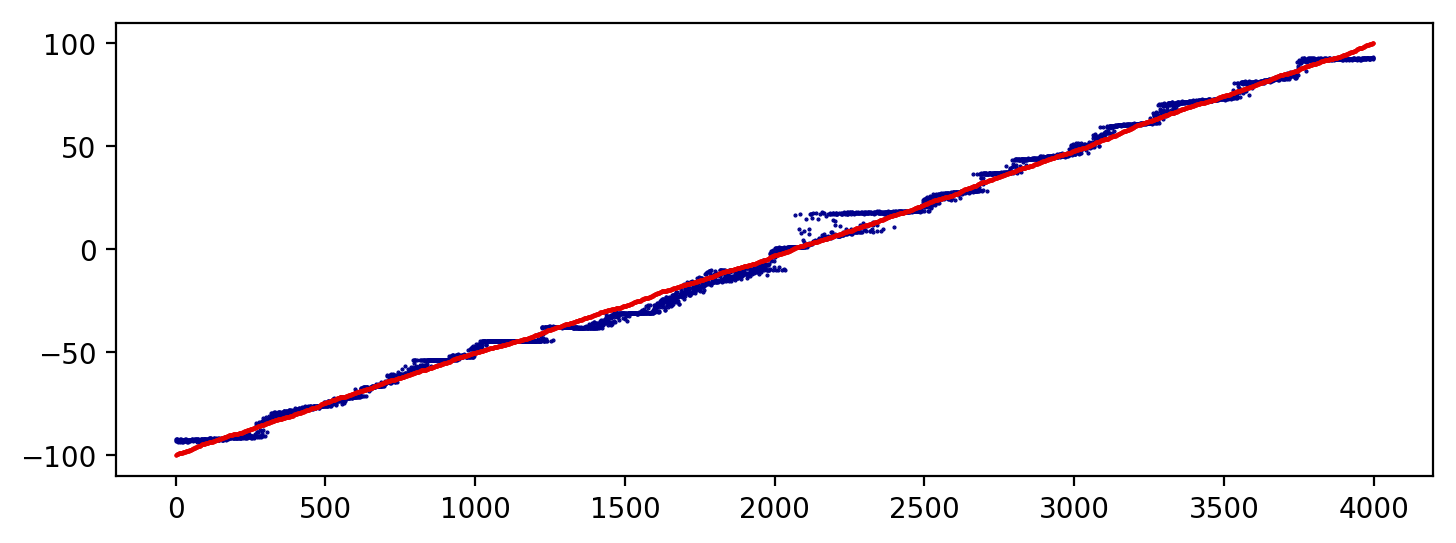

 epoch: 2800 testing_cost: 0.0017576398

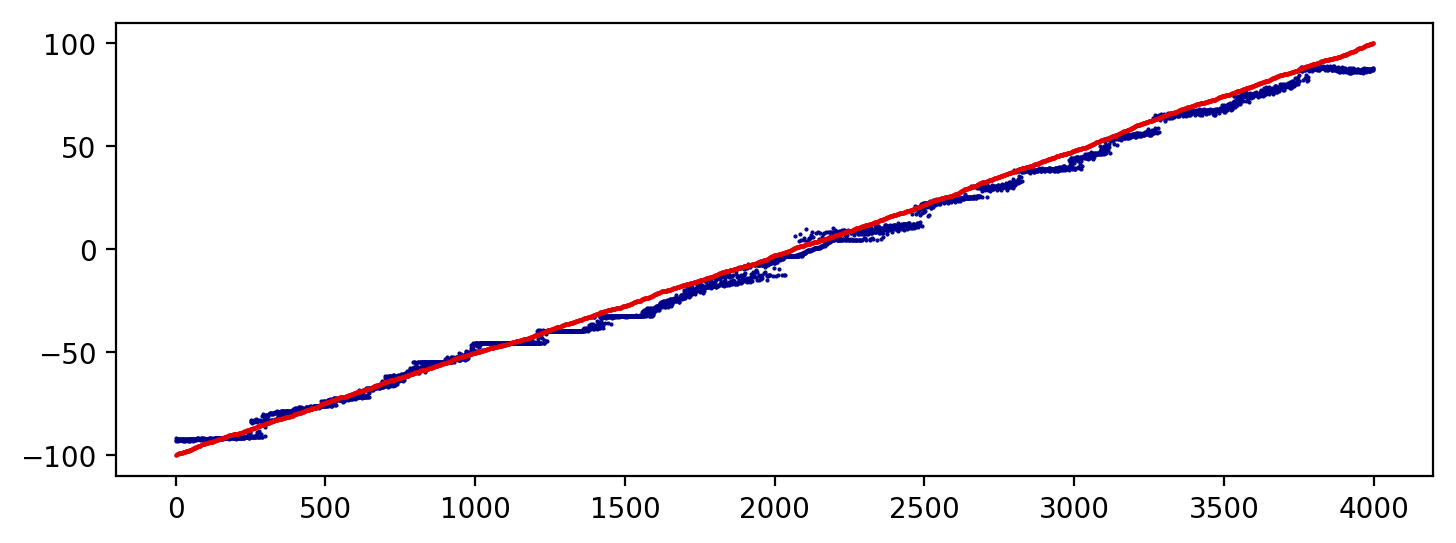

 epoch: 2850 testing_cost: 0.0024690726

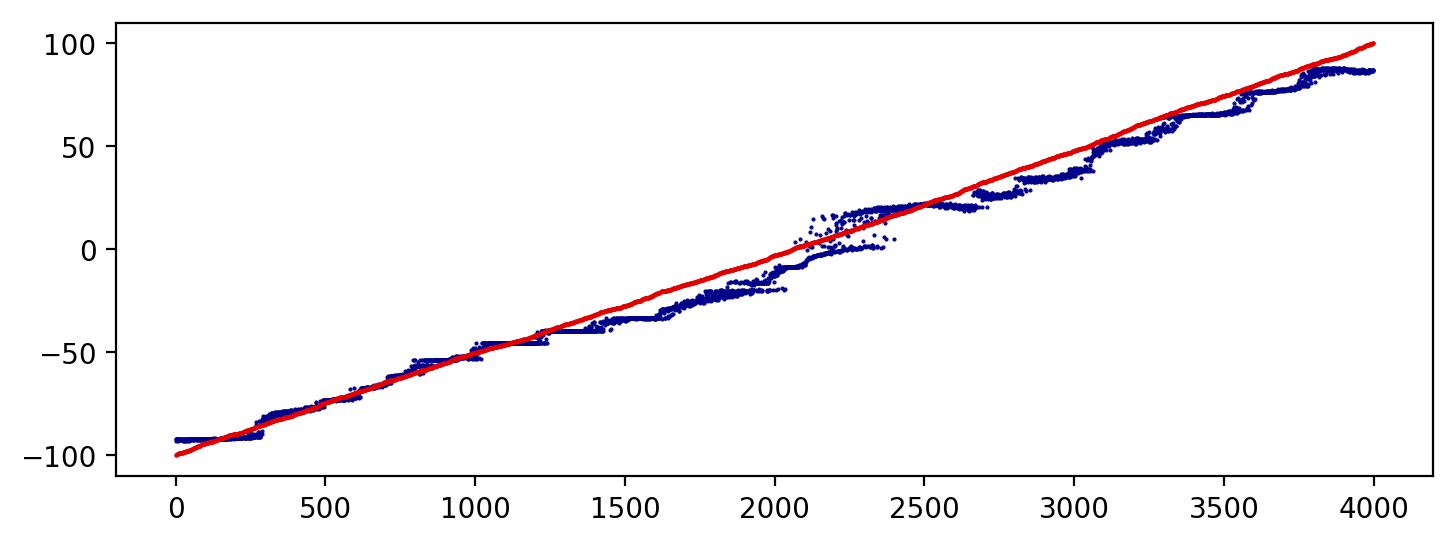

 epoch: 2900 testing_cost: 0.0013701806

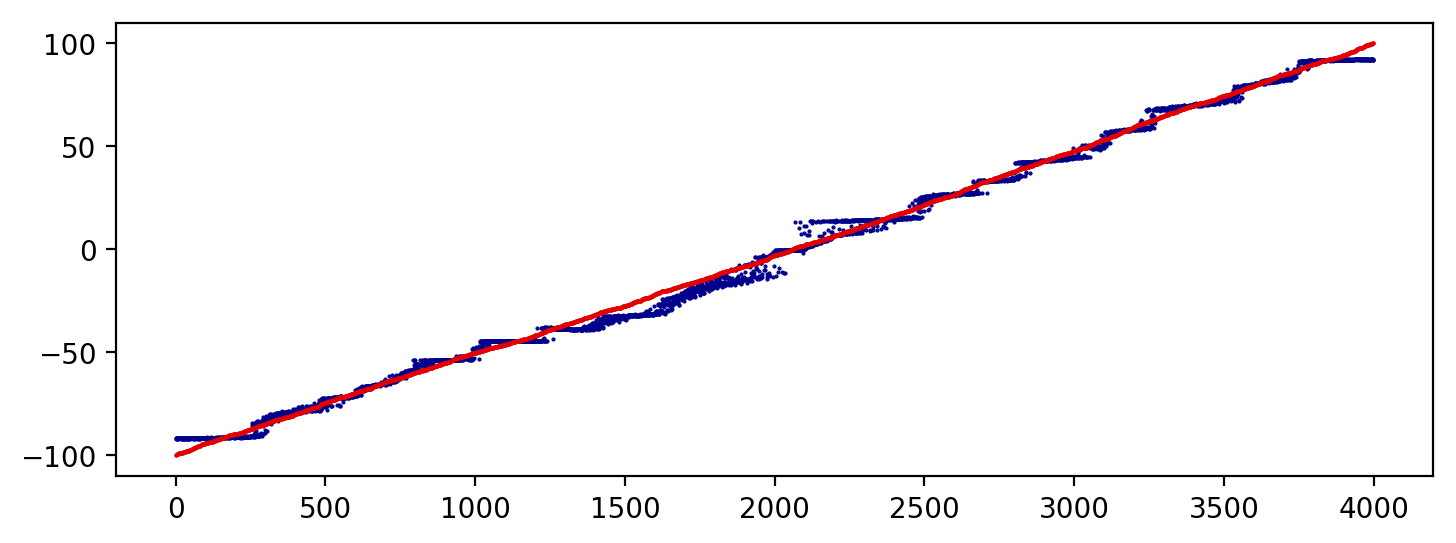

 epoch: 2950 testing_cost: 0.0010570184

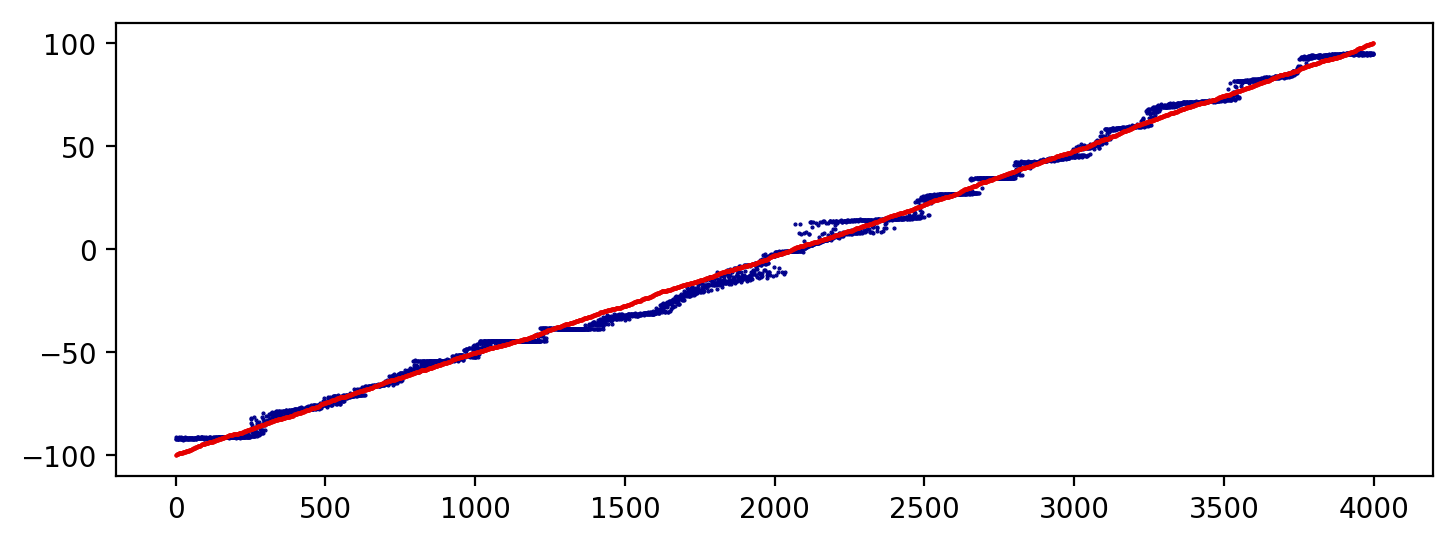

 epoch: 2999 testing_cost: 0.0010648483

In [14]:
with tf.Session() as session:

    saver.restore(session,model_save_location + '-1499')

    training_writer = tf.summary.FileWriter(log_direc + '/training', session.graph)
    testing_writer = tf.summary.FileWriter(log_direc + '/testing', session.graph)
    model_save_location = log_direc + '/trained_model.ckpt'


    for epoch in range(training_epochs):
        epoch = epoch + 1*training_epochs


        # Feed in the training data and do one stepf NN training
        session.run(optimizer,
                    feed_dict = {X: X_scaled_training, Y: Y_scaled_training, keep_prob : 0.50})

        training_feed = {X: X_scaled_training, Y: Y_scaled_training, keep_prob : 0.50}
        training_cost, training_summary = session.run([cost, summary],
                                                feed_dict = training_feed)

        testing_feed =  {X: X_scaled_testing, Y: Y_scaled_testing, keep_prob : 1.00}
        testing_cost, testing_summary = session.run([cost, summary],
                                                     feed_dict = testing_feed)
        sys.stdout.write('\r epoch: {:4.0f} testing_cost: {:2.10f}'.format(epoch, training_cost))
        
        training_writer.add_summary(training_summary, epoch)
        testing_writer.add_summary(testing_summary, epoch)
        testing_writer.flush()
        training_writer.flush()
        
        if epoch % 50 == 0 or epoch == training_epochs:
            saver.save(session, model_save_location, epoch)
            prediction_scaled = session.run(prediction, feed_dict = {X: X_scaled_testing, keep_prob : 1.00})
            prediction_unscaled = Y_scaler.inverse_transform(prediction_scaled)
            sorting_idx = np.argsort(Y_testing.T[0])
        
            fig, ax = plt.subplots(figsize = (8.5, 3), dpi = 100)
            
            ax.plot(prediction_unscaled.T[0][sorting_idx], linestyle = 'none', marker = '.', markersize = 1, color = 'darkblue')
            ax.plot(Y_testing.T[0][sorting_idx], linestyle = 'none', marker = '.', markersize = 1, alpha = 0.75, color = '#E50000')
            plt.show()
            
    saver.save(session, model_save_location, epoch)

In [15]:
print(sum((Y_scaled_testing.T[0] - prediction_scaled.T[0])**2))
print(np.std(abs(Y_testing.T[0] - prediction_unscaled.T[0])))

1.040194315149206
2.032850021787169


In [16]:
#import data
data_df = pd.read_csv('../../data/wrapped_20000_gaussian_spikes_twentyfive_percent_C.bz2', compression = 'bz2')

# split random 80% / 20%
training_data_df = data_df.sample(frac = 0.8)
testing_data_df = data_df.loc[~data_df.index.isin(training_data_df.index)]

# separate input features from output
X_training = training_data_df.drop('tau', axis = 1).values
Y_training = training_data_df[['tau']].values

X_testing = testing_data_df.drop('tau', axis = 1).values
Y_testing = testing_data_df[['tau']].values

# scale data
X_scaled_training = X_scaler.transform(X_training)
Y_scaled_training = Y_scaler.transform(Y_training)

X_scaled_testing = X_scaler.transform(X_testing)
Y_scaled_testing = Y_scaler.transform(Y_testing)

INFO:tensorflow:Restoring parameters from ../../logs/659566/trained_model.ckpt-2999
 epoch: 3000 testing_cost: 0.0009451085

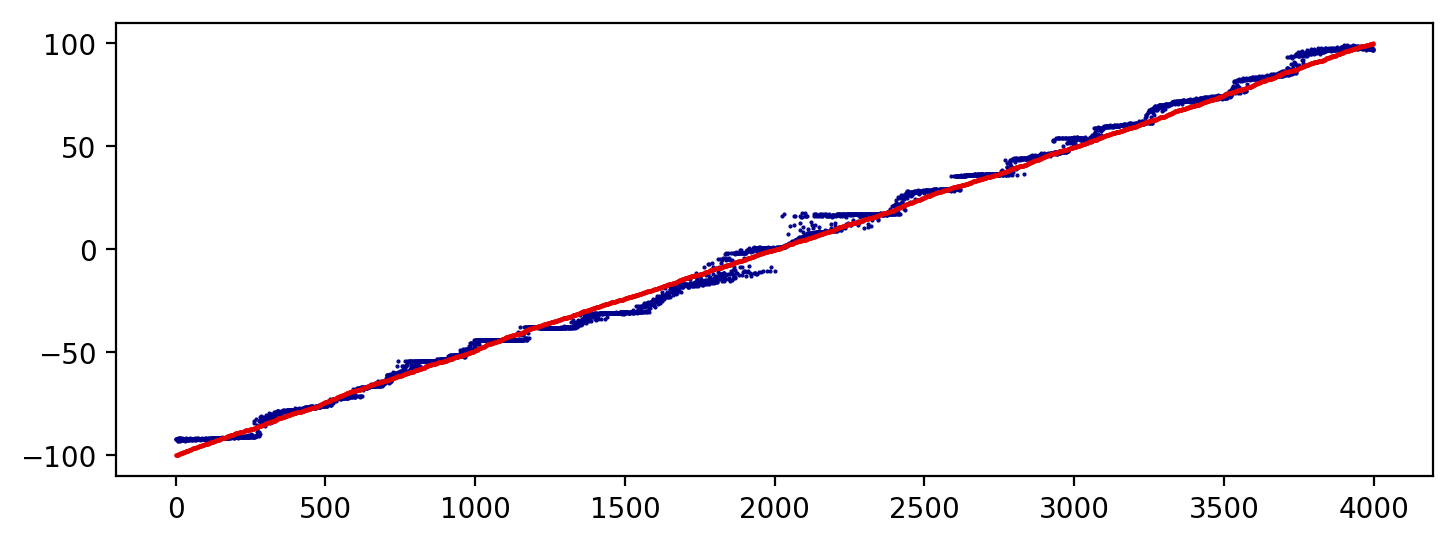

 epoch: 3050 testing_cost: 0.0009720570

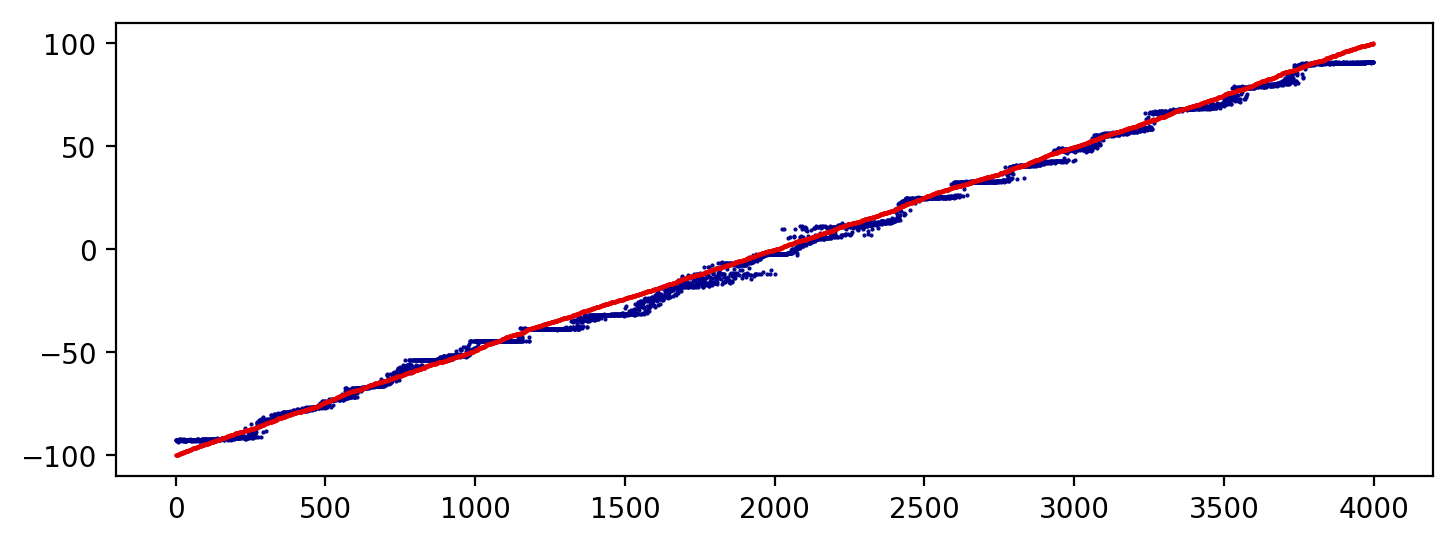

 epoch: 3100 testing_cost: 0.0010527438

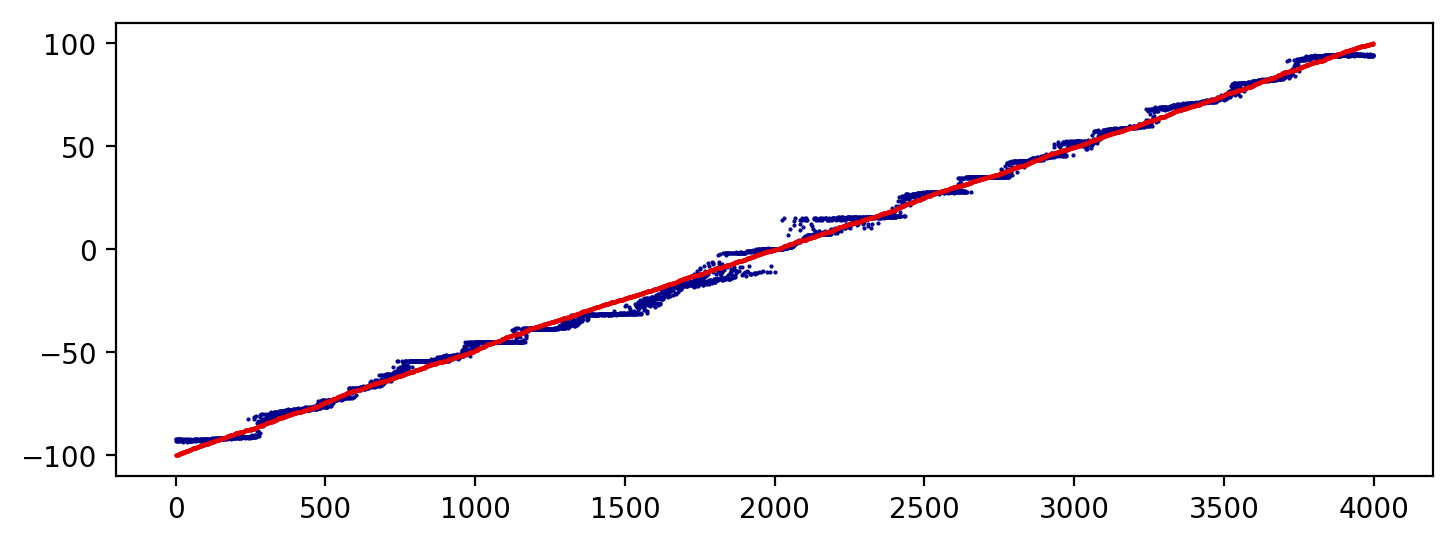

 epoch: 3150 testing_cost: 0.0008845403

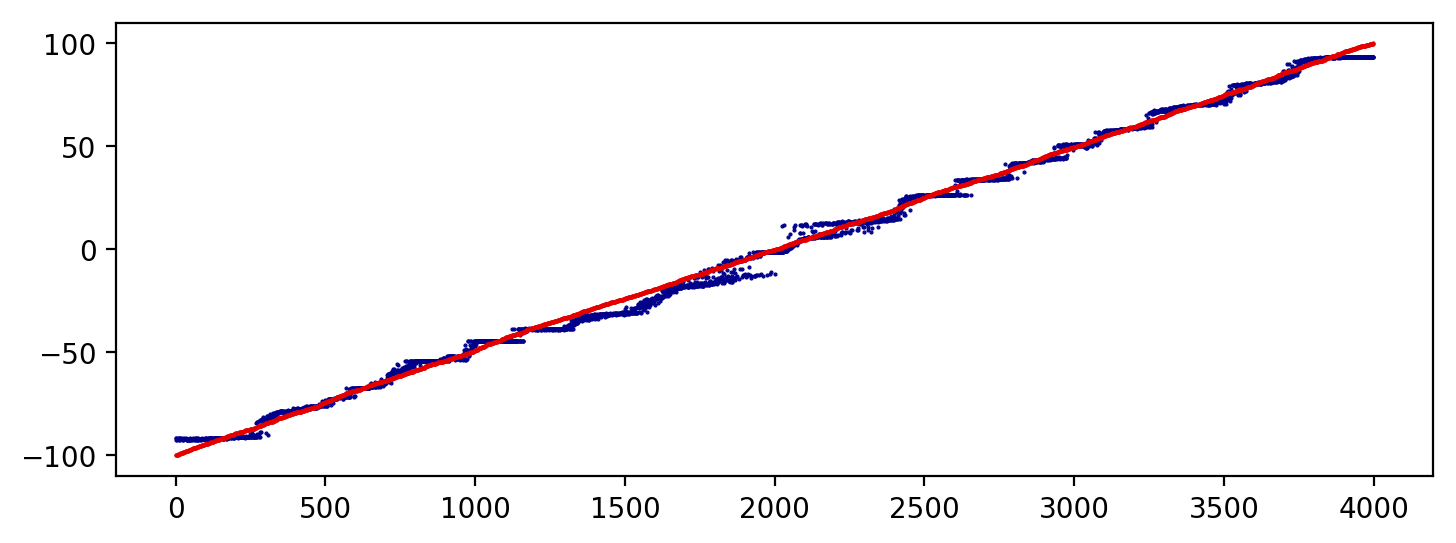

 epoch: 3200 testing_cost: 0.0009804361

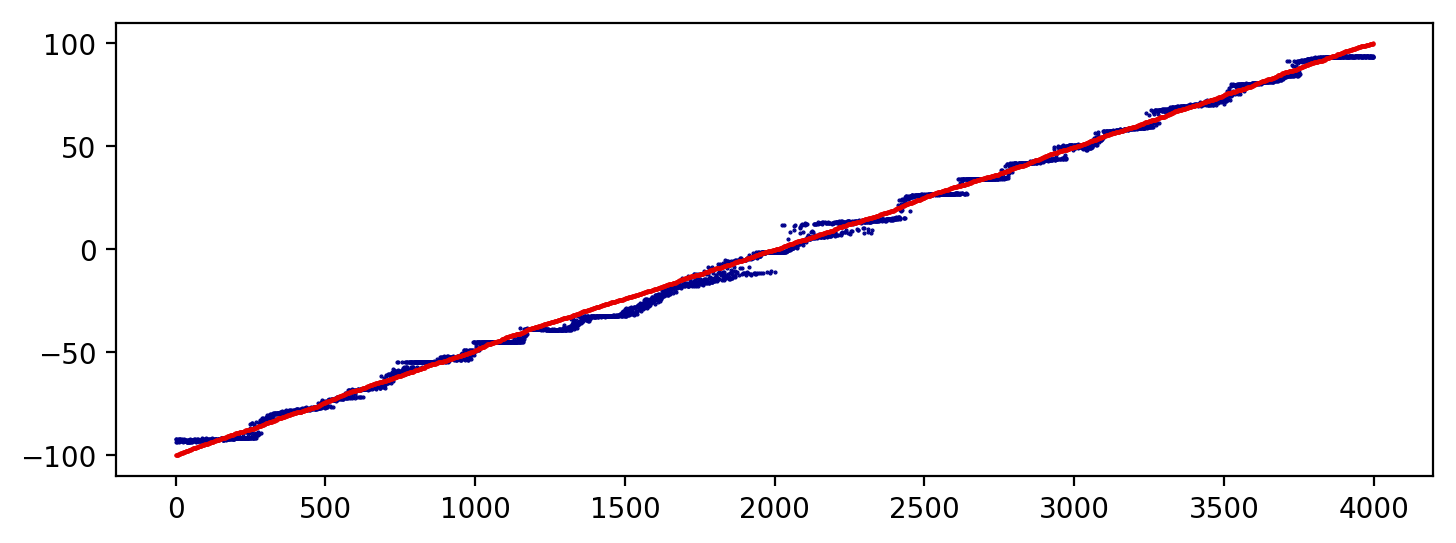

 epoch: 3250 testing_cost: 0.0010818946

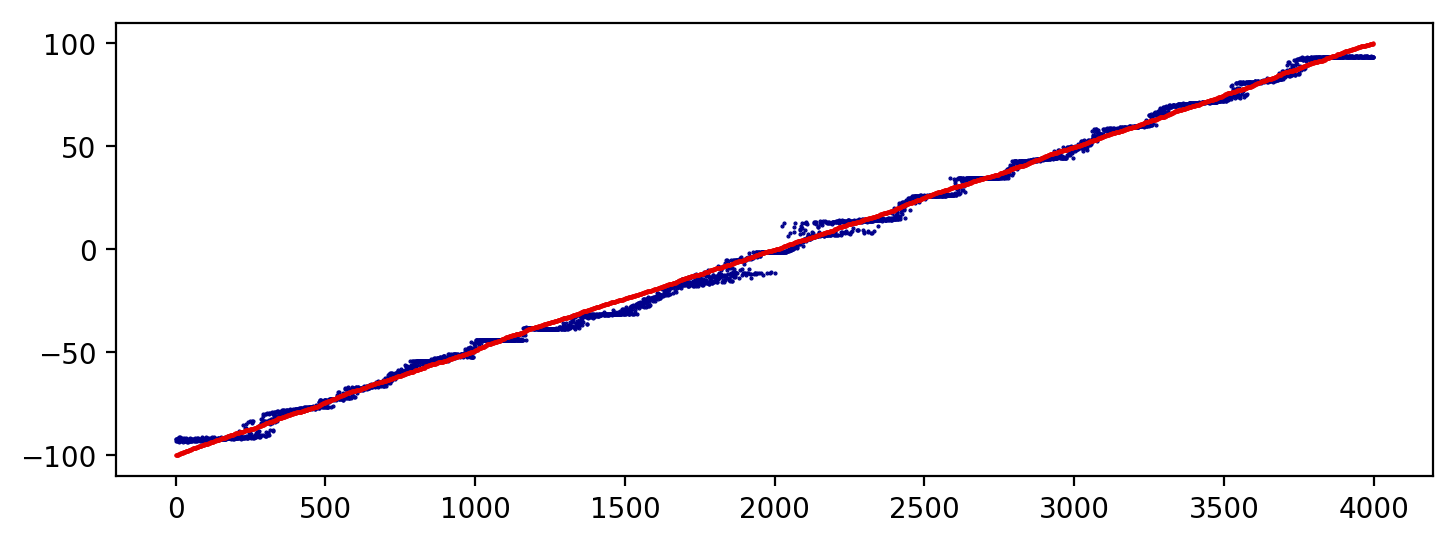

 epoch: 3300 testing_cost: 0.0020858150

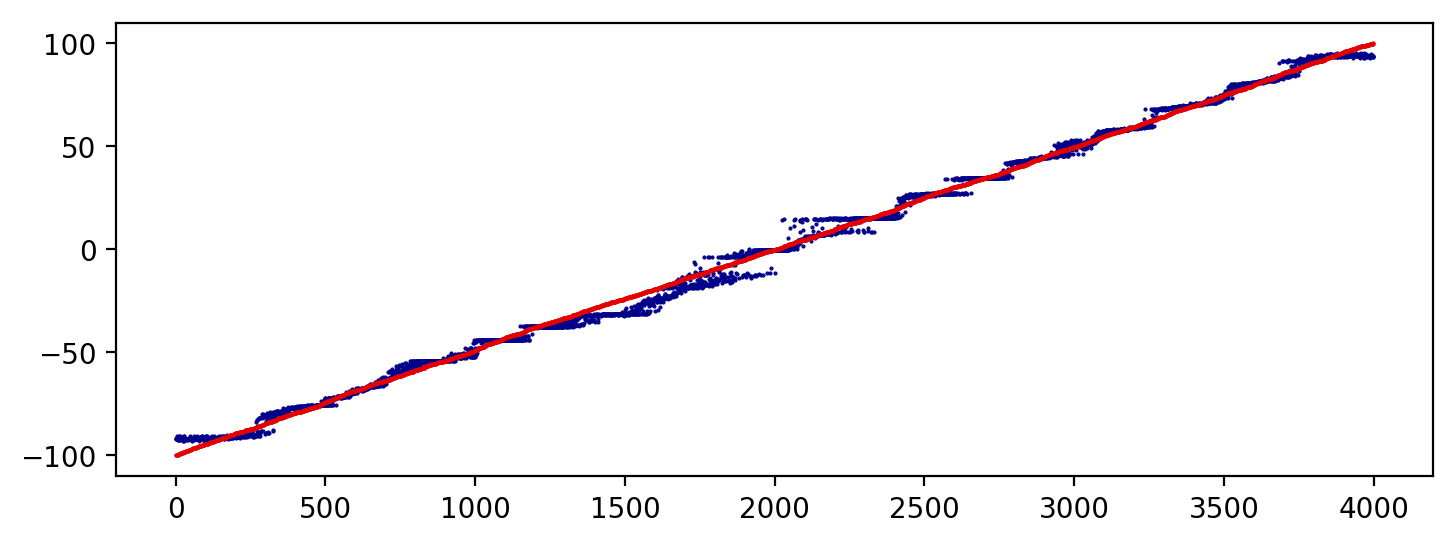

 epoch: 3350 testing_cost: 0.0013570581

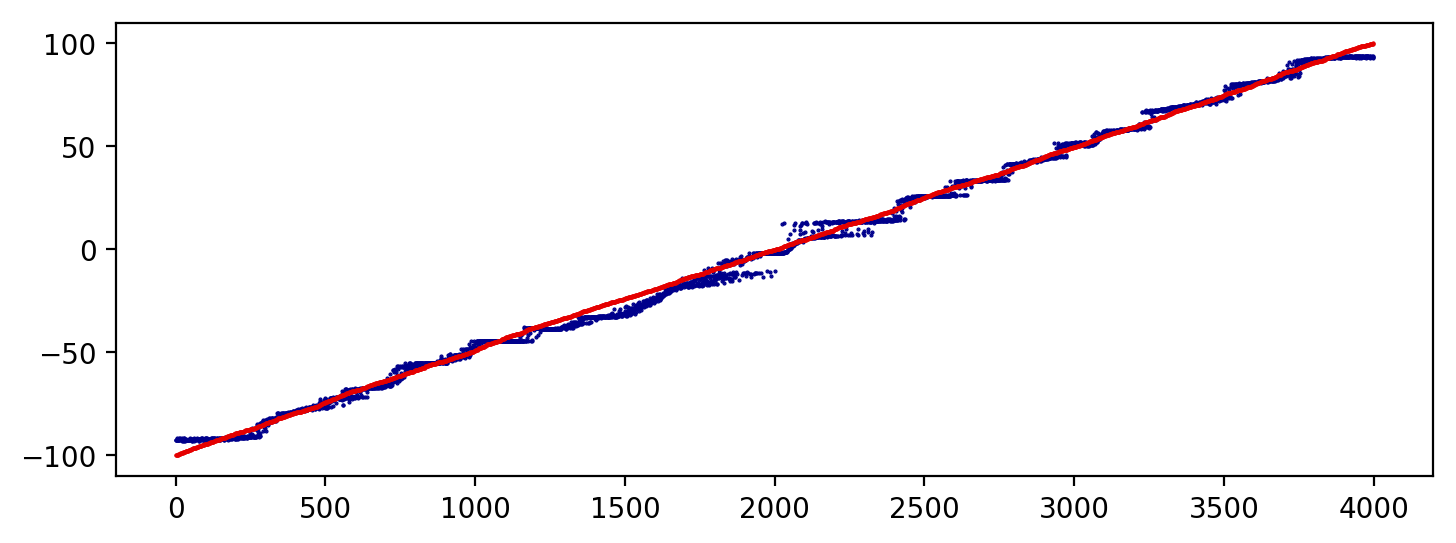

 epoch: 3400 testing_cost: 0.0012058828

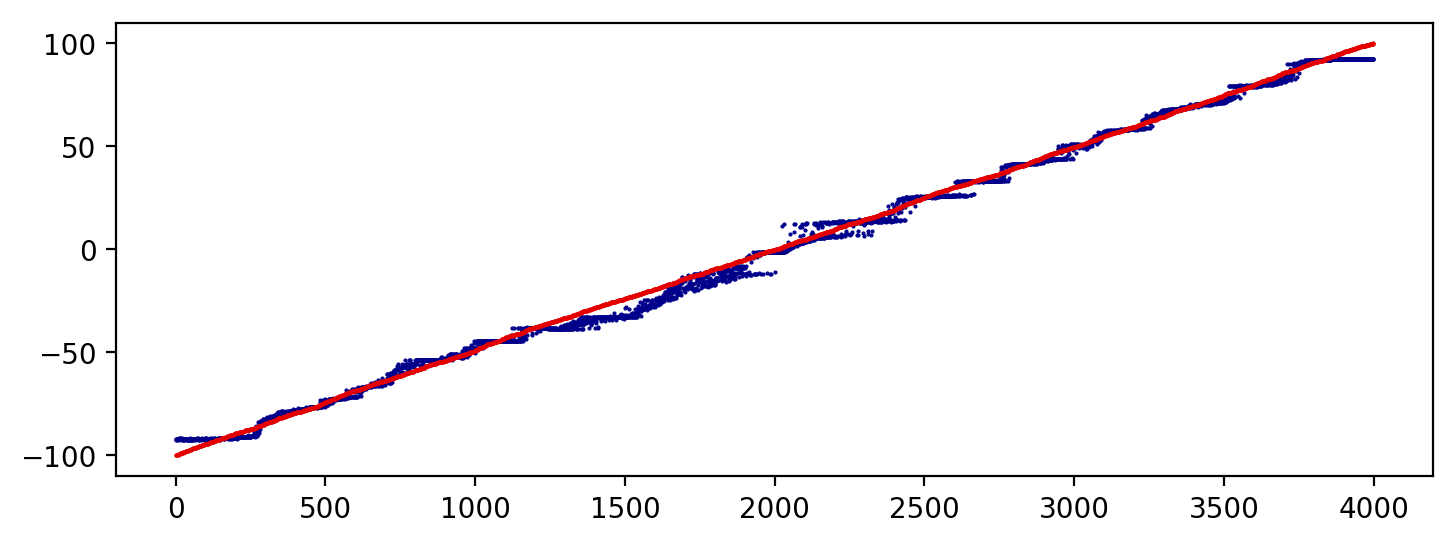

 epoch: 3450 testing_cost: 0.0011512203

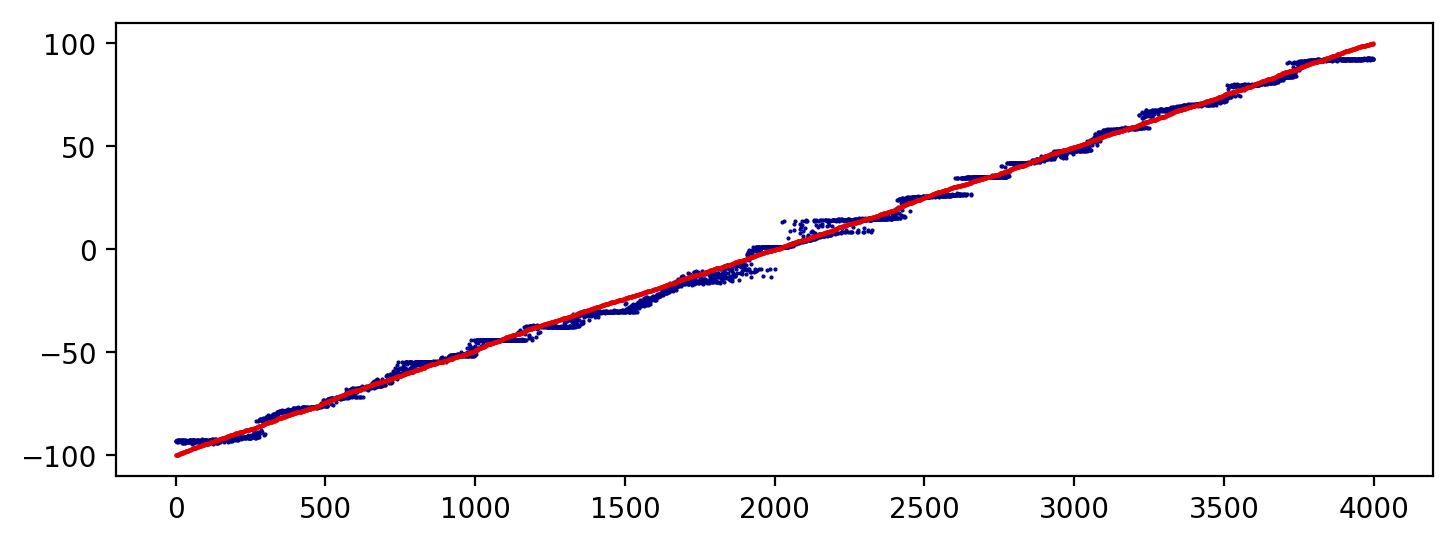

 epoch: 3500 testing_cost: 0.0013795320

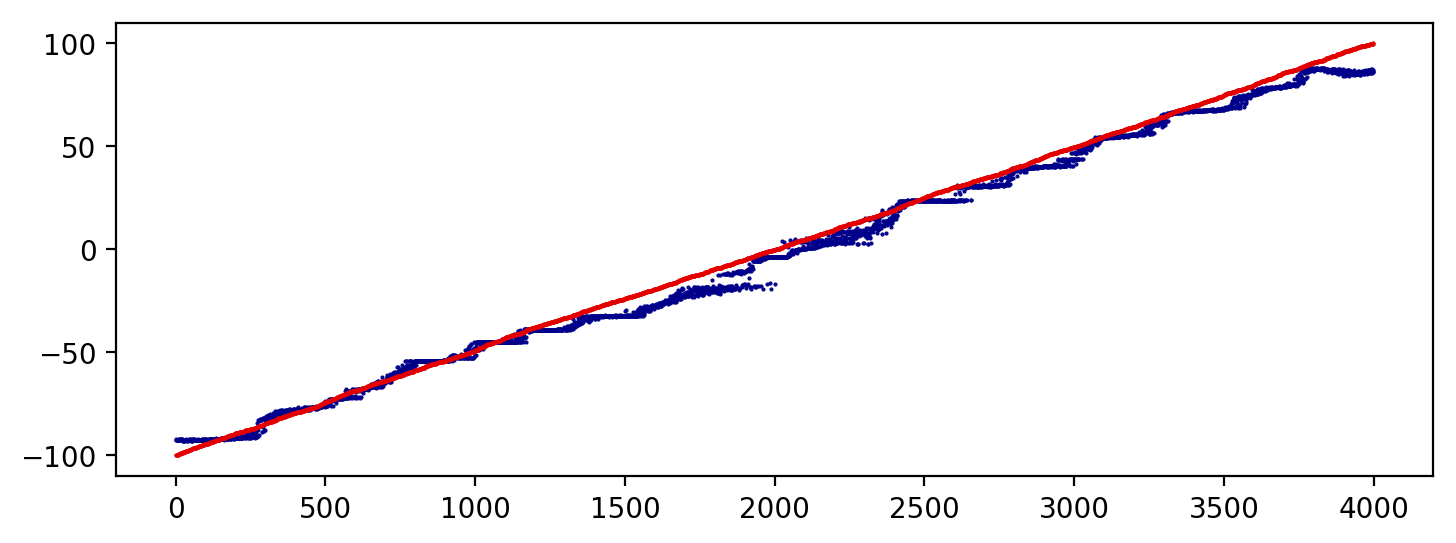

 epoch: 3550 testing_cost: 0.0008658572

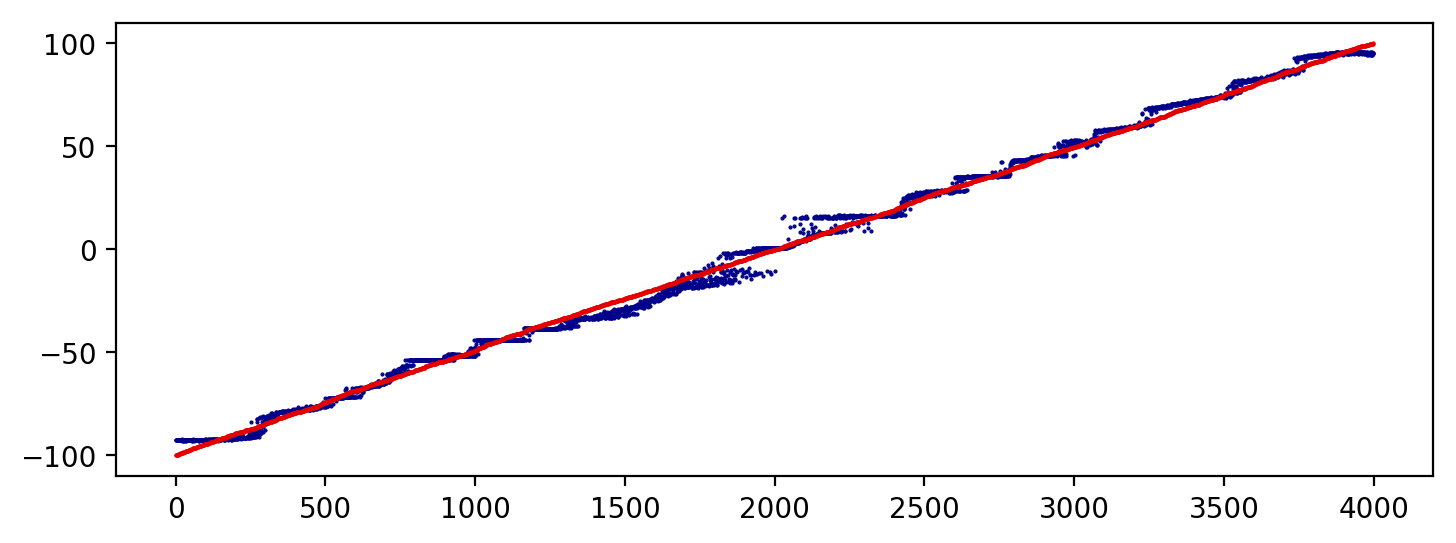

 epoch: 3600 testing_cost: 0.0007303345

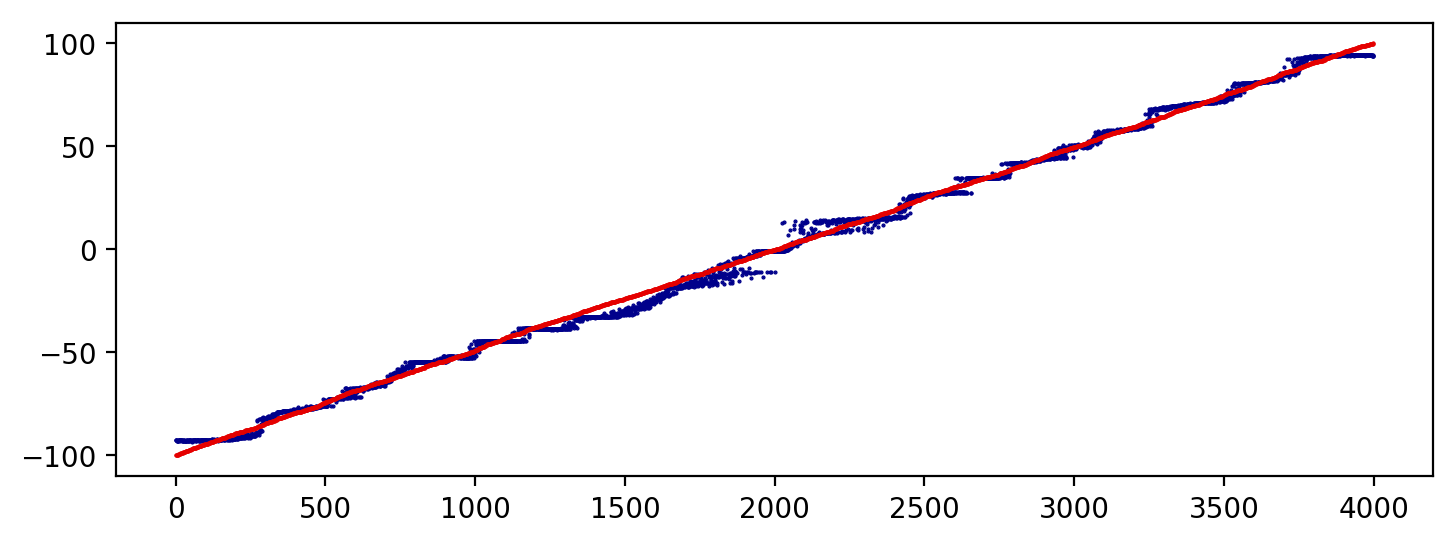

 epoch: 3650 testing_cost: 0.0008527408

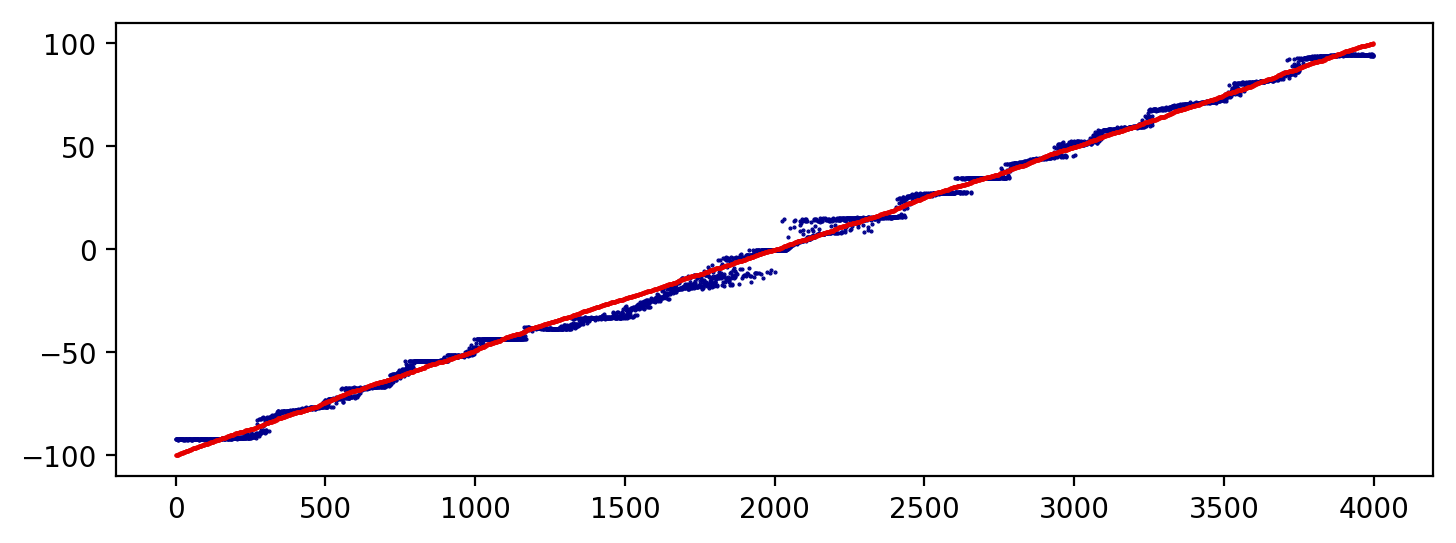

 epoch: 3700 testing_cost: 0.0008064980

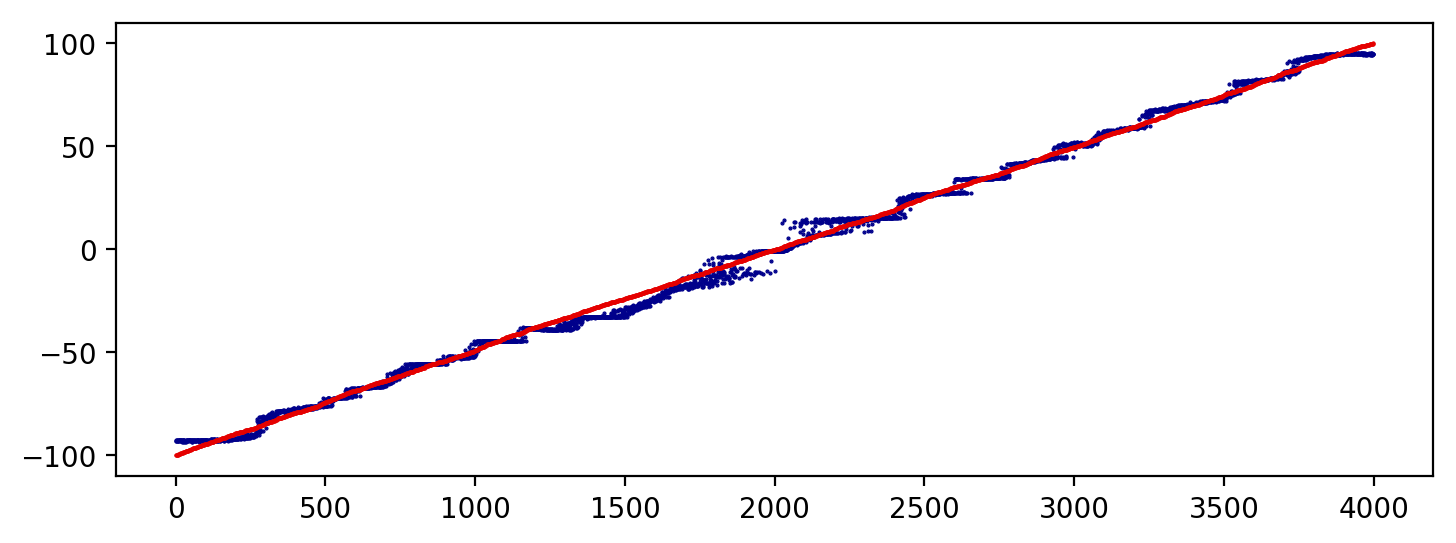

 epoch: 3750 testing_cost: 0.0008125558

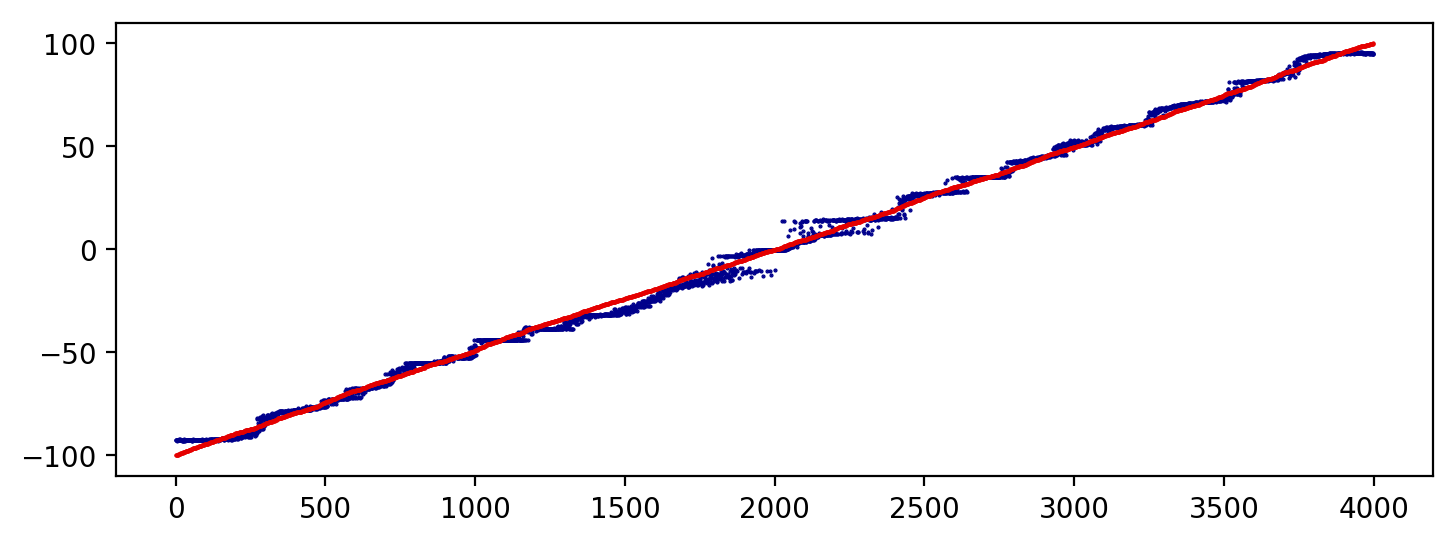

 epoch: 3800 testing_cost: 0.0010708492

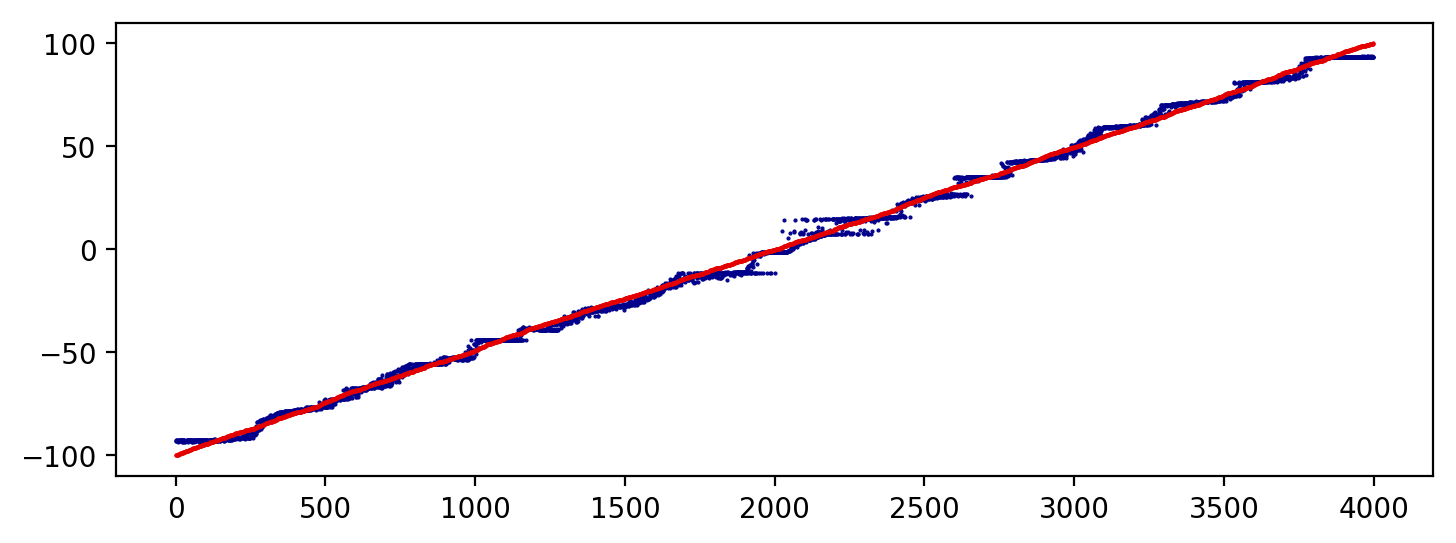

 epoch: 3850 testing_cost: 0.0014127231

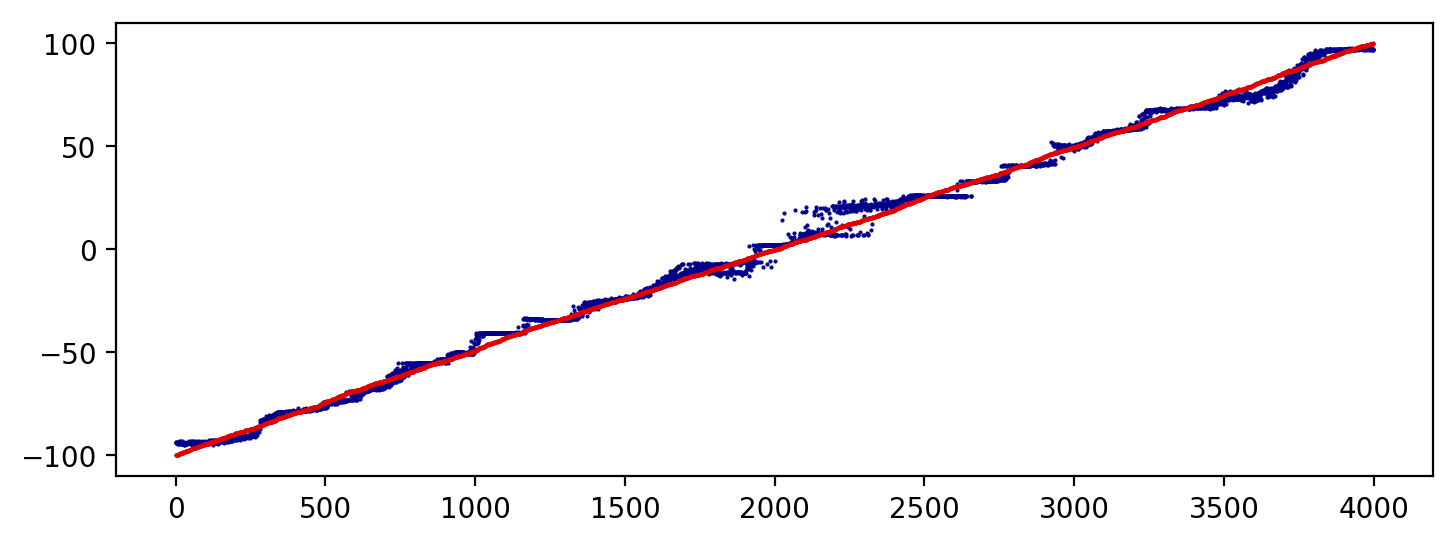

 epoch: 3900 testing_cost: 0.0010411621

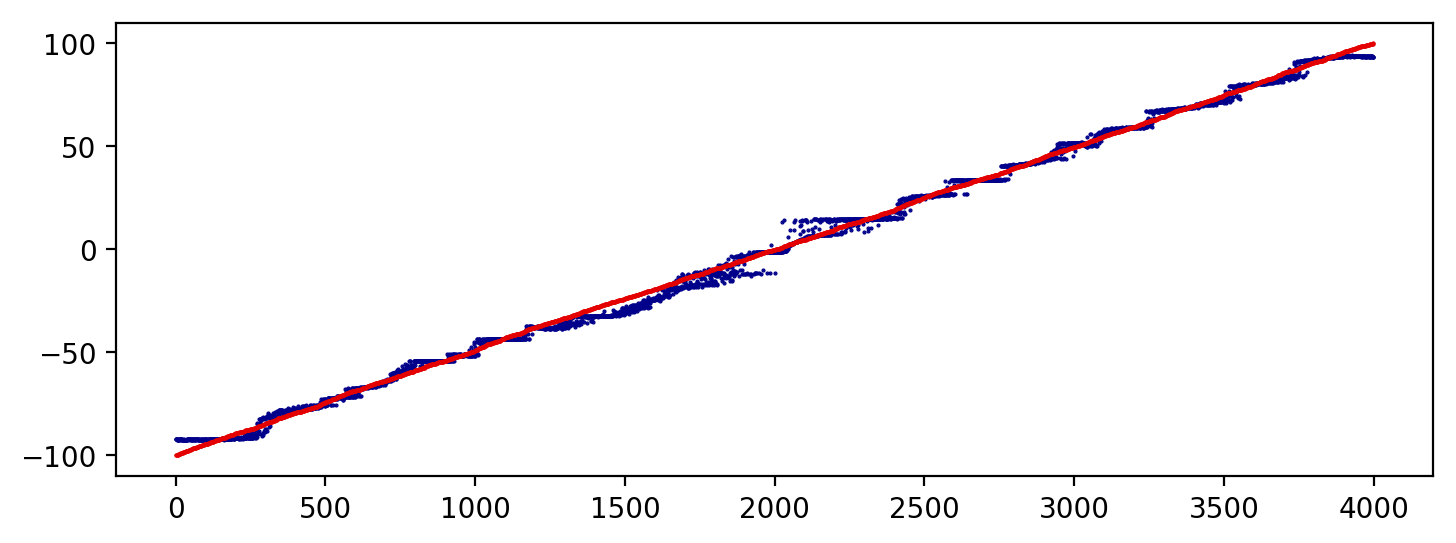

 epoch: 3950 testing_cost: 0.0012723585

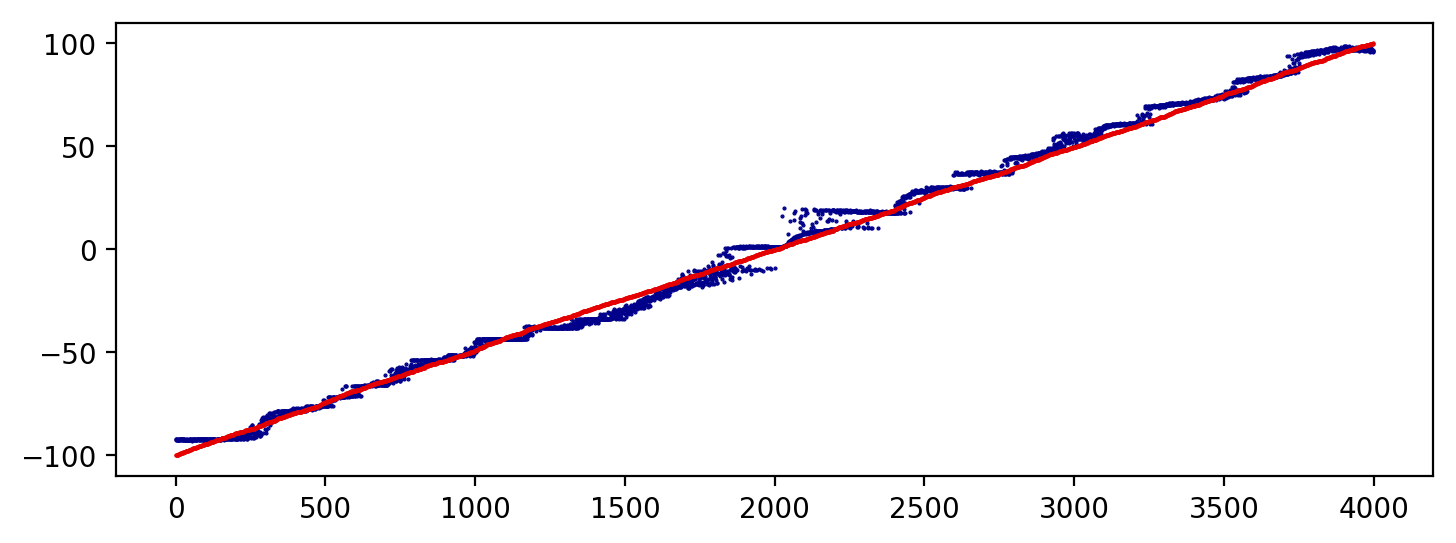

 epoch: 4000 testing_cost: 0.0019067341

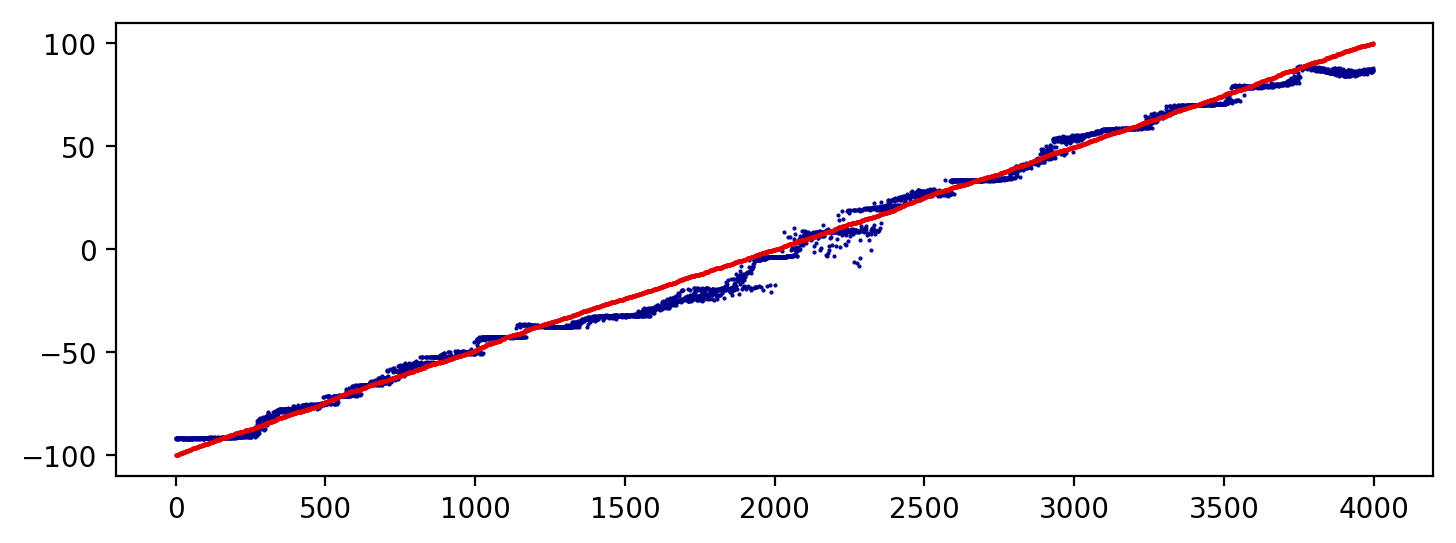

 epoch: 4050 testing_cost: 0.0011582171

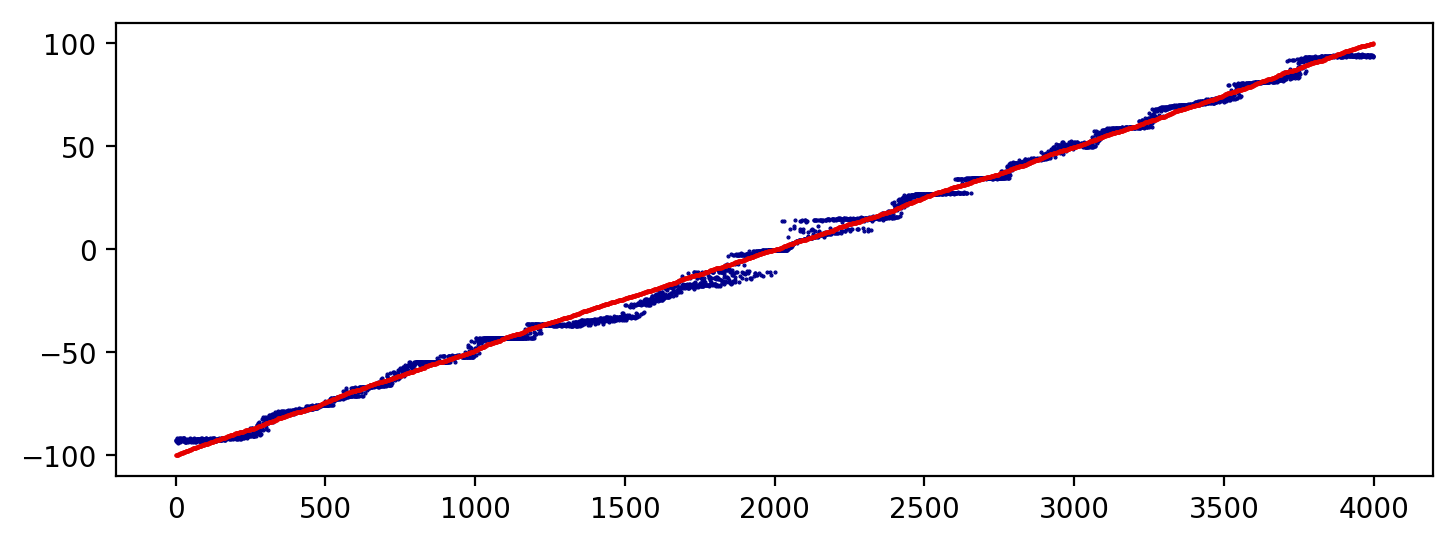

 epoch: 4100 testing_cost: 0.0007588017

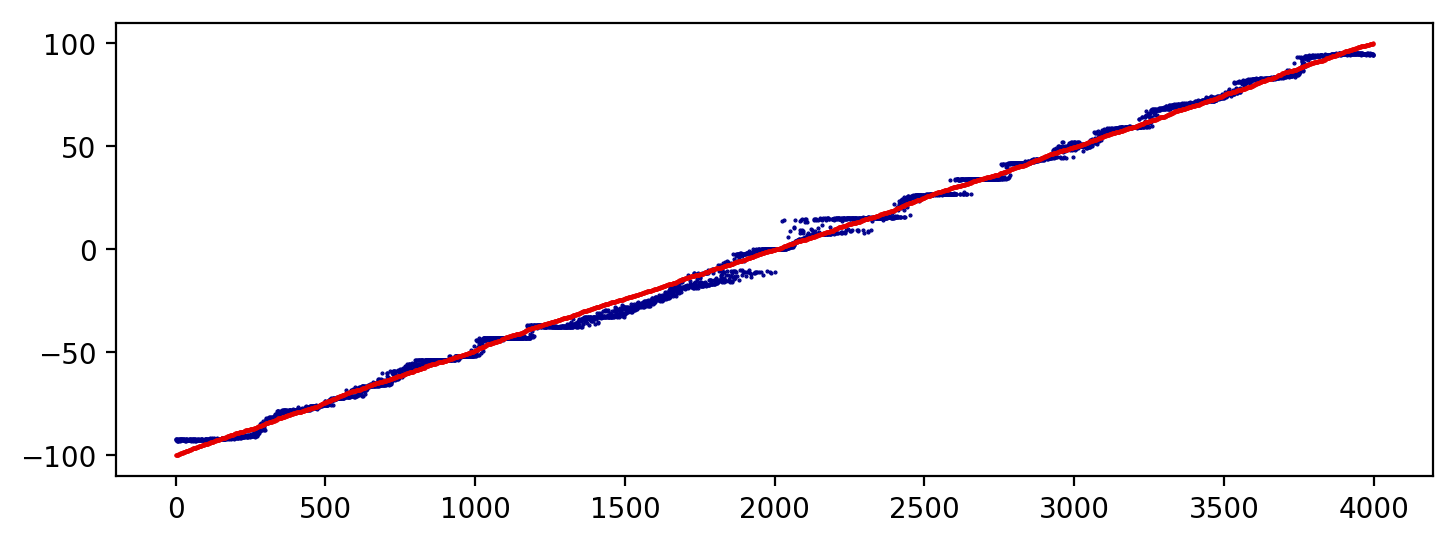

 epoch: 4150 testing_cost: 0.0011673481

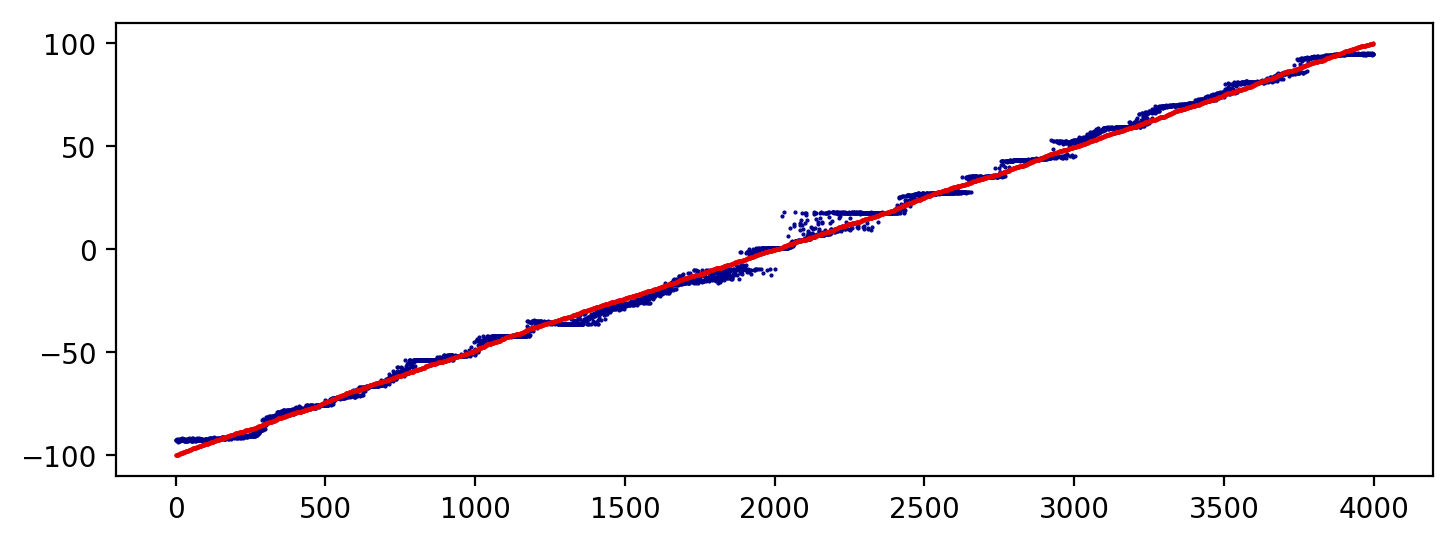

 epoch: 4200 testing_cost: 0.0011693011

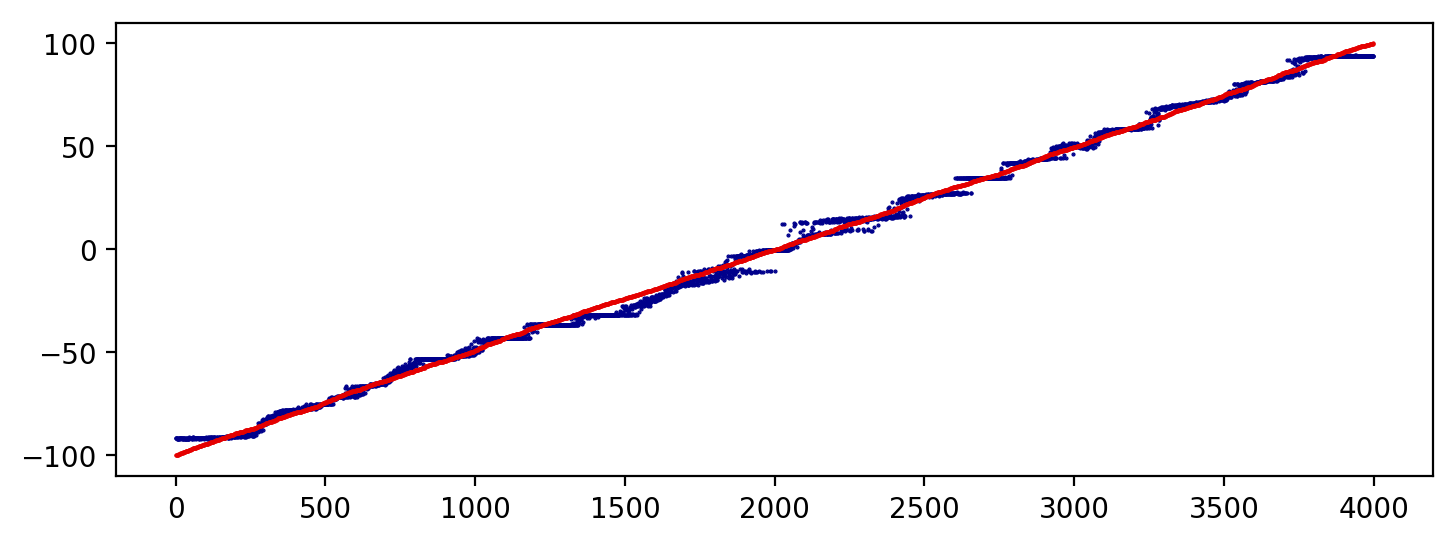

 epoch: 4250 testing_cost: 0.0008181030

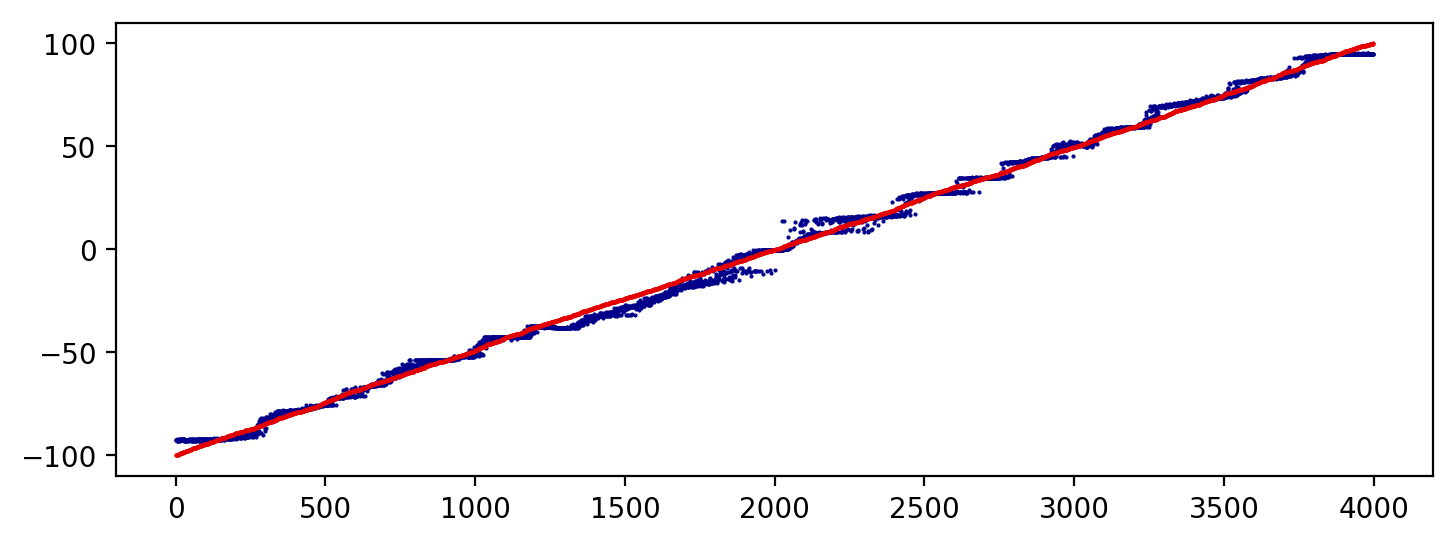

 epoch: 4300 testing_cost: 0.0015888767

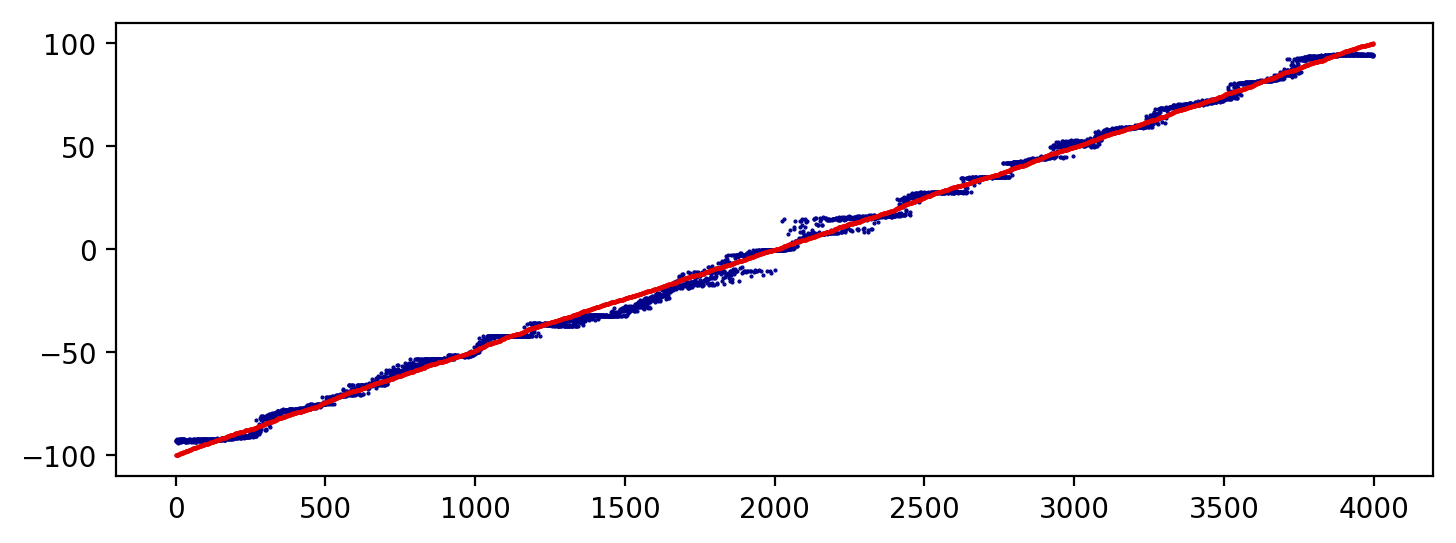

 epoch: 4350 testing_cost: 0.0011323433

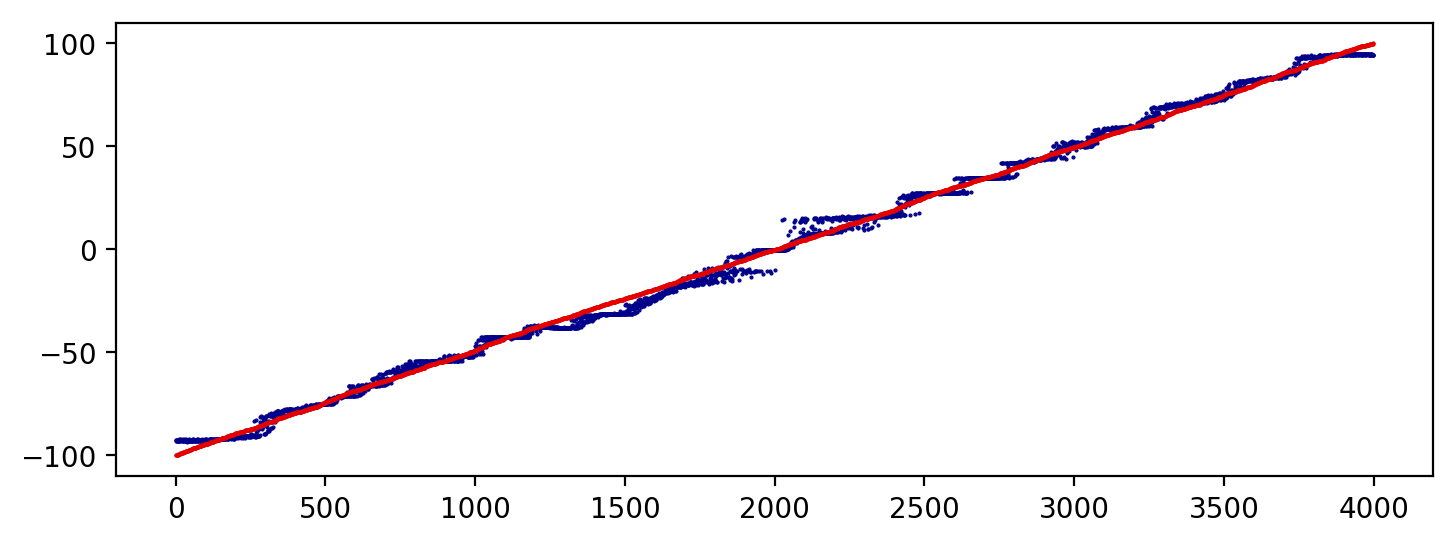

 epoch: 4400 testing_cost: 0.0013908494

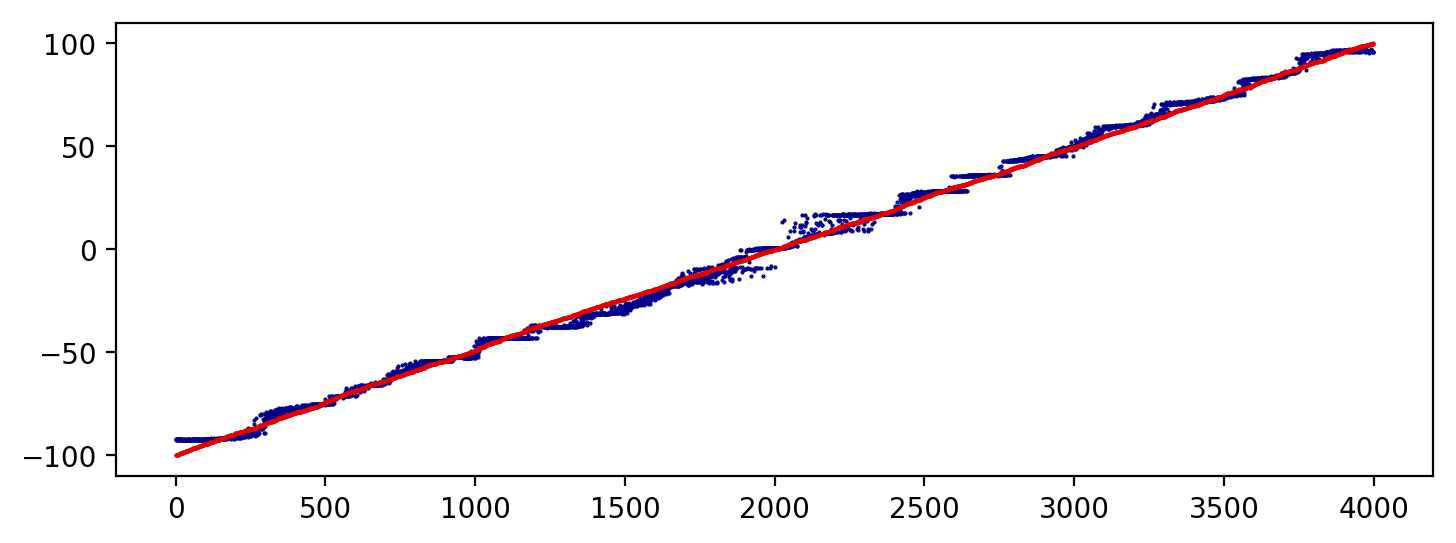

 epoch: 4450 testing_cost: 0.0011567196

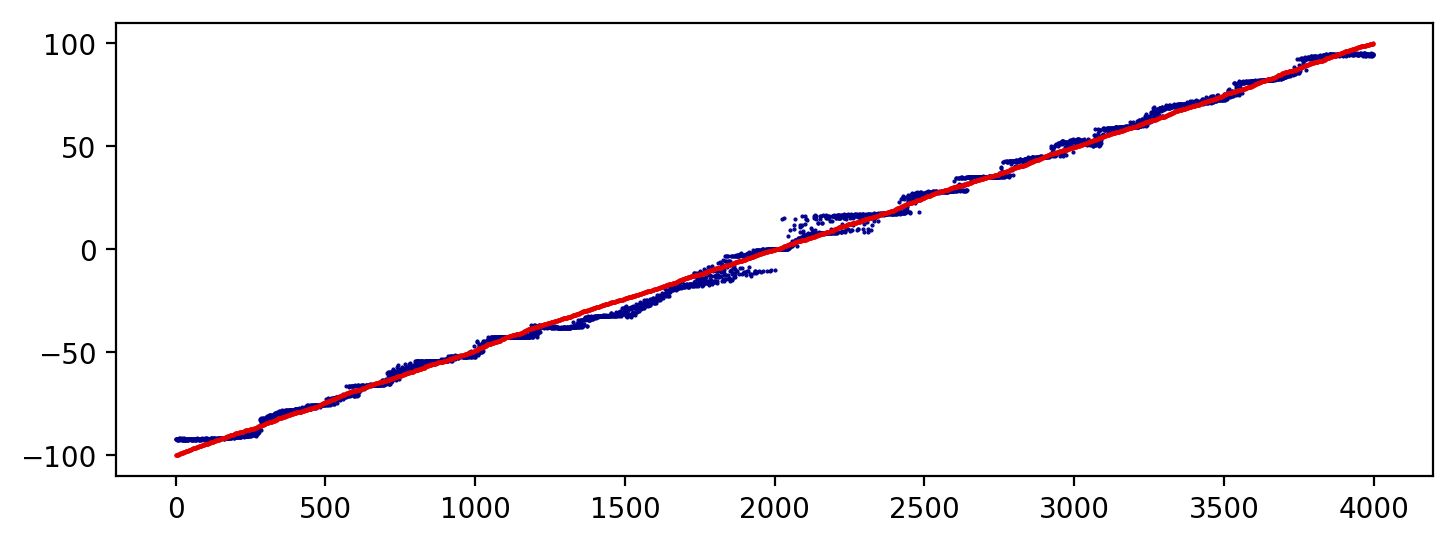

 epoch: 4499 testing_cost: 0.0014325875

In [17]:
with tf.Session() as session:

    saver.restore(session,model_save_location + '-2999')

    training_writer = tf.summary.FileWriter(log_direc + '/training', session.graph)
    testing_writer = tf.summary.FileWriter(log_direc + '/testing', session.graph)
    model_save_location = log_direc + '/trained_model.ckpt'


    for epoch in range(training_epochs):
        epoch = epoch + 2*training_epochs


        # Feed in the training data and do one stepf NN training
        session.run(optimizer,
                    feed_dict = {X: X_scaled_training, Y: Y_scaled_training, keep_prob : 0.50})

        training_feed = {X: X_scaled_training, Y: Y_scaled_training, keep_prob : 0.50}
        training_cost, training_summary = session.run([cost, summary],
                                                feed_dict = training_feed)

        testing_feed =  {X: X_scaled_testing, Y: Y_scaled_testing, keep_prob : 1.00}
        testing_cost, testing_summary = session.run([cost, summary],
                                                     feed_dict = testing_feed)
        sys.stdout.write('\r epoch: {:4.0f} testing_cost: {:2.10f}'.format(epoch, training_cost))
        
        training_writer.add_summary(training_summary, epoch)
        testing_writer.add_summary(testing_summary, epoch)
        testing_writer.flush()
        training_writer.flush()
        
        if epoch % 50 == 0 or epoch == training_epochs:
            saver.save(session, model_save_location, epoch)
            prediction_scaled = session.run(prediction, feed_dict = {X: X_scaled_testing, keep_prob : 1.00})
            prediction_unscaled = Y_scaler.inverse_transform(prediction_scaled)
            sorting_idx = np.argsort(Y_testing.T[0])
        
            fig, ax = plt.subplots(figsize = (8.5, 3), dpi = 100)
            
            ax.plot(prediction_unscaled.T[0][sorting_idx], linestyle = 'none', marker = '.', markersize = 1, color = 'darkblue')
            ax.plot(Y_testing.T[0][sorting_idx], linestyle = 'none', marker = '.', markersize = 1, alpha = 0.75, color = '#E50000')
            plt.show()
            
    saver.save(session, model_save_location, epoch)

In [18]:
print(sum((Y_scaled_testing.T[0] - prediction_scaled.T[0])**2))
print(np.std(abs(Y_testing.T[0] - prediction_unscaled.T[0])))

0.9258464699962601
1.883307959939107


In [19]:
#import data
data_df = pd.read_csv('../../data/wrapped_20000_gaussian_spikes_twentyfive_percent_D.bz2', compression = 'bz2')

# split random 80% / 20%
training_data_df = data_df.sample(frac = 0.8)
testing_data_df = data_df.loc[~data_df.index.isin(training_data_df.index)]

# separate input features from output
X_training = training_data_df.drop('tau', axis = 1).values
Y_training = training_data_df[['tau']].values

X_testing = testing_data_df.drop('tau', axis = 1).values
Y_testing = testing_data_df[['tau']].values

# scale data
X_scaled_training = X_scaler.transform(X_training)
Y_scaled_training = Y_scaler.transform(Y_training)

X_scaled_testing = X_scaler.transform(X_testing)
Y_scaled_testing = Y_scaler.transform(Y_testing)

INFO:tensorflow:Restoring parameters from ../../logs/659566/trained_model.ckpt-4499
 epoch: 4500 testing_cost: 0.0012037554

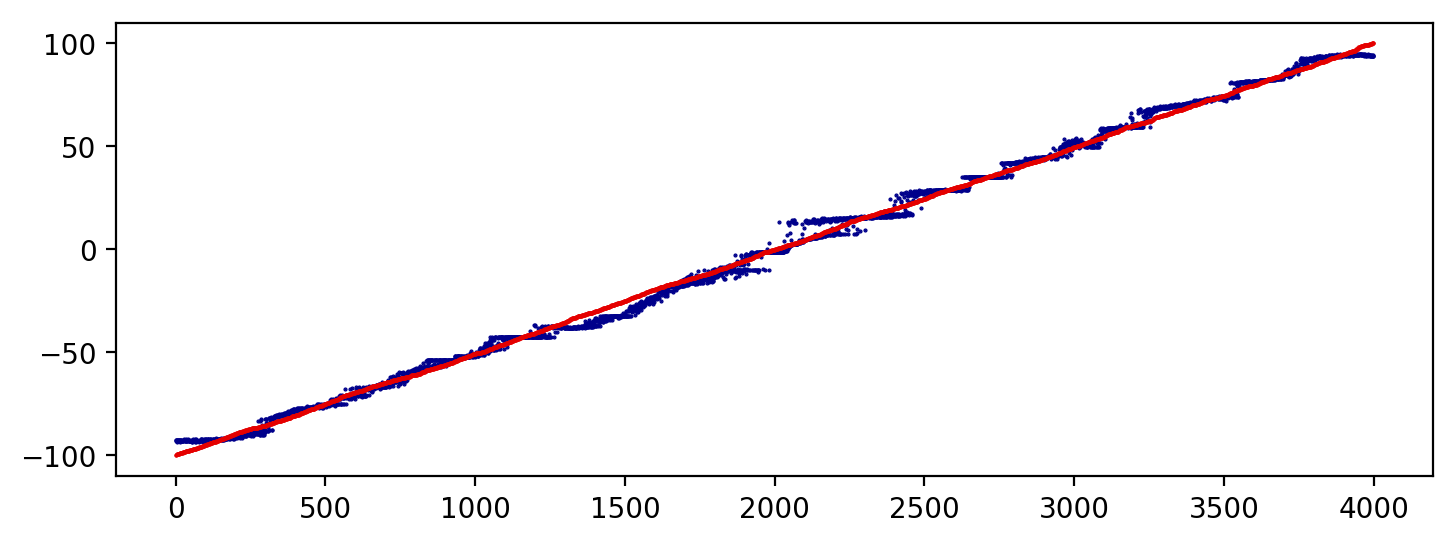

 epoch: 4550 testing_cost: 0.0012243434

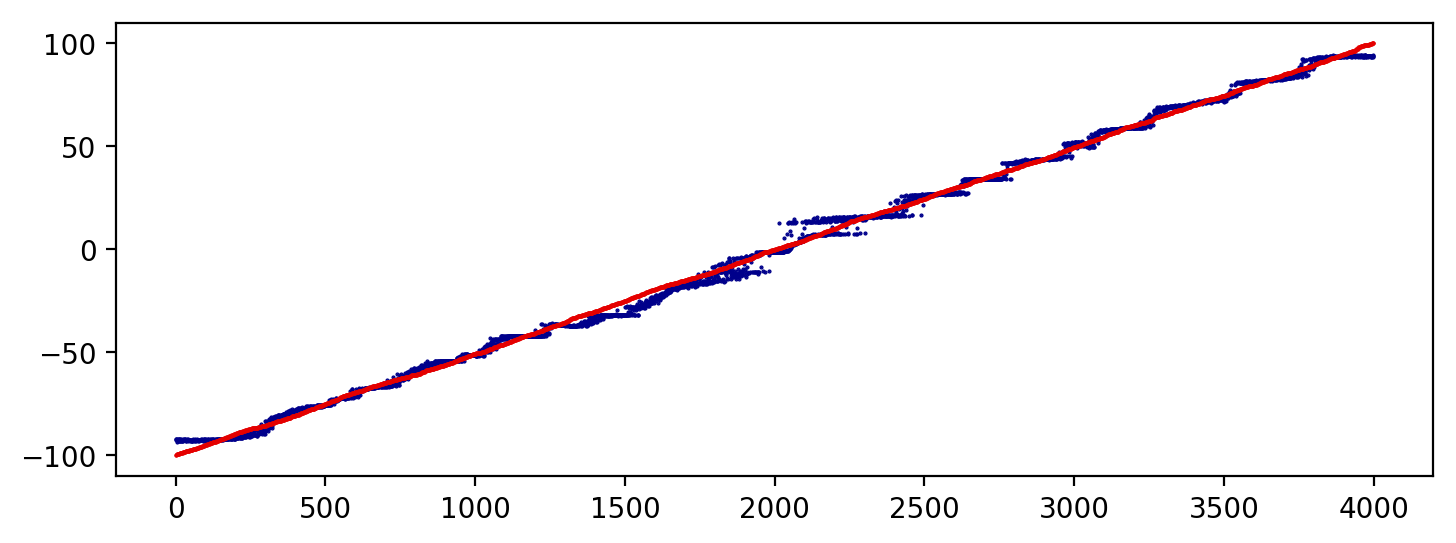

 epoch: 4600 testing_cost: 0.0009059468

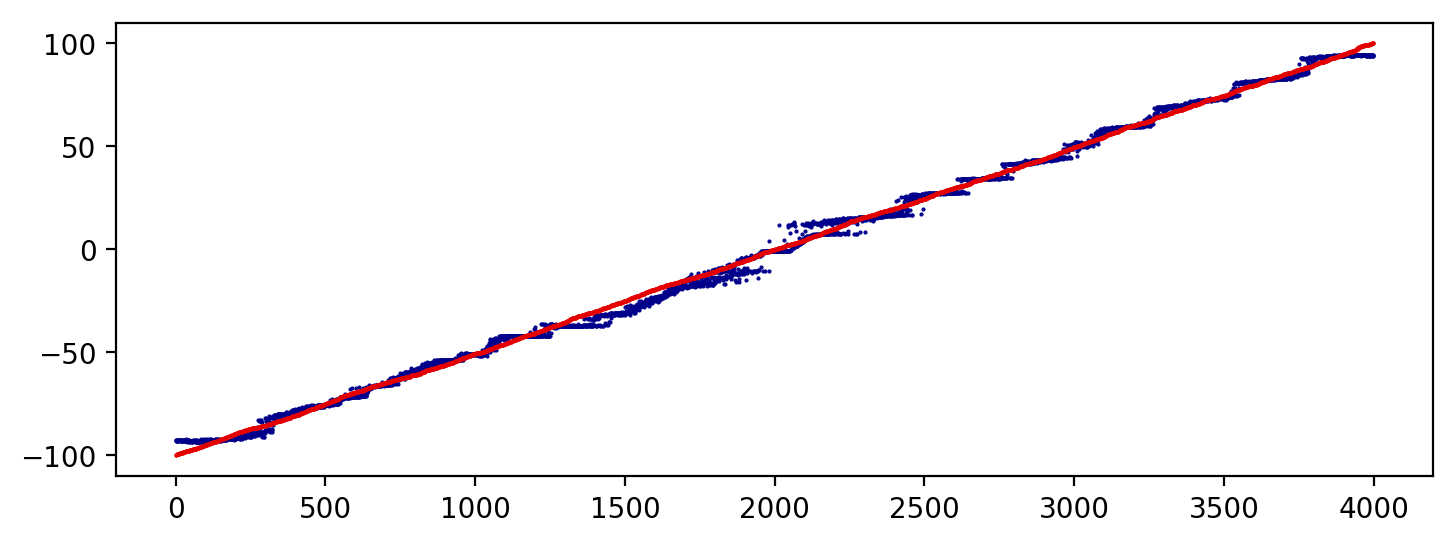

 epoch: 4650 testing_cost: 0.0008755139

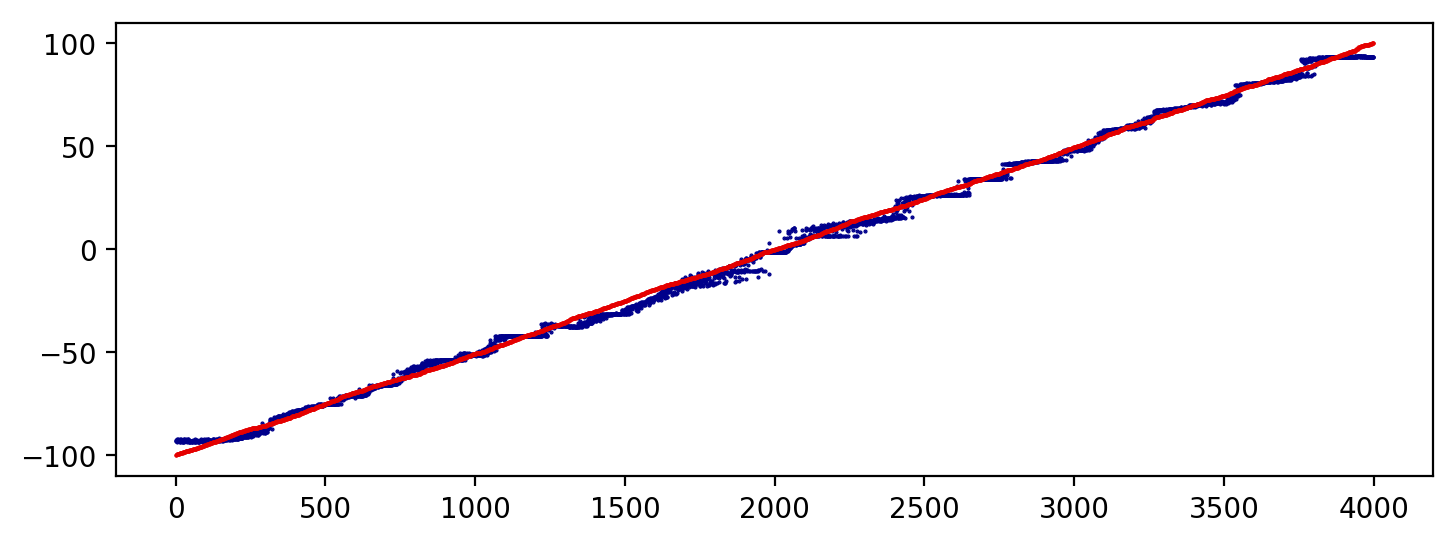

 epoch: 4700 testing_cost: 0.0008063390

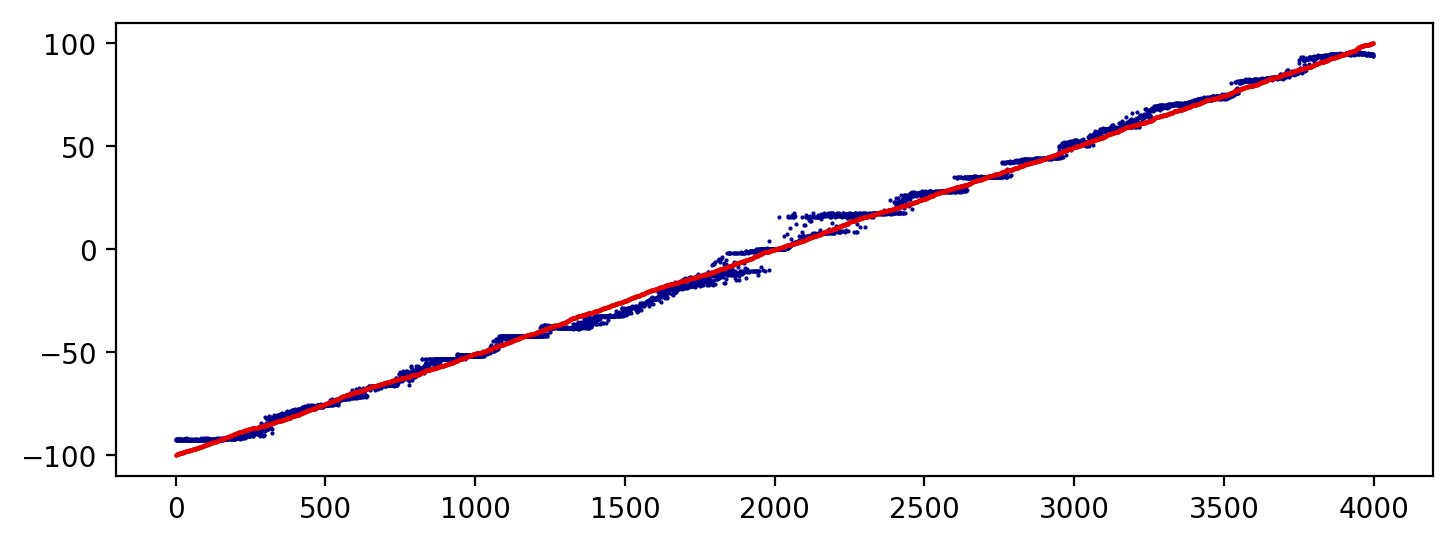

 epoch: 4750 testing_cost: 0.0008458022

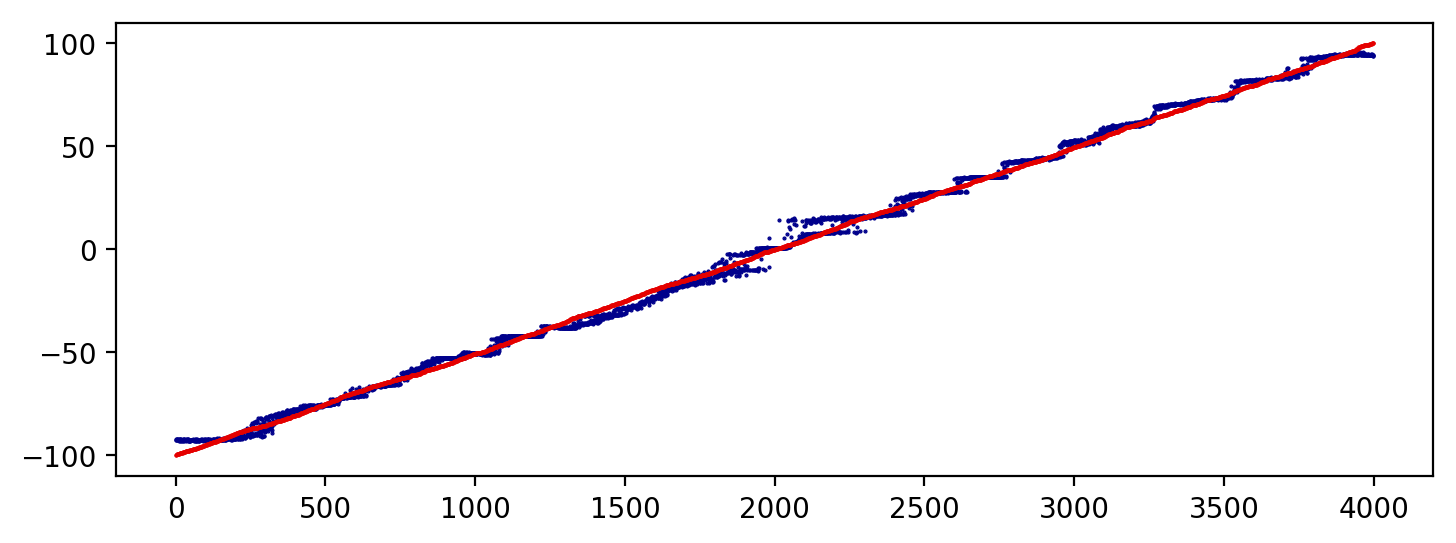

 epoch: 4800 testing_cost: 0.0008969350

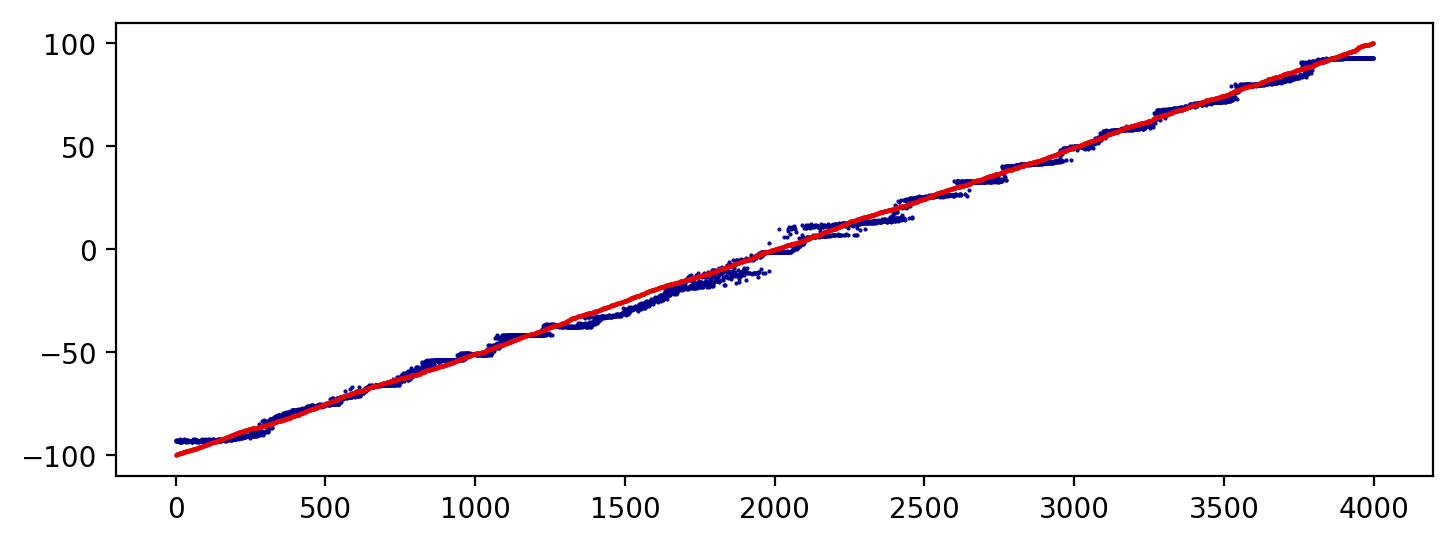

 epoch: 4850 testing_cost: 0.0009410729

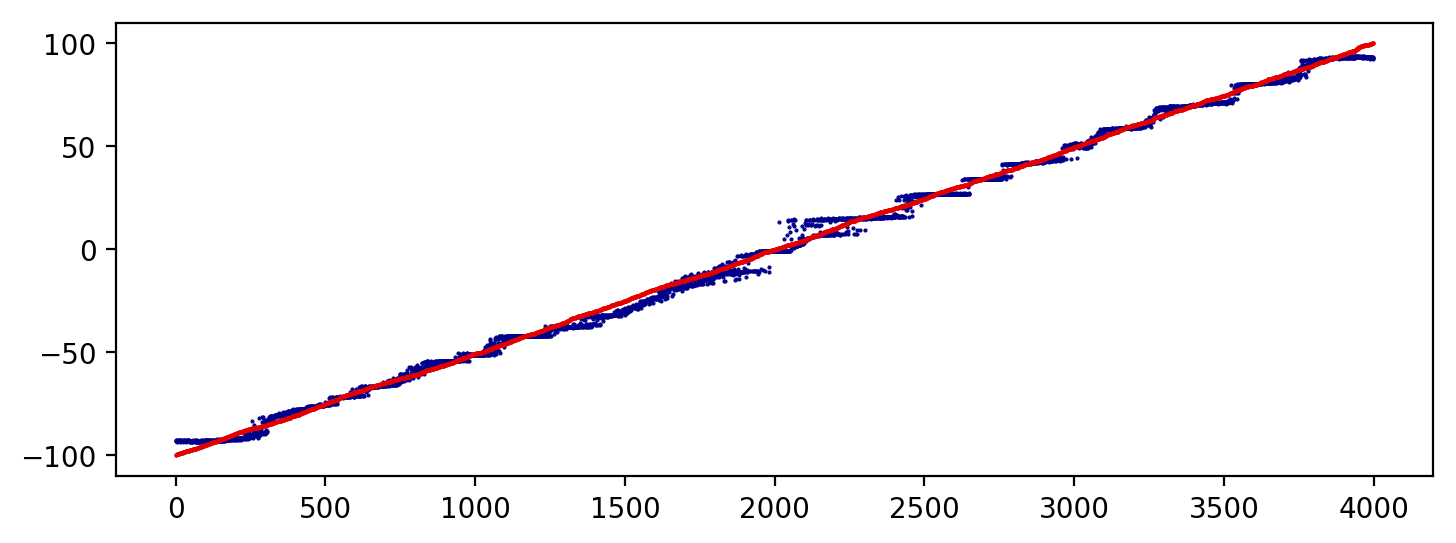

 epoch: 4900 testing_cost: 0.0011841712

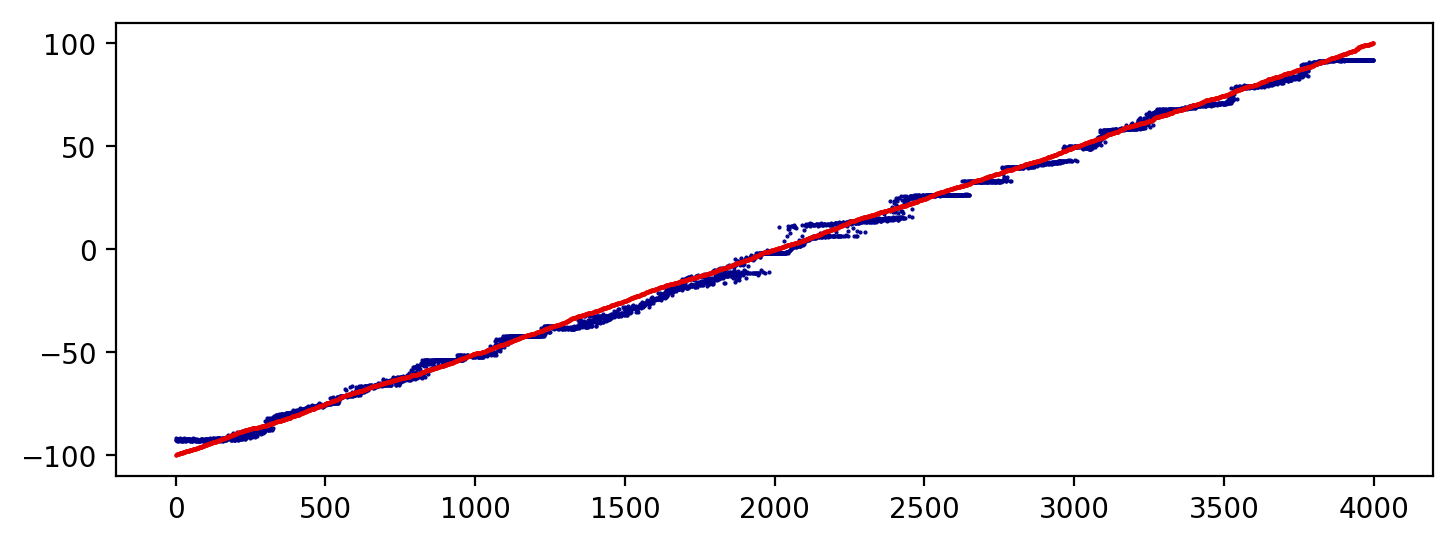

 epoch: 4950 testing_cost: 0.0012745798

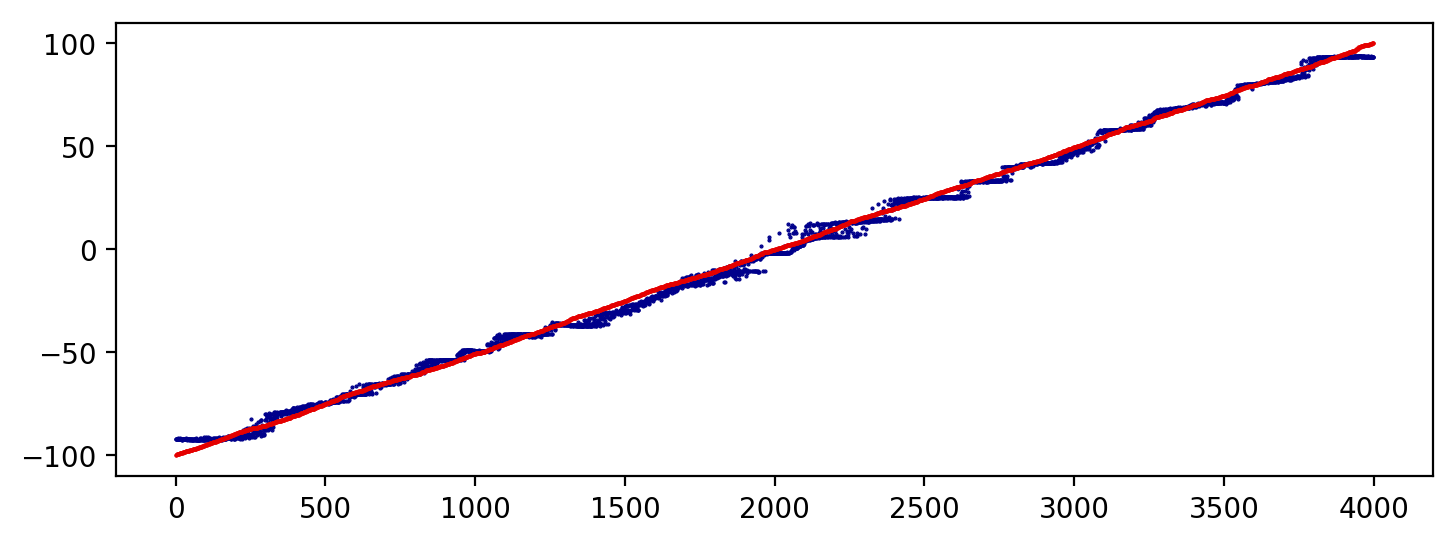

 epoch: 5000 testing_cost: 0.0010055009

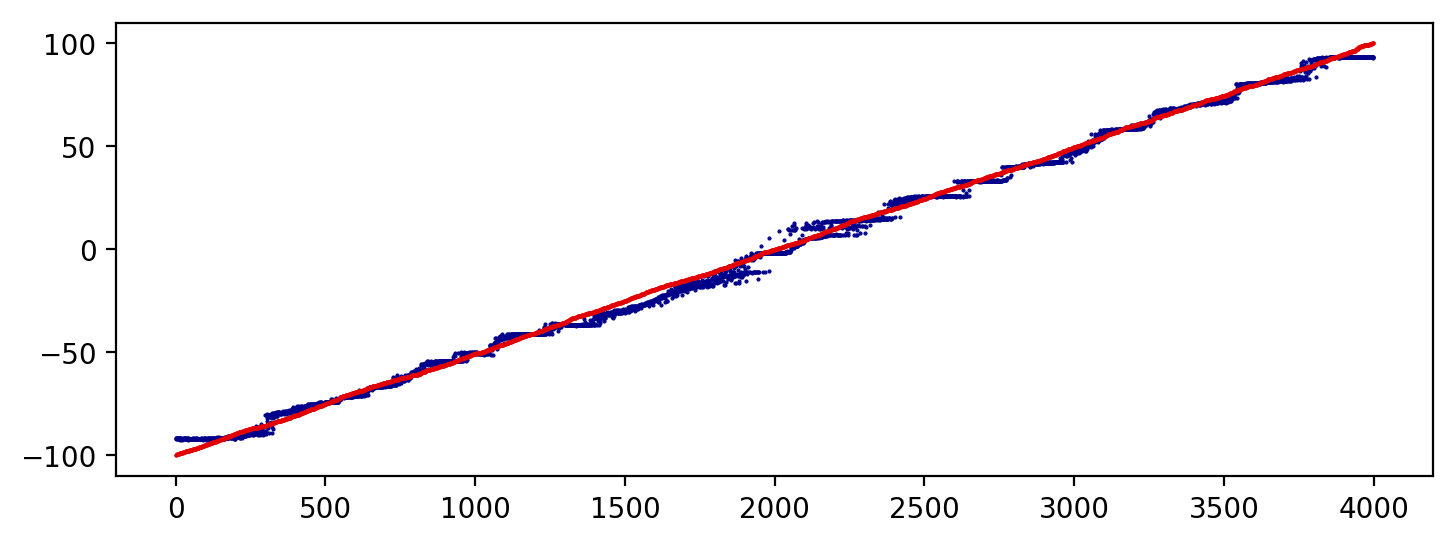

 epoch: 5050 testing_cost: 0.0008941129

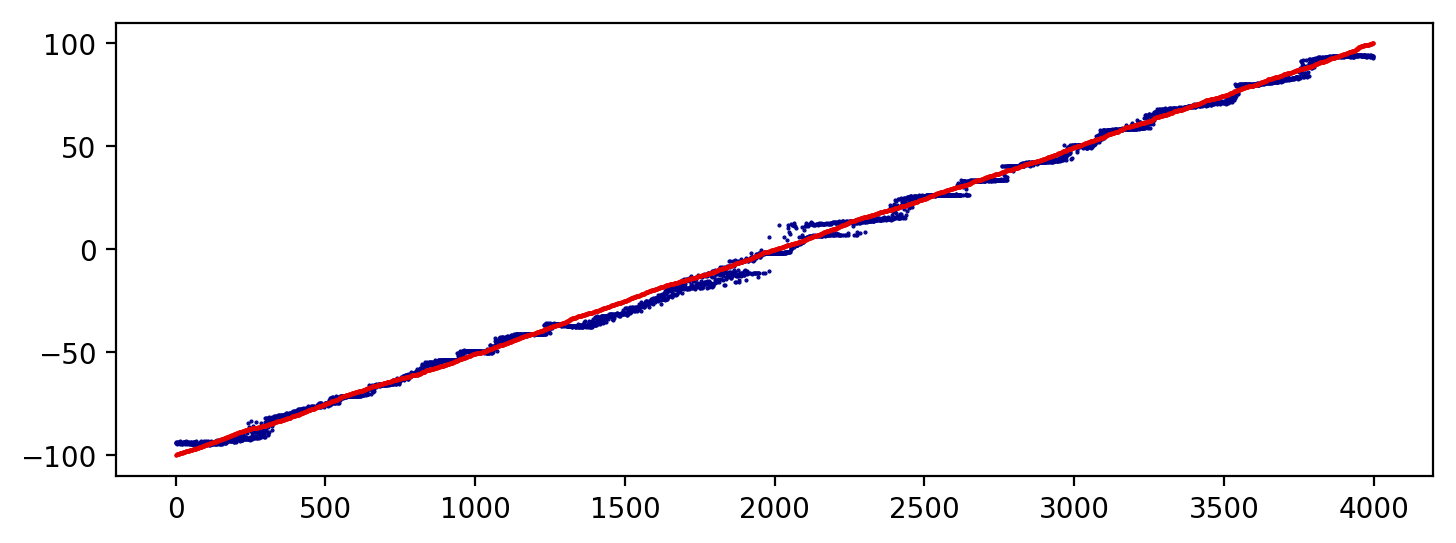

 epoch: 5100 testing_cost: 0.0010316388

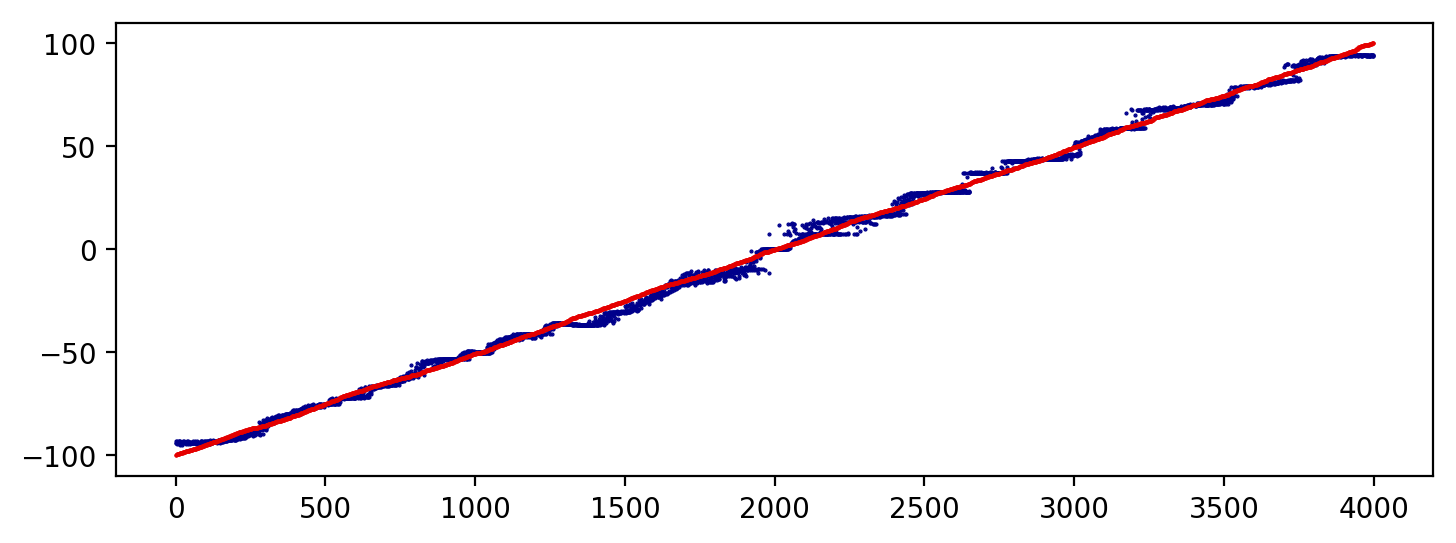

 epoch: 5150 testing_cost: 0.0011015686

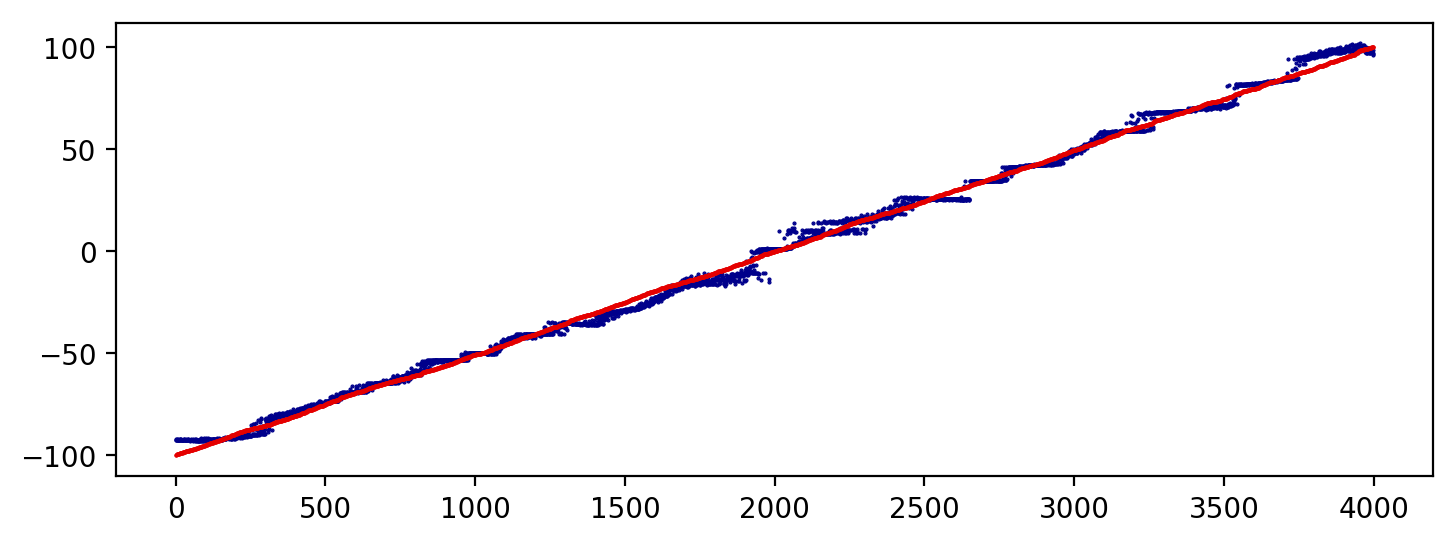

 epoch: 5200 testing_cost: 0.0010176117

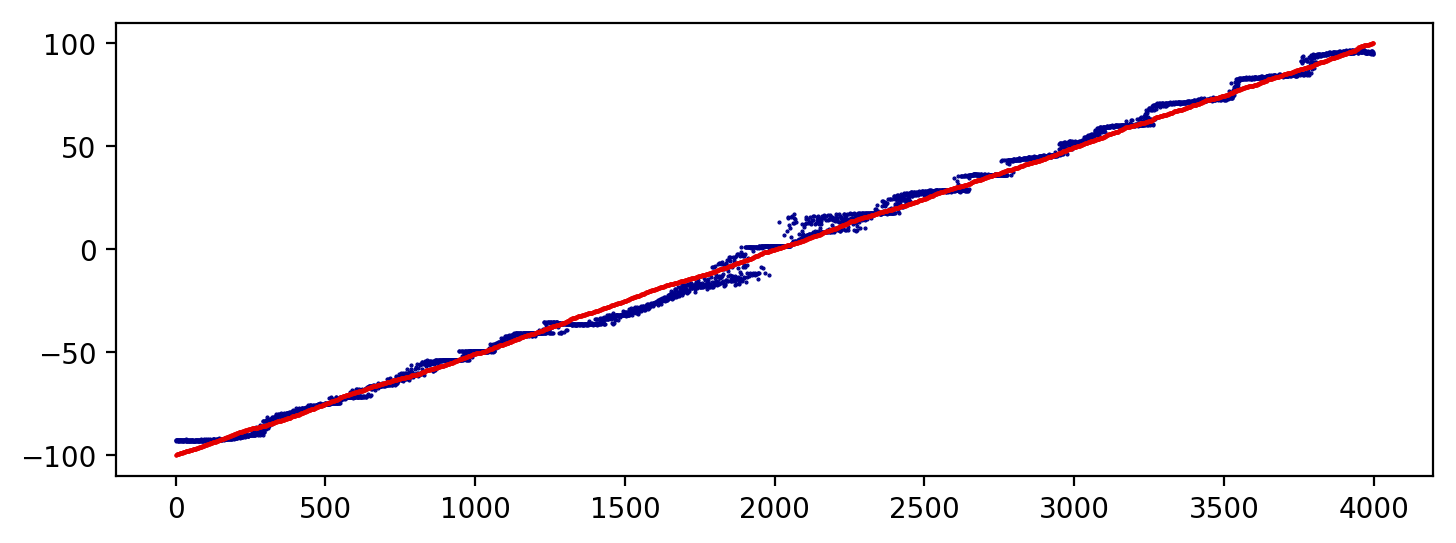

 epoch: 5250 testing_cost: 0.0007913000

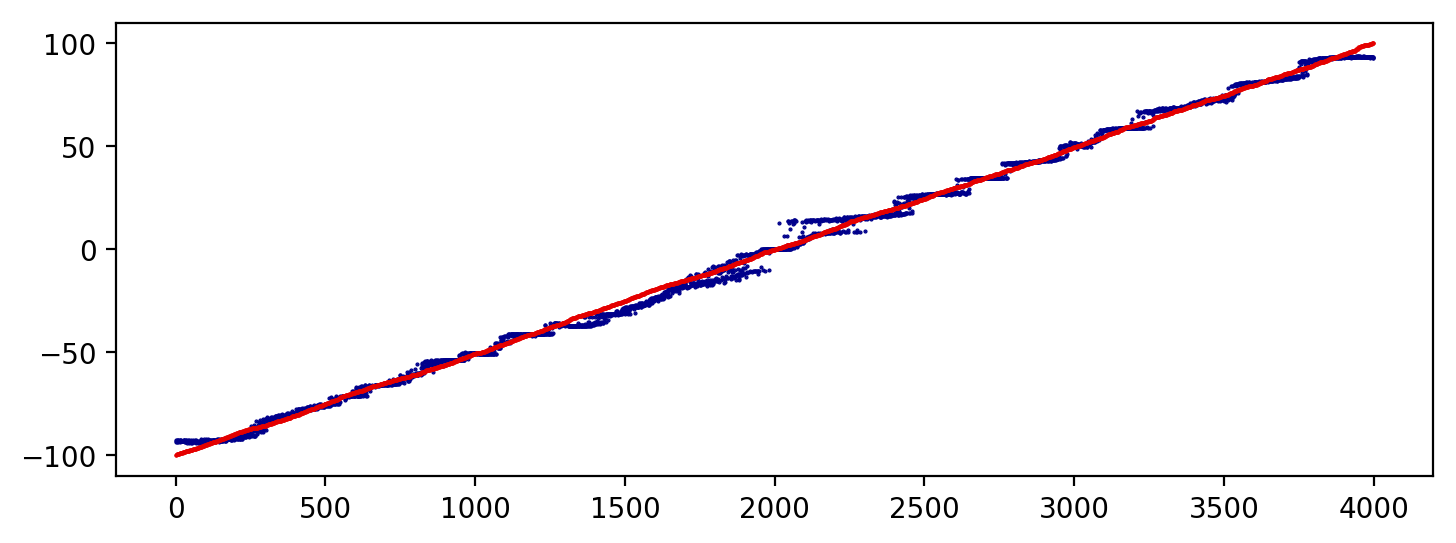

 epoch: 5300 testing_cost: 0.0007313185

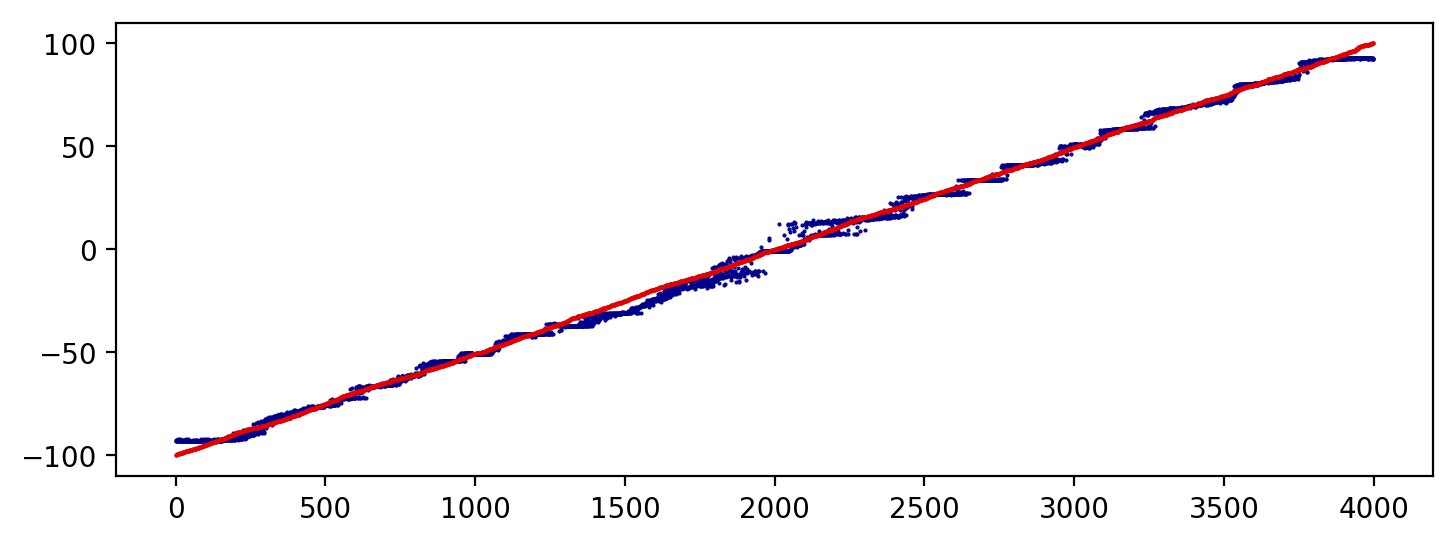

 epoch: 5350 testing_cost: 0.0009859996

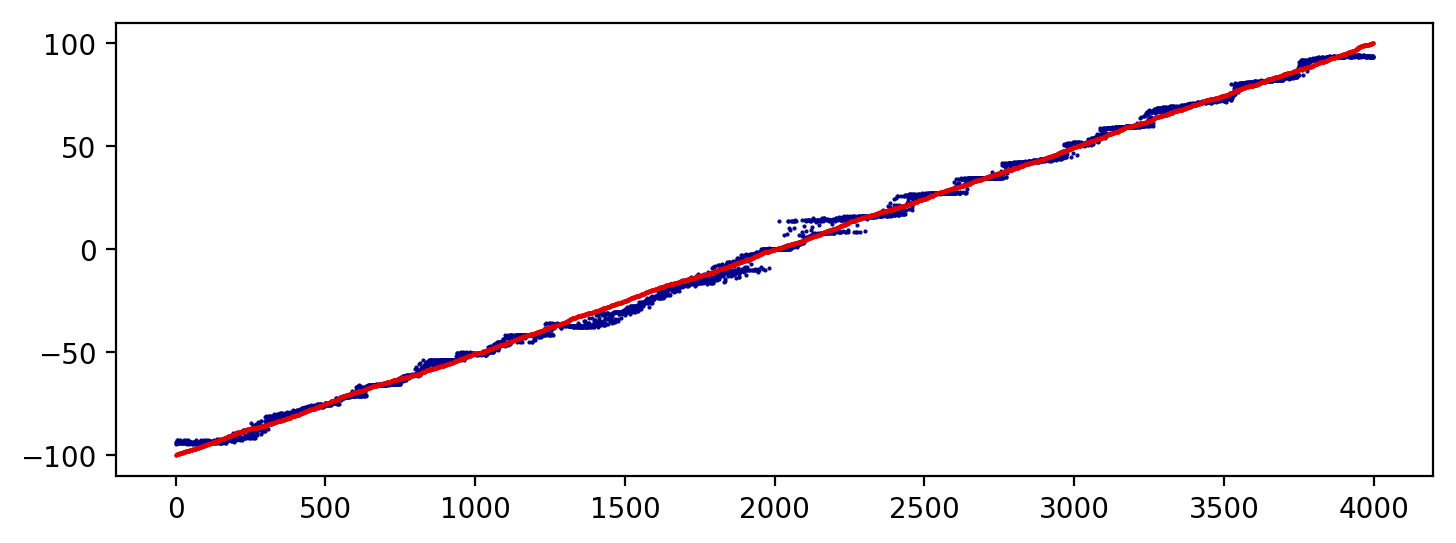

 epoch: 5400 testing_cost: 0.0029877019

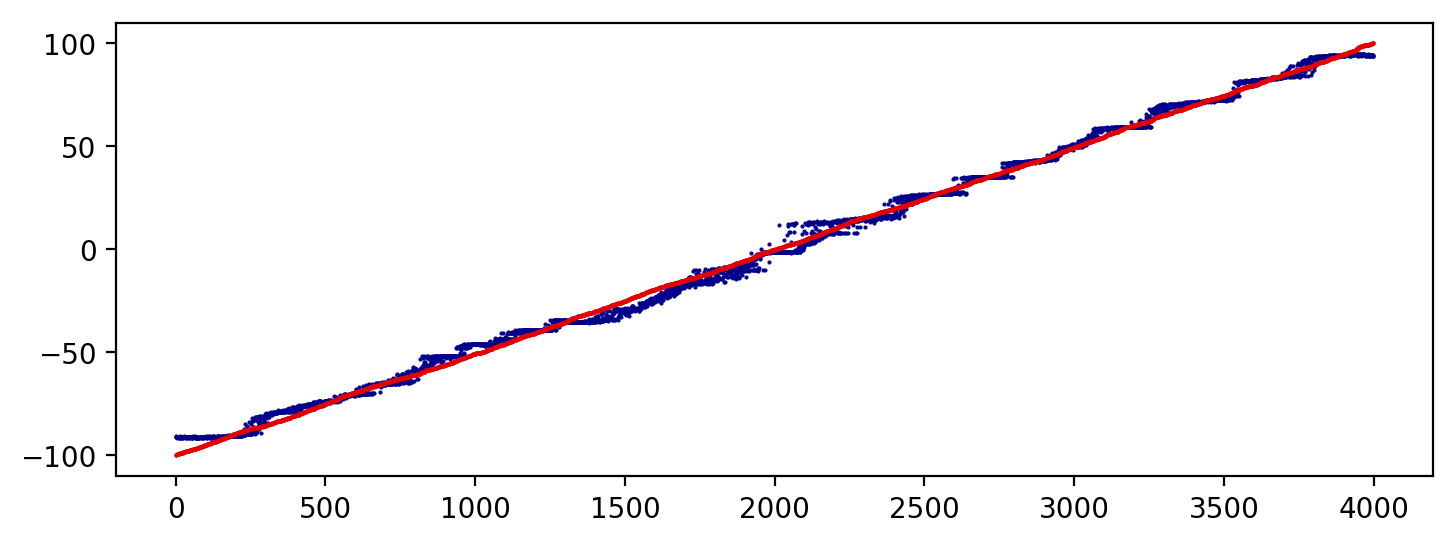

 epoch: 5450 testing_cost: 0.0014837395

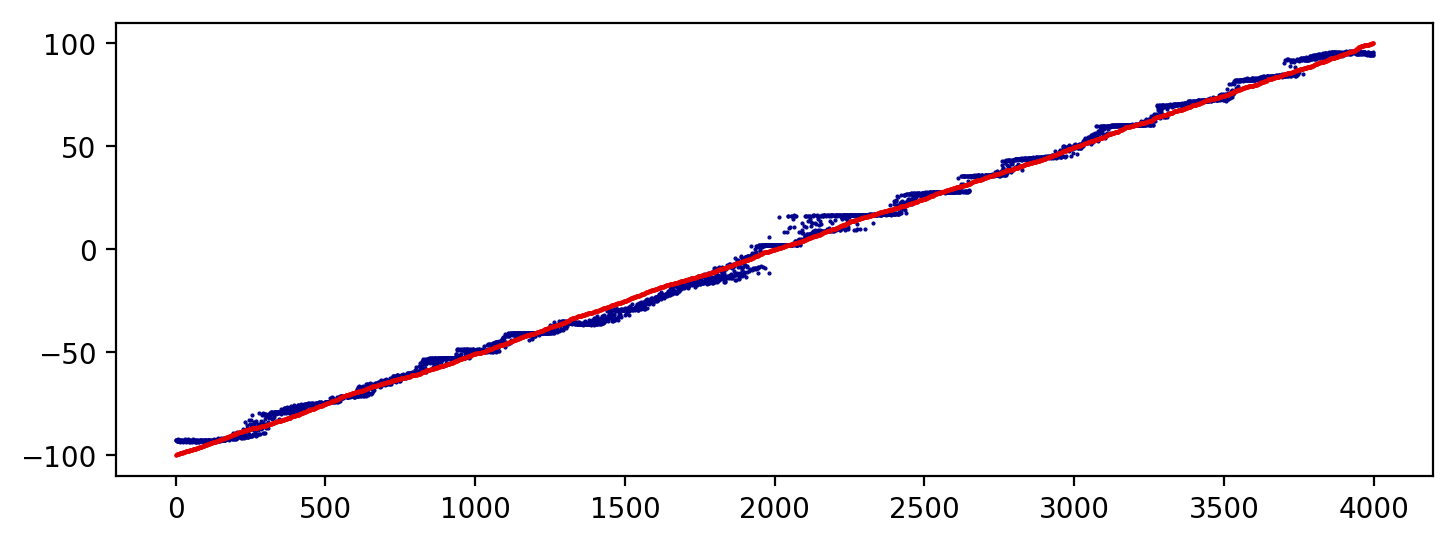

 epoch: 5500 testing_cost: 0.0011452718

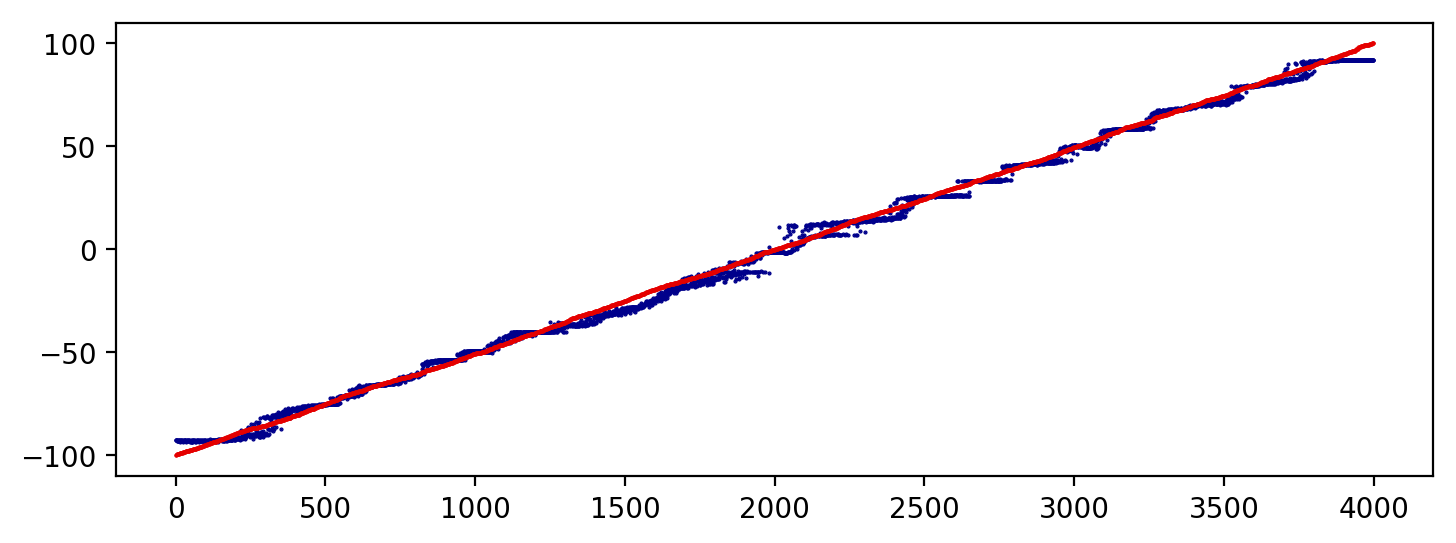

 epoch: 5550 testing_cost: 0.0009813411

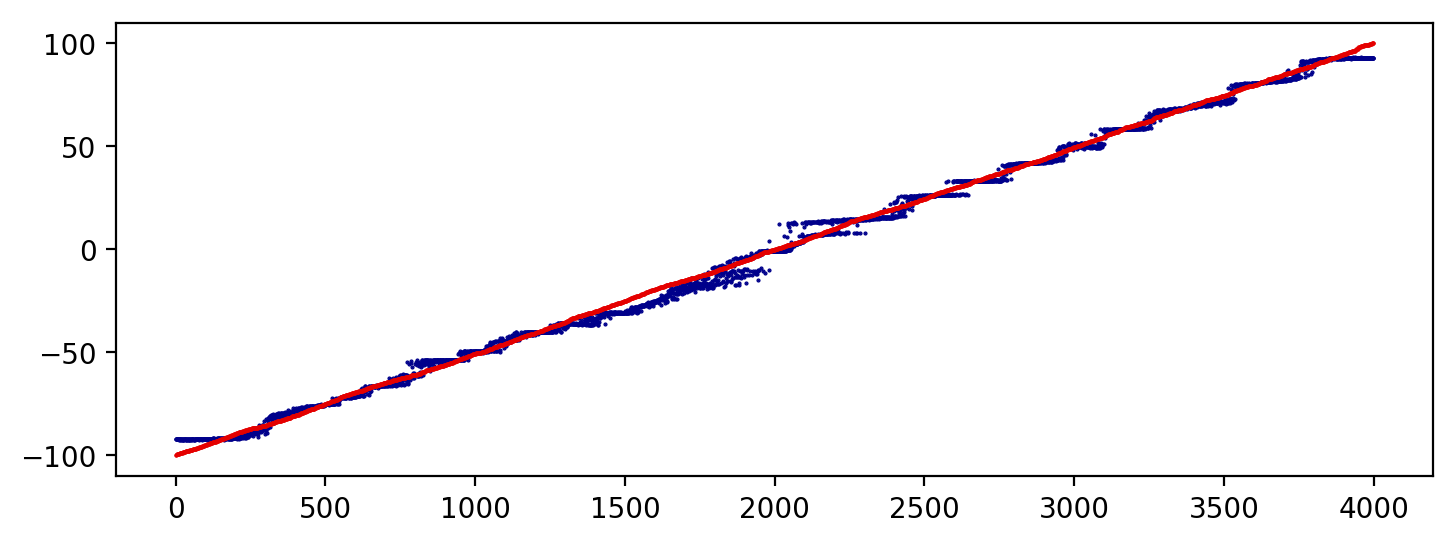

 epoch: 5600 testing_cost: 0.0010894453

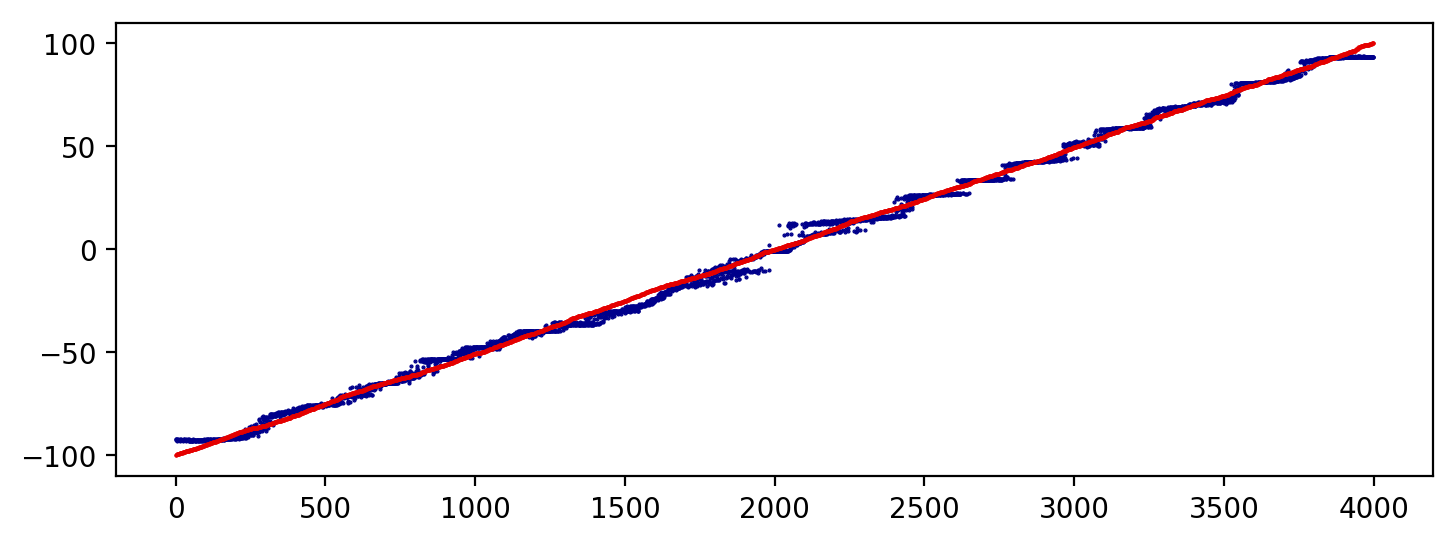

 epoch: 5650 testing_cost: 0.0014387371

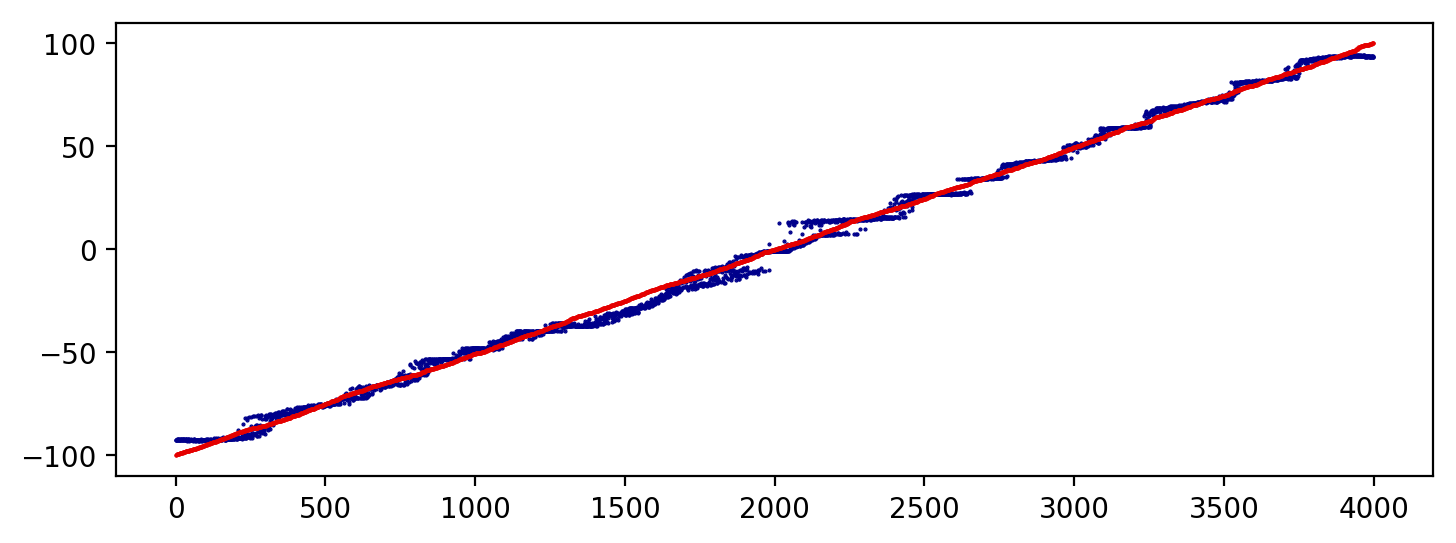

 epoch: 5700 testing_cost: 0.0008999126

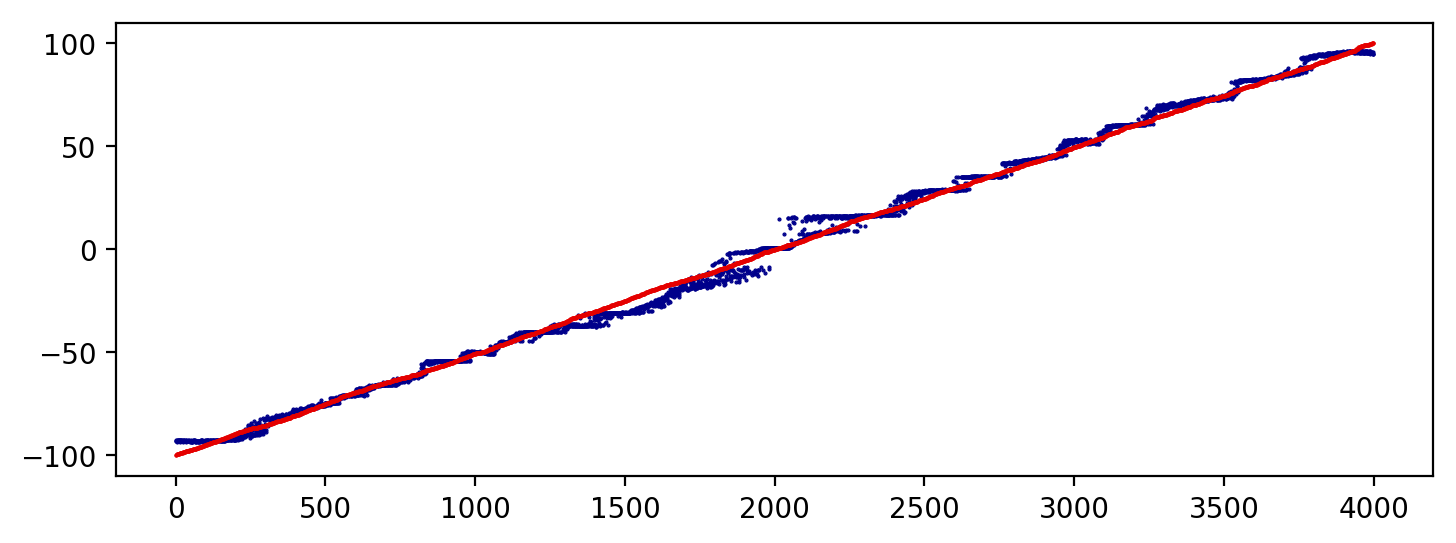

 epoch: 5750 testing_cost: 0.0009153535

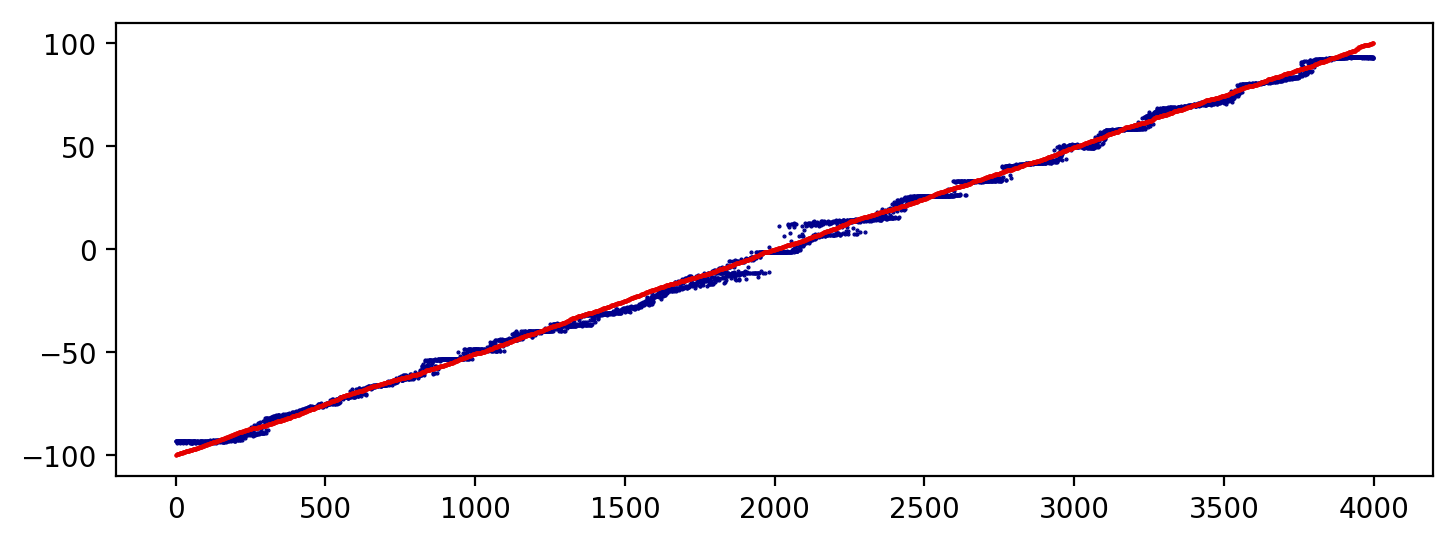

 epoch: 5800 testing_cost: 0.0007494749

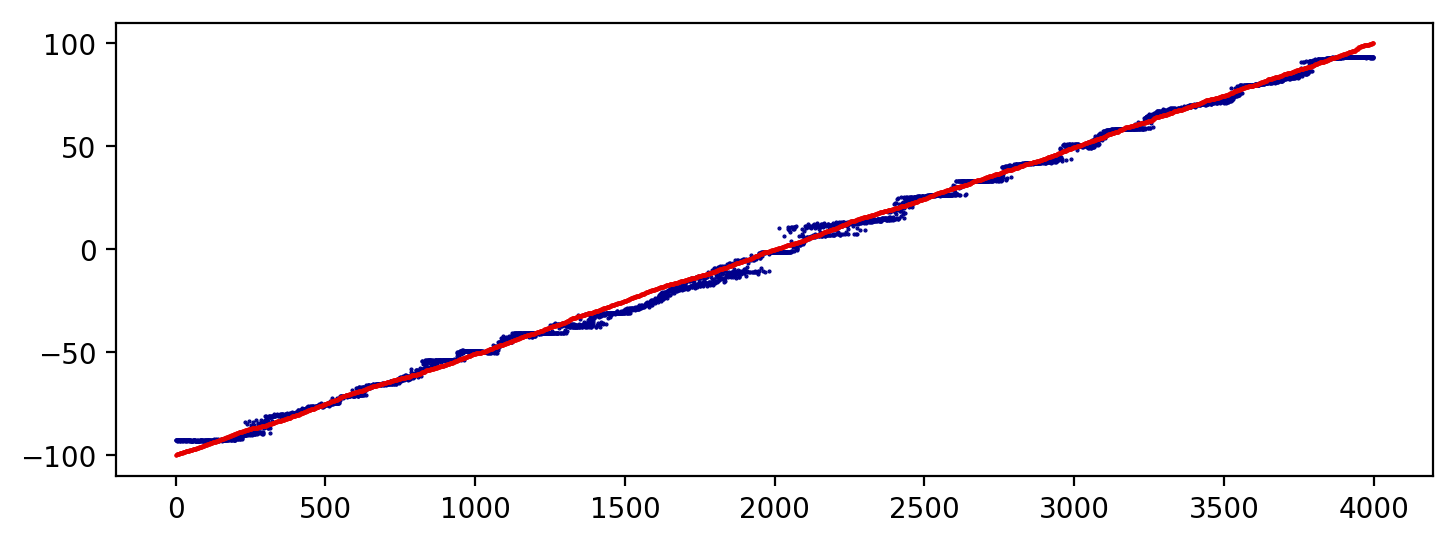

 epoch: 5850 testing_cost: 0.0007166038

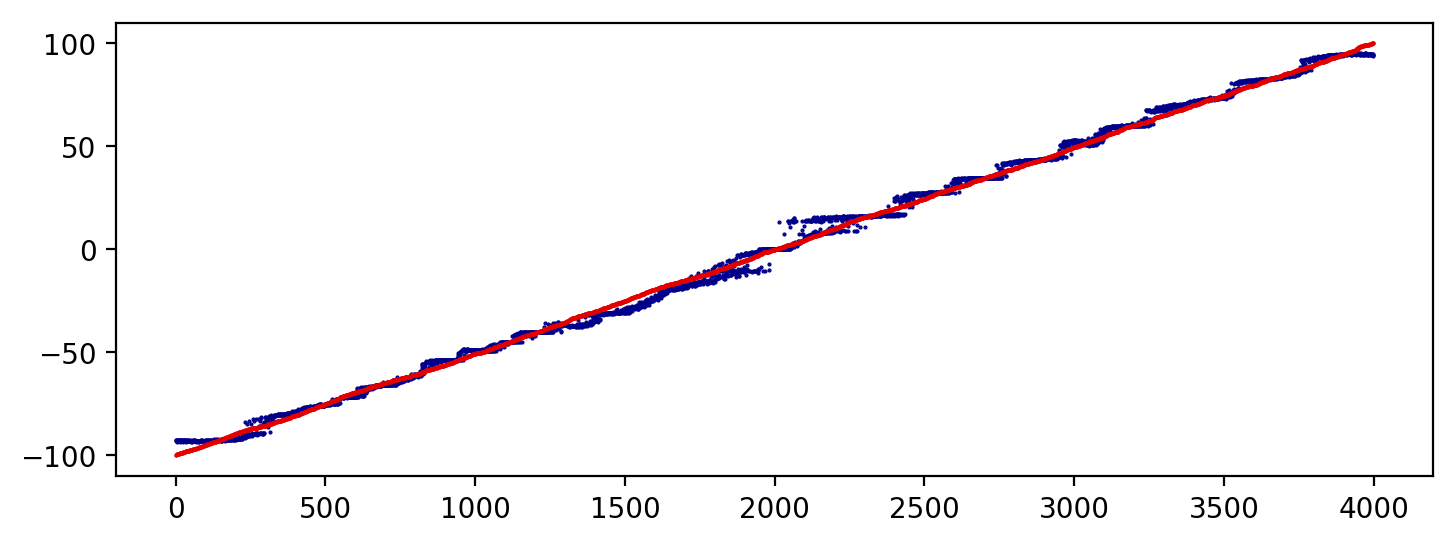

 epoch: 5900 testing_cost: 0.0007600819

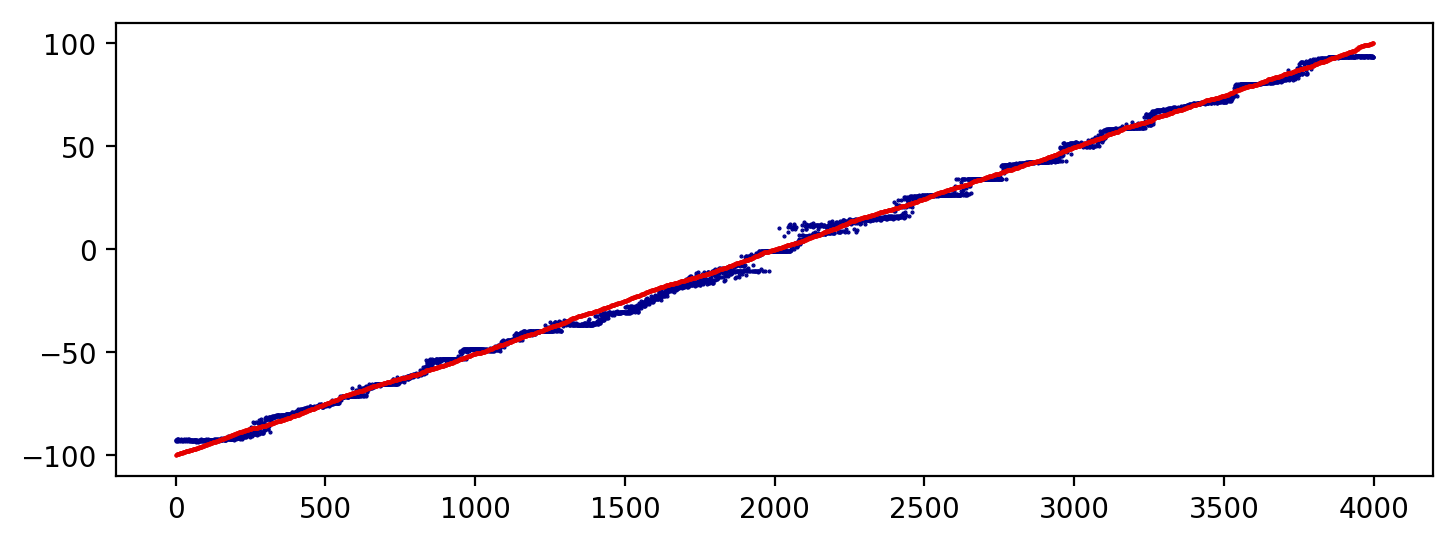

 epoch: 5950 testing_cost: 0.0008279057

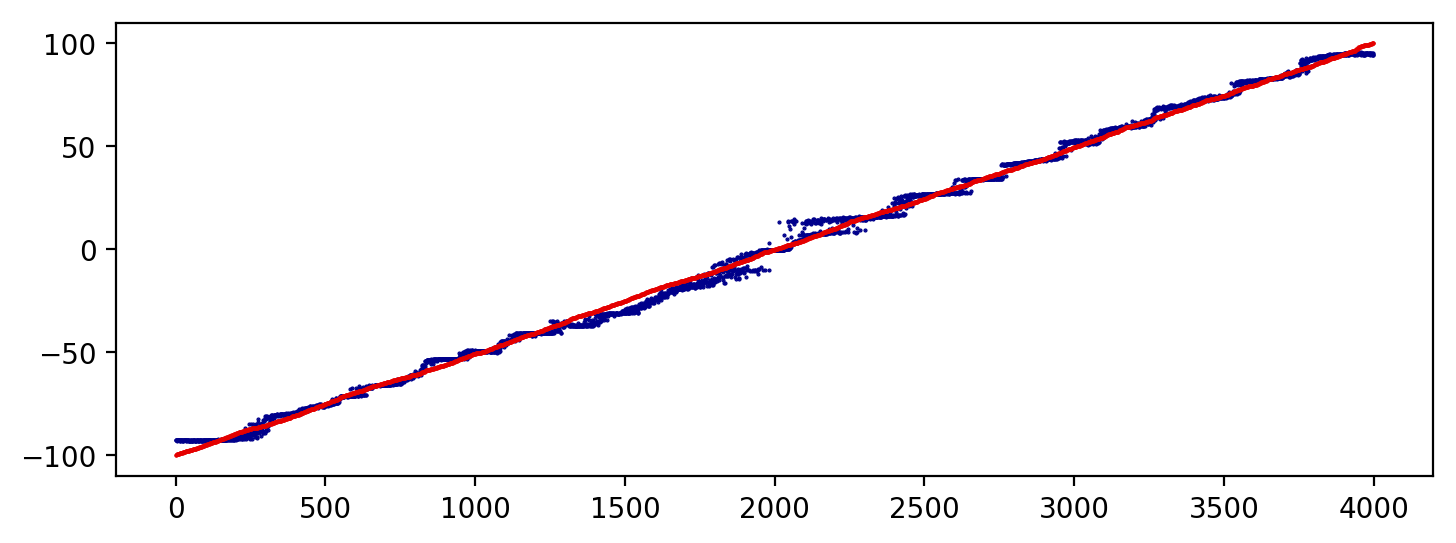

 epoch: 5999 testing_cost: 0.0010550687

In [20]:
with tf.Session() as session:

    saver.restore(session,model_save_location + '-4499')

    training_writer = tf.summary.FileWriter(log_direc + '/training', session.graph)
    testing_writer = tf.summary.FileWriter(log_direc + '/testing', session.graph)
    model_save_location = log_direc + '/trained_model.ckpt'


    for epoch in range(training_epochs):
        epoch = epoch + 3*training_epochs


        # Feed in the training data and do one stepf NN training
        session.run(optimizer,
                    feed_dict = {X: X_scaled_training, Y: Y_scaled_training, keep_prob : 0.50})

        training_feed = {X: X_scaled_training, Y: Y_scaled_training, keep_prob : 0.50}
        training_cost, training_summary = session.run([cost, summary],
                                                feed_dict = training_feed)

        testing_feed =  {X: X_scaled_testing, Y: Y_scaled_testing, keep_prob : 1.00}
        testing_cost, testing_summary = session.run([cost, summary],
                                                     feed_dict = testing_feed)
        sys.stdout.write('\r epoch: {:4.0f} testing_cost: {:2.10f}'.format(epoch, training_cost))
        
        training_writer.add_summary(training_summary, epoch)
        testing_writer.add_summary(testing_summary, epoch)
        testing_writer.flush()
        training_writer.flush()
        
        if epoch % 50 == 0 or epoch == training_epochs:
            saver.save(session, model_save_location, epoch)
            prediction_scaled = session.run(prediction, feed_dict = {X: X_scaled_testing, keep_prob : 1.00})
            prediction_unscaled = Y_scaler.inverse_transform(prediction_scaled)
            sorting_idx = np.argsort(Y_testing.T[0])
        
            fig, ax = plt.subplots(figsize = (8.5, 3), dpi = 100)
            
            ax.plot(prediction_unscaled.T[0][sorting_idx], linestyle = 'none', marker = '.', markersize = 1, color = 'darkblue')
            ax.plot(Y_testing.T[0][sorting_idx], linestyle = 'none', marker = '.', markersize = 1, alpha = 0.75, color = '#E50000')
            plt.show()
            
    saver.save(session, model_save_location, epoch)

In [21]:
print(sum((Y_scaled_testing.T[0] - prediction_scaled.T[0])**2))
print(np.std(abs(Y_testing.T[0] - prediction_unscaled.T[0])))

0.7981785949274081
1.7501127572327515
